In [1]:
import numpy as np
import gymnasium
from gymnasium.wrappers import TimeLimit
from imitation.data import rollout
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.evaluation import evaluate_policy

from gymnasium.spaces import Box
from gymnasium.envs.registration import register
import racing_gym
import os
import json
from PIL import Image
import torch
import time

rng = np.random.default_rng()


/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import json
import numpy as np
from PIL import Image

def load_expert_data_directory(parent_directory):
    # parent_directory内のすべてのディレクトリを取得
    subdirectories = [os.path.join(parent_directory, d) for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
    
    all_expert_data = []  # すべてのディレクトリのexpert_dataを格納するリスト

    for data_path in subdirectories:
        # ディレクトリごとにexpert_dataの初期化
        expert_data = {'images': [], 'actions': []}

        # 画像ファイルに対応するJSONファイルを取得
        json_file_list = [json_file for json_file in os.listdir(data_path) if json_file.startswith('record_') and json_file.endswith('.json')]

        for json_file in json_file_list:
            # レコードのファイルパスを構築
            json_path = os.path.join(data_path, json_file)

            # レコードの読み込み
            try:
                with open(json_path, 'r') as json_file:
                    record_data = json.load(json_file)
            except FileNotFoundError:
                print(f"エラー：{json_path} でJSONファイルが見つかりませんでした。")
                continue
            except json.JSONDecodeError:
                print(f"エラー：{json_path} のJSONファイルのデコードに失敗しました。")
                continue

            # 画像データの読み込み
            image_file = record_data.get('cam/image_array', '')  # 画像ファイル名をJSONから取得
            image_path = os.path.join(data_path, image_file)
            try:
                image_data = np.array(Image.open(image_path))
            except FileNotFoundError:
                print(f"エラー：{image_path} で画像ファイルが見つかりませんでした。")
                continue

            # expert_dataに追加
            expert_data['images'].append(image_data)
            expert_data['actions'].append([record_data.get('user/angle', 0), record_data.get('user/throttle', 0)])
        
        # すべてのディレクトリのexpert_dataをリストに追加
        all_expert_data.append(expert_data)


    return all_expert_data


In [3]:
all_expert_data = load_expert_data_directory('../../autorace/data/S1/')

In [4]:
from imitation.data.types import Transitions

def convert_to_transitions(expert_data):
    obs_array = []
    next_obs_array = []
    action_array = []
    done_array = []
    info_array = []
    # expert_dataの画像と行動をTrajectoryに変換
    for data in expert_data:
        data_size = len(data['images'])
        obs_array+=data['images']
        n_obs = data['images'].copy()
        n_obs.pop(0)
        x, y, z = data['images'][-1].shape
        n_obs.append(np.zeros((x, y, z), dtype=np.uint8))
        next_obs_array+=(n_obs)
        action_array+=data['actions']
        done_array+=[False]*(data_size-1)+[True]
        info_array+=[{}]*data_size
    transitions=Transitions( 
        obs=np.array(obs_array),
        acts=np.array(action_array),
        next_obs=np.array(next_obs_array),
        dones=np.array(done_array),
        infos=np.array(info_array))


    return transitions

In [5]:
reshaped_all_expert_data = all_expert_data.copy()
# すべてのディレクトリに対して
for i in range(len(reshaped_all_expert_data)):
    # すべての画像を変換
    for j in range(len(reshaped_all_expert_data[i]['images'])):
        # 画像の軸の順序を変更
        reshaped_image = np.transpose(reshaped_all_expert_data[i]['images'][j], (2, 0, 1))
        
        # expert_dataに変更を反映
        reshaped_all_expert_data[i]['images'][j] = reshaped_image.copy()

# 形状を確認
print(reshaped_all_expert_data[0]['images'][0].shape)

for i in range(len(reshaped_all_expert_data)):
    for j in range(len(reshaped_all_expert_data[i]['images'])):
        if reshaped_all_expert_data[i]['images'][j].shape != (3, 224, 224):
            print(i, j)

(3, 224, 224)


In [6]:
print(reshaped_all_expert_data[0]['images'][0].shape)
print(all_expert_data[0]['images'][0].shape)

(3, 224, 224)
(3, 224, 224)


In [7]:
test_transition = convert_to_transitions(all_expert_data)
print(test_transition)


Transitions(obs=array([[[[158, 155, 154, ..., 143, 137, 128],
         [156, 156, 156, ..., 139, 135, 127],
         [154, 156, 158, ..., 136, 133, 127],
         ...,
         [106, 109, 112, ..., 113, 112, 112],
         [108, 111, 113, ..., 113, 112, 114],
         [111, 113, 115, ..., 113, 112, 114]],

        [[103, 100,  99, ..., 141, 135, 126],
         [101, 101, 101, ..., 137, 133, 125],
         [ 99, 101, 103, ..., 134, 131, 125],
         ...,
         [ 55,  58,  61, ..., 116, 115, 115],
         [ 57,  60,  62, ..., 116, 115, 117],
         [ 60,  62,  64, ..., 116, 115, 117]],

        [[ 73,  70,  69, ..., 154, 148, 139],
         [ 71,  71,  71, ..., 150, 146, 138],
         [ 69,  71,  73, ..., 147, 144, 138],
         ...,
         [ 34,  37,  40, ..., 135, 134, 134],
         [ 36,  39,  41, ..., 135, 134, 136],
         [ 39,  41,  43, ..., 135, 134, 136]]],


       [[[169, 170, 171, ..., 138, 145, 150],
         [170, 171, 172, ..., 135, 140, 143],
         [171,

In [8]:
env_id1 = 'RacingEnv-v1'  # あなたの環境の名前に変更してください
try:
    env1 = gymnasium.make(env_id1, expert_data=reshaped_all_expert_data)
    print(f"Environment '{env_id1}' is successfully registered.")
except gymnasium.error.Error as e:
    print(f"Error: {e}")

4
Environment 'RacingEnv-v1' is successfully registered.


/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment RacingEnv-v1 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(


In [9]:
def _make_env():
    """Helper function to create a single environment. Put any logic here, but make sure to return a RolloutInfoWrapper."""
    _env1 = gymnasium.make("RacingEnv-v1", expert_data=reshaped_all_expert_data)
    _env1 = RolloutInfoWrapper(_env1)
    return _env1

venv1 = DummyVecEnv([_make_env for _ in range(4)])

5
10
5
10


In [29]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3.common.evaluation import evaluate_policy


expert = PPO(
    policy=CnnPolicy,
    env=env1,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
    device='cuda:1'
)
reward, _ = evaluate_policy(expert, env1, 10)
print(f"Reward before training: {reward}")


# Note: if you followed step 2a, i.e. registered the environment, you can use the environment name directly

# expert = PPO(
#     policy=MlpPolicy,
#     env="custom/ObservationMatching-v0",
#     seed=0,
#     batch_size=64,
#     ent_coef=0.0,
#     learning_rate=0.0003,
#     n_epochs=10,
#     n_steps=64,
# )
expert.learn(1000)  # Note: set to 100000 to train a proficient expert
reward, _ = evaluate_policy(expert, expert.get_env(), 10)
print(f"Expert reward: {reward}")

/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


12
15
0
3
3
7
9
19
18
4
6
Reward before training: 501.9597597211599
12
18
13
16
12
12
11
14
19
2
18
6
Expert reward: 826.7089047


In [30]:

rollouts = rollout.rollout(
    expert,
    venv1,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)
transitions = rollout.flatten_trajectories(rollouts)

1
5
19
7
16
8
0
6
1
0
3
9
15
5
12
2
1
7
11
18
13
12
12
17
9
20
11
3
2
8
10
7
13
8
19
15
19
11
19
17
3
19
4
19
20
15
18
2
9
11
18
20
12
5
15
11
2
10
14
12
10
7


In [49]:
print(len(transitions))
print(len(test_trajectory))

count = 0
for i in range(len(transitions)):
    if transitions[i]['dones']:
        count += 1

print(count)
count = 0
for i in range(len(test_trajectory)):
    if test_trajectory[i]['dones']:
        count += 1

print(count)

58958
22690
53
21


In [38]:
# transitionのdoneがTrueのときのnext_obsをprintしたい
# それを見て、次のobsが正しく取れているか確認したい
for i in range(len(transitions)):
    if transitions[i]['dones']:
        print(transitions[i]['next_obs'])
        a = transitions[i]['next_obs']
        print(transitions[i+1]['obs'])
        print(i)
        break

for i in range(len(transitions)):
    if np.array_equal(a, transitions[i]['obs']):
        print(i)
        break

    if i == len(transitions)-1:
        print("not found")



[[[143 146 143 ... 145 151 148]
  [136 139 137 ... 147 151 143]
  [135 136 134 ... 149 151 137]
  ...
  [ 67  71  74 ... 116 117 122]
  [ 74  76  77 ... 116 116 123]
  [ 78  78  77 ... 116 117 125]]

 [[150 153 150 ... 147 153 150]
  [143 146 144 ... 149 153 145]
  [142 143 141 ... 151 153 139]
  ...
  [ 74  78  81 ... 129 130 135]
  [ 81  83  84 ... 129 129 136]
  [ 84  84  83 ... 129 130 138]]

 [[156 159 156 ... 168 174 171]
  [149 152 150 ... 170 174 166]
  [148 149 147 ... 172 174 160]
  ...
  [ 84  88  91 ... 163 164 169]
  [ 91  93  94 ... 163 163 170]
  [ 96  96  95 ... 163 164 172]]]
[[[ 83  85  87 ... 132 123 126]
  [ 85  86  88 ... 140 131 132]
  [ 88  88  88 ... 145 138 135]
  ...
  [ 84  85  85 ... 103 104 106]
  [ 83  84  86 ... 102 104 108]
  [ 82  84  87 ...  99 102 105]]

 [[ 86  88  90 ... 132 123 126]
  [ 88  89  91 ... 140 131 132]
  [ 91  91  91 ... 145 138 135]
  ...
  [ 50  51  51 ... 108 107 109]
  [ 49  50  52 ... 107 109 111]
  [ 48  50  53 ... 104 107 110]]



In [10]:
from imitation.algorithms import bc
from imitation.util import logger

bc_logger = logger.configure('./log/')
bc_trainer = bc.BC(
    observation_space=env1.observation_space,
    action_space=env1.action_space,
    demonstrations=test_transition,
    rng=rng,
    policy=ActorCriticCnnPolicy(
        observation_space=env1.observation_space,
        action_space=env1.action_space,
        features_extractor_kwargs=dict(features_dim=256),
        lr_schedule=lambda _: 0.0003,
        ),
    batch_size=2048,
    device="cuda:1",
    custom_logger=bc_logger
)

In [11]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, venv1, 10)
print(f"Reward before training: {reward_before_training}")

/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


5
20
0
11
16
0
13
21
21
11
21
1
7
0
4
Reward before training: 418.6147927194834


In [12]:
bc_trainer.train(n_epochs=600, log_interval=1)
reward_after_training, _ = evaluate_policy(bc_trainer.policy, venv1, 10)
print(f"Reward after training: {reward_after_training}")

10batch [00:03,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 9        |
|    ent_loss       | -0.00282 |
|    entropy        | 2.82     |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 441      |
|    loss           | 2.19     |
|    neglogp        | 2.19     |
|    prob_true_act  | 0.121    |
|    samples_so_far | 20480    |
--------------------------------


20batch [00:07,  2.71batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 19       |
|    ent_loss       | -0.0028  |
|    entropy        | 2.8      |
|    epoch          | 2        |
|    l2_loss        | 0        |
|    l2_norm        | 463      |
|    loss           | 2.02     |
|    neglogp        | 2.02     |
|    prob_true_act  | 0.137    |
|    samples_so_far | 40960    |
--------------------------------


30batch [00:10,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 29       |
|    ent_loss       | -0.00278 |
|    entropy        | 2.78     |
|    epoch          | 3        |
|    l2_loss        | 0        |
|    l2_norm        | 480      |
|    loss           | 1.9      |
|    neglogp        | 1.9      |
|    prob_true_act  | 0.151    |
|    samples_so_far | 61440    |
--------------------------------


40batch [00:14,  3.05batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 39       |
|    ent_loss       | -0.00275 |
|    entropy        | 2.75     |
|    epoch          | 4        |
|    l2_loss        | 0        |
|    l2_norm        | 494      |
|    loss           | 1.85     |
|    neglogp        | 1.86     |
|    prob_true_act  | 0.157    |
|    samples_so_far | 81920    |
--------------------------------


50batch [00:17,  3.04batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 49       |
|    ent_loss       | -0.00273 |
|    entropy        | 2.73     |
|    epoch          | 5        |
|    l2_loss        | 0        |
|    l2_norm        | 509      |
|    loss           | 1.82     |
|    neglogp        | 1.82     |
|    prob_true_act  | 0.162    |
|    samples_so_far | 102400   |
--------------------------------


60batch [00:21,  2.75batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 59       |
|    ent_loss       | -0.00271 |
|    entropy        | 2.71     |
|    epoch          | 6        |
|    l2_loss        | 0        |
|    l2_norm        | 522      |
|    loss           | 1.8      |
|    neglogp        | 1.8      |
|    prob_true_act  | 0.167    |
|    samples_so_far | 122880   |
--------------------------------


70batch [00:24,  3.04batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 69       |
|    ent_loss       | -0.00269 |
|    entropy        | 2.69     |
|    epoch          | 7        |
|    l2_loss        | 0        |
|    l2_norm        | 536      |
|    loss           | 1.77     |
|    neglogp        | 1.78     |
|    prob_true_act  | 0.17     |
|    samples_so_far | 143360   |
--------------------------------


80batch [00:28,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 79       |
|    ent_loss       | -0.00267 |
|    entropy        | 2.67     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 549      |
|    loss           | 1.75     |
|    neglogp        | 1.75     |
|    prob_true_act  | 0.175    |
|    samples_so_far | 163840   |
--------------------------------


90batch [00:31,  3.05batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 89       |
|    ent_loss       | -0.00264 |
|    entropy        | 2.64     |
|    epoch          | 9        |
|    l2_loss        | 0        |
|    l2_norm        | 561      |
|    loss           | 1.72     |
|    neglogp        | 1.72     |
|    prob_true_act  | 0.18     |
|    samples_so_far | 184320   |
--------------------------------


100batch [00:34,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 99       |
|    ent_loss       | -0.00262 |
|    entropy        | 2.62     |
|    epoch          | 10       |
|    l2_loss        | 0        |
|    l2_norm        | 573      |
|    loss           | 1.7      |
|    neglogp        | 1.7      |
|    prob_true_act  | 0.184    |
|    samples_so_far | 204800   |
--------------------------------


110batch [00:38,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 109      |
|    ent_loss       | -0.0026  |
|    entropy        | 2.6      |
|    epoch          | 11       |
|    l2_loss        | 0        |
|    l2_norm        | 587      |
|    loss           | 1.67     |
|    neglogp        | 1.67     |
|    prob_true_act  | 0.189    |
|    samples_so_far | 225280   |
--------------------------------


120batch [00:41,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 119      |
|    ent_loss       | -0.00258 |
|    entropy        | 2.58     |
|    epoch          | 12       |
|    l2_loss        | 0        |
|    l2_norm        | 602      |
|    loss           | 1.66     |
|    neglogp        | 1.66     |
|    prob_true_act  | 0.191    |
|    samples_so_far | 245760   |
--------------------------------


130batch [00:45,  3.05batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 129      |
|    ent_loss       | -0.00256 |
|    entropy        | 2.56     |
|    epoch          | 13       |
|    l2_loss        | 0        |
|    l2_norm        | 615      |
|    loss           | 1.65     |
|    neglogp        | 1.65     |
|    prob_true_act  | 0.193    |
|    samples_so_far | 266240   |
--------------------------------


140batch [00:48,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 139      |
|    ent_loss       | -0.00254 |
|    entropy        | 2.54     |
|    epoch          | 14       |
|    l2_loss        | 0        |
|    l2_norm        | 627      |
|    loss           | 1.62     |
|    neglogp        | 1.62     |
|    prob_true_act  | 0.199    |
|    samples_so_far | 286720   |
--------------------------------


150batch [00:52,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 149      |
|    ent_loss       | -0.00252 |
|    entropy        | 2.52     |
|    epoch          | 15       |
|    l2_loss        | 0        |
|    l2_norm        | 638      |
|    loss           | 1.61     |
|    neglogp        | 1.61     |
|    prob_true_act  | 0.202    |
|    samples_so_far | 307200   |
--------------------------------


160batch [00:55,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 159      |
|    ent_loss       | -0.0025  |
|    entropy        | 2.5      |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 649      |
|    loss           | 1.57     |
|    neglogp        | 1.58     |
|    prob_true_act  | 0.208    |
|    samples_so_far | 327680   |
--------------------------------


170batch [00:59,  3.04batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 169      |
|    ent_loss       | -0.00248 |
|    entropy        | 2.48     |
|    epoch          | 17       |
|    l2_loss        | 0        |
|    l2_norm        | 661      |
|    loss           | 1.56     |
|    neglogp        | 1.56     |
|    prob_true_act  | 0.212    |
|    samples_so_far | 348160   |
--------------------------------


180batch [01:02,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 179      |
|    ent_loss       | -0.00245 |
|    entropy        | 2.45     |
|    epoch          | 18       |
|    l2_loss        | 0        |
|    l2_norm        | 673      |
|    loss           | 1.54     |
|    neglogp        | 1.55     |
|    prob_true_act  | 0.215    |
|    samples_so_far | 368640   |
--------------------------------


190batch [01:06,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 189      |
|    ent_loss       | -0.00243 |
|    entropy        | 2.43     |
|    epoch          | 19       |
|    l2_loss        | 0        |
|    l2_norm        | 686      |
|    loss           | 1.52     |
|    neglogp        | 1.52     |
|    prob_true_act  | 0.221    |
|    samples_so_far | 389120   |
--------------------------------


200batch [01:09,  3.05batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 199      |
|    ent_loss       | -0.00241 |
|    entropy        | 2.41     |
|    epoch          | 20       |
|    l2_loss        | 0        |
|    l2_norm        | 699      |
|    loss           | 1.5      |
|    neglogp        | 1.5      |
|    prob_true_act  | 0.225    |
|    samples_so_far | 409600   |
--------------------------------


210batch [01:13,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 209      |
|    ent_loss       | -0.00239 |
|    entropy        | 2.39     |
|    epoch          | 21       |
|    l2_loss        | 0        |
|    l2_norm        | 714      |
|    loss           | 1.48     |
|    neglogp        | 1.48     |
|    prob_true_act  | 0.229    |
|    samples_so_far | 430080   |
--------------------------------


220batch [01:16,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 219      |
|    ent_loss       | -0.00237 |
|    entropy        | 2.37     |
|    epoch          | 22       |
|    l2_loss        | 0        |
|    l2_norm        | 730      |
|    loss           | 1.46     |
|    neglogp        | 1.46     |
|    prob_true_act  | 0.234    |
|    samples_so_far | 450560   |
--------------------------------


230batch [01:20,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 229      |
|    ent_loss       | -0.00235 |
|    entropy        | 2.35     |
|    epoch          | 23       |
|    l2_loss        | 0        |
|    l2_norm        | 746      |
|    loss           | 1.44     |
|    neglogp        | 1.44     |
|    prob_true_act  | 0.239    |
|    samples_so_far | 471040   |
--------------------------------


240batch [01:23,  3.05batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 239      |
|    ent_loss       | -0.00233 |
|    entropy        | 2.33     |
|    epoch          | 24       |
|    l2_loss        | 0        |
|    l2_norm        | 763      |
|    loss           | 1.42     |
|    neglogp        | 1.42     |
|    prob_true_act  | 0.244    |
|    samples_so_far | 491520   |
--------------------------------


250batch [01:27,  3.04batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 249      |
|    ent_loss       | -0.00231 |
|    entropy        | 2.31     |
|    epoch          | 25       |
|    l2_loss        | 0        |
|    l2_norm        | 780      |
|    loss           | 1.41     |
|    neglogp        | 1.41     |
|    prob_true_act  | 0.247    |
|    samples_so_far | 512000   |
--------------------------------


260batch [01:30,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 259      |
|    ent_loss       | -0.00229 |
|    entropy        | 2.29     |
|    epoch          | 26       |
|    l2_loss        | 0        |
|    l2_norm        | 799      |
|    loss           | 1.39     |
|    neglogp        | 1.4      |
|    prob_true_act  | 0.251    |
|    samples_so_far | 532480   |
--------------------------------


270batch [01:33,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 269      |
|    ent_loss       | -0.00227 |
|    entropy        | 2.27     |
|    epoch          | 27       |
|    l2_loss        | 0        |
|    l2_norm        | 816      |
|    loss           | 1.36     |
|    neglogp        | 1.37     |
|    prob_true_act  | 0.258    |
|    samples_so_far | 552960   |
--------------------------------


280batch [01:37,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 279      |
|    ent_loss       | -0.00225 |
|    entropy        | 2.25     |
|    epoch          | 28       |
|    l2_loss        | 0        |
|    l2_norm        | 831      |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.263    |
|    samples_so_far | 573440   |
--------------------------------


290batch [01:40,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 289      |
|    ent_loss       | -0.00223 |
|    entropy        | 2.23     |
|    epoch          | 29       |
|    l2_loss        | 0        |
|    l2_norm        | 847      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.269    |
|    samples_so_far | 593920   |
--------------------------------


300batch [01:44,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 299      |
|    ent_loss       | -0.00221 |
|    entropy        | 2.21     |
|    epoch          | 30       |
|    l2_loss        | 0        |
|    l2_norm        | 863      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.275    |
|    samples_so_far | 614400   |
--------------------------------


310batch [01:47,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 309      |
|    ent_loss       | -0.00219 |
|    entropy        | 2.19     |
|    epoch          | 31       |
|    l2_loss        | 0        |
|    l2_norm        | 881      |
|    loss           | 1.29     |
|    neglogp        | 1.29     |
|    prob_true_act  | 0.279    |
|    samples_so_far | 634880   |
--------------------------------


320batch [01:51,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 319      |
|    ent_loss       | -0.00217 |
|    entropy        | 2.17     |
|    epoch          | 32       |
|    l2_loss        | 0        |
|    l2_norm        | 901      |
|    loss           | 1.26     |
|    neglogp        | 1.27     |
|    prob_true_act  | 0.285    |
|    samples_so_far | 655360   |
--------------------------------


330batch [01:54,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 329      |
|    ent_loss       | -0.00215 |
|    entropy        | 2.15     |
|    epoch          | 33       |
|    l2_loss        | 0        |
|    l2_norm        | 920      |
|    loss           | 1.26     |
|    neglogp        | 1.26     |
|    prob_true_act  | 0.289    |
|    samples_so_far | 675840   |
--------------------------------


340batch [01:58,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 339      |
|    ent_loss       | -0.00213 |
|    entropy        | 2.13     |
|    epoch          | 34       |
|    l2_loss        | 0        |
|    l2_norm        | 940      |
|    loss           | 1.23     |
|    neglogp        | 1.23     |
|    prob_true_act  | 0.296    |
|    samples_so_far | 696320   |
--------------------------------


350batch [02:01,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 349      |
|    ent_loss       | -0.00211 |
|    entropy        | 2.11     |
|    epoch          | 35       |
|    l2_loss        | 0        |
|    l2_norm        | 960      |
|    loss           | 1.22     |
|    neglogp        | 1.22     |
|    prob_true_act  | 0.299    |
|    samples_so_far | 716800   |
--------------------------------


360batch [02:05,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 359      |
|    ent_loss       | -0.00209 |
|    entropy        | 2.09     |
|    epoch          | 36       |
|    l2_loss        | 0        |
|    l2_norm        | 981      |
|    loss           | 1.18     |
|    neglogp        | 1.19     |
|    prob_true_act  | 0.309    |
|    samples_so_far | 737280   |
--------------------------------


370batch [02:08,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 369      |
|    ent_loss       | -0.00207 |
|    entropy        | 2.07     |
|    epoch          | 37       |
|    l2_loss        | 0        |
|    l2_norm        | 1e+03    |
|    loss           | 1.17     |
|    neglogp        | 1.18     |
|    prob_true_act  | 0.313    |
|    samples_so_far | 757760   |
--------------------------------


380batch [02:12,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 379      |
|    ent_loss       | -0.00205 |
|    entropy        | 2.05     |
|    epoch          | 38       |
|    l2_loss        | 0        |
|    l2_norm        | 1.03e+03 |
|    loss           | 1.15     |
|    neglogp        | 1.15     |
|    prob_true_act  | 0.321    |
|    samples_so_far | 778240   |
--------------------------------


390batch [02:15,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 389      |
|    ent_loss       | -0.00203 |
|    entropy        | 2.03     |
|    epoch          | 39       |
|    l2_loss        | 0        |
|    l2_norm        | 1.05e+03 |
|    loss           | 1.13     |
|    neglogp        | 1.14     |
|    prob_true_act  | 0.325    |
|    samples_so_far | 798720   |
--------------------------------


400batch [02:19,  3.04batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 399      |
|    ent_loss       | -0.00201 |
|    entropy        | 2.01     |
|    epoch          | 40       |
|    l2_loss        | 0        |
|    l2_norm        | 1.07e+03 |
|    loss           | 1.11     |
|    neglogp        | 1.11     |
|    prob_true_act  | 0.334    |
|    samples_so_far | 819200   |
--------------------------------


410batch [02:22,  3.04batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 409      |
|    ent_loss       | -0.00199 |
|    entropy        | 1.99     |
|    epoch          | 41       |
|    l2_loss        | 0        |
|    l2_norm        | 1.09e+03 |
|    loss           | 1.09     |
|    neglogp        | 1.1      |
|    prob_true_act  | 0.339    |
|    samples_so_far | 839680   |
--------------------------------


420batch [02:26,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 419      |
|    ent_loss       | -0.00197 |
|    entropy        | 1.97     |
|    epoch          | 42       |
|    l2_loss        | 0        |
|    l2_norm        | 1.12e+03 |
|    loss           | 1.07     |
|    neglogp        | 1.07     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 860160   |
--------------------------------


430batch [02:29,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 429      |
|    ent_loss       | -0.00195 |
|    entropy        | 1.95     |
|    epoch          | 43       |
|    l2_loss        | 0        |
|    l2_norm        | 1.14e+03 |
|    loss           | 1.05     |
|    neglogp        | 1.05     |
|    prob_true_act  | 0.354    |
|    samples_so_far | 880640   |
--------------------------------


440batch [02:33,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 439      |
|    ent_loss       | -0.00193 |
|    entropy        | 1.93     |
|    epoch          | 44       |
|    l2_loss        | 0        |
|    l2_norm        | 1.16e+03 |
|    loss           | 1.03     |
|    neglogp        | 1.03     |
|    prob_true_act  | 0.362    |
|    samples_so_far | 901120   |
--------------------------------


450batch [02:36,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 449      |
|    ent_loss       | -0.00191 |
|    entropy        | 1.91     |
|    epoch          | 45       |
|    l2_loss        | 0        |
|    l2_norm        | 1.18e+03 |
|    loss           | 1.01     |
|    neglogp        | 1.01     |
|    prob_true_act  | 0.368    |
|    samples_so_far | 921600   |
--------------------------------


460batch [02:40,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 459      |
|    ent_loss       | -0.00189 |
|    entropy        | 1.89     |
|    epoch          | 46       |
|    l2_loss        | 0        |
|    l2_norm        | 1.21e+03 |
|    loss           | 0.997    |
|    neglogp        | 0.999    |
|    prob_true_act  | 0.374    |
|    samples_so_far | 942080   |
--------------------------------


470batch [02:43,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 469      |
|    ent_loss       | -0.00187 |
|    entropy        | 1.87     |
|    epoch          | 47       |
|    l2_loss        | 0        |
|    l2_norm        | 1.23e+03 |
|    loss           | 0.966    |
|    neglogp        | 0.967    |
|    prob_true_act  | 0.385    |
|    samples_so_far | 962560   |
--------------------------------


480batch [02:47,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 479      |
|    ent_loss       | -0.00185 |
|    entropy        | 1.85     |
|    epoch          | 48       |
|    l2_loss        | 0        |
|    l2_norm        | 1.25e+03 |
|    loss           | 0.961    |
|    neglogp        | 0.962    |
|    prob_true_act  | 0.388    |
|    samples_so_far | 983040   |
--------------------------------


490batch [02:50,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 489      |
|    ent_loss       | -0.00183 |
|    entropy        | 1.83     |
|    epoch          | 49       |
|    l2_loss        | 0        |
|    l2_norm        | 1.27e+03 |
|    loss           | 0.941    |
|    neglogp        | 0.943    |
|    prob_true_act  | 0.397    |
|    samples_so_far | 1003520  |
--------------------------------


500batch [02:54,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 499      |
|    ent_loss       | -0.00181 |
|    entropy        | 1.81     |
|    epoch          | 50       |
|    l2_loss        | 0        |
|    l2_norm        | 1.3e+03  |
|    loss           | 0.91     |
|    neglogp        | 0.912    |
|    prob_true_act  | 0.408    |
|    samples_so_far | 1024000  |
--------------------------------


510batch [02:57,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 509      |
|    ent_loss       | -0.00179 |
|    entropy        | 1.79     |
|    epoch          | 51       |
|    l2_loss        | 0        |
|    l2_norm        | 1.32e+03 |
|    loss           | 0.898    |
|    neglogp        | 0.9      |
|    prob_true_act  | 0.413    |
|    samples_so_far | 1044480  |
--------------------------------


520batch [03:01,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 519      |
|    ent_loss       | -0.00177 |
|    entropy        | 1.77     |
|    epoch          | 52       |
|    l2_loss        | 0        |
|    l2_norm        | 1.34e+03 |
|    loss           | 0.873    |
|    neglogp        | 0.874    |
|    prob_true_act  | 0.423    |
|    samples_so_far | 1064960  |
--------------------------------


530batch [03:04,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 529      |
|    ent_loss       | -0.00175 |
|    entropy        | 1.75     |
|    epoch          | 53       |
|    l2_loss        | 0        |
|    l2_norm        | 1.37e+03 |
|    loss           | 0.855    |
|    neglogp        | 0.857    |
|    prob_true_act  | 0.432    |
|    samples_so_far | 1085440  |
--------------------------------


540batch [03:08,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 539      |
|    ent_loss       | -0.00173 |
|    entropy        | 1.73     |
|    epoch          | 54       |
|    l2_loss        | 0        |
|    l2_norm        | 1.39e+03 |
|    loss           | 0.84     |
|    neglogp        | 0.841    |
|    prob_true_act  | 0.439    |
|    samples_so_far | 1105920  |
--------------------------------


550batch [03:11,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 549      |
|    ent_loss       | -0.00171 |
|    entropy        | 1.71     |
|    epoch          | 55       |
|    l2_loss        | 0        |
|    l2_norm        | 1.41e+03 |
|    loss           | 0.825    |
|    neglogp        | 0.827    |
|    prob_true_act  | 0.443    |
|    samples_so_far | 1126400  |
--------------------------------


560batch [03:15,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 559      |
|    ent_loss       | -0.00169 |
|    entropy        | 1.69     |
|    epoch          | 56       |
|    l2_loss        | 0        |
|    l2_norm        | 1.44e+03 |
|    loss           | 0.8      |
|    neglogp        | 0.802    |
|    prob_true_act  | 0.456    |
|    samples_so_far | 1146880  |
--------------------------------


570batch [03:18,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 569      |
|    ent_loss       | -0.00167 |
|    entropy        | 1.67     |
|    epoch          | 57       |
|    l2_loss        | 0        |
|    l2_norm        | 1.46e+03 |
|    loss           | 0.778    |
|    neglogp        | 0.779    |
|    prob_true_act  | 0.465    |
|    samples_so_far | 1167360  |
--------------------------------


580batch [03:22,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 579      |
|    ent_loss       | -0.00165 |
|    entropy        | 1.65     |
|    epoch          | 58       |
|    l2_loss        | 0        |
|    l2_norm        | 1.49e+03 |
|    loss           | 0.753    |
|    neglogp        | 0.755    |
|    prob_true_act  | 0.479    |
|    samples_so_far | 1187840  |
--------------------------------


590batch [03:25,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 589      |
|    ent_loss       | -0.00163 |
|    entropy        | 1.63     |
|    epoch          | 59       |
|    l2_loss        | 0        |
|    l2_norm        | 1.51e+03 |
|    loss           | 0.745    |
|    neglogp        | 0.747    |
|    prob_true_act  | 0.482    |
|    samples_so_far | 1208320  |
--------------------------------


600batch [03:29,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 599      |
|    ent_loss       | -0.00161 |
|    entropy        | 1.61     |
|    epoch          | 60       |
|    l2_loss        | 0        |
|    l2_norm        | 1.53e+03 |
|    loss           | 0.716    |
|    neglogp        | 0.718    |
|    prob_true_act  | 0.496    |
|    samples_so_far | 1228800  |
--------------------------------


610batch [03:32,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 609      |
|    ent_loss       | -0.00159 |
|    entropy        | 1.59     |
|    epoch          | 61       |
|    l2_loss        | 0        |
|    l2_norm        | 1.56e+03 |
|    loss           | 0.698    |
|    neglogp        | 0.7      |
|    prob_true_act  | 0.507    |
|    samples_so_far | 1249280  |
--------------------------------


620batch [03:36,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 619      |
|    ent_loss       | -0.00157 |
|    entropy        | 1.57     |
|    epoch          | 62       |
|    l2_loss        | 0        |
|    l2_norm        | 1.58e+03 |
|    loss           | 0.693    |
|    neglogp        | 0.694    |
|    prob_true_act  | 0.509    |
|    samples_so_far | 1269760  |
--------------------------------


630batch [03:39,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 629      |
|    ent_loss       | -0.00155 |
|    entropy        | 1.55     |
|    epoch          | 63       |
|    l2_loss        | 0        |
|    l2_norm        | 1.6e+03  |
|    loss           | 0.649    |
|    neglogp        | 0.651    |
|    prob_true_act  | 0.53     |
|    samples_so_far | 1290240  |
--------------------------------


640batch [03:43,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 639      |
|    ent_loss       | -0.00153 |
|    entropy        | 1.53     |
|    epoch          | 64       |
|    l2_loss        | 0        |
|    l2_norm        | 1.63e+03 |
|    loss           | 0.649    |
|    neglogp        | 0.65     |
|    prob_true_act  | 0.533    |
|    samples_so_far | 1310720  |
--------------------------------


650batch [03:46,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 649      |
|    ent_loss       | -0.00151 |
|    entropy        | 1.51     |
|    epoch          | 65       |
|    l2_loss        | 0        |
|    l2_norm        | 1.65e+03 |
|    loss           | 0.644    |
|    neglogp        | 0.645    |
|    prob_true_act  | 0.533    |
|    samples_so_far | 1331200  |
--------------------------------


660batch [03:50,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 659      |
|    ent_loss       | -0.00149 |
|    entropy        | 1.49     |
|    epoch          | 66       |
|    l2_loss        | 0        |
|    l2_norm        | 1.68e+03 |
|    loss           | 0.595    |
|    neglogp        | 0.596    |
|    prob_true_act  | 0.561    |
|    samples_so_far | 1351680  |
--------------------------------


670batch [03:53,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 669      |
|    ent_loss       | -0.00147 |
|    entropy        | 1.47     |
|    epoch          | 67       |
|    l2_loss        | 0        |
|    l2_norm        | 1.7e+03  |
|    loss           | 0.569    |
|    neglogp        | 0.571    |
|    prob_true_act  | 0.573    |
|    samples_so_far | 1372160  |
--------------------------------


680batch [03:57,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 679      |
|    ent_loss       | -0.00145 |
|    entropy        | 1.45     |
|    epoch          | 68       |
|    l2_loss        | 0        |
|    l2_norm        | 1.72e+03 |
|    loss           | 0.557    |
|    neglogp        | 0.558    |
|    prob_true_act  | 0.582    |
|    samples_so_far | 1392640  |
--------------------------------


690batch [04:00,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 689      |
|    ent_loss       | -0.00143 |
|    entropy        | 1.43     |
|    epoch          | 69       |
|    l2_loss        | 0        |
|    l2_norm        | 1.75e+03 |
|    loss           | 0.528    |
|    neglogp        | 0.53     |
|    prob_true_act  | 0.598    |
|    samples_so_far | 1413120  |
--------------------------------


700batch [04:04,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 699      |
|    ent_loss       | -0.00141 |
|    entropy        | 1.41     |
|    epoch          | 70       |
|    l2_loss        | 0        |
|    l2_norm        | 1.77e+03 |
|    loss           | 0.521    |
|    neglogp        | 0.523    |
|    prob_true_act  | 0.605    |
|    samples_so_far | 1433600  |
--------------------------------


710batch [04:07,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 709      |
|    ent_loss       | -0.00139 |
|    entropy        | 1.39     |
|    epoch          | 71       |
|    l2_loss        | 0        |
|    l2_norm        | 1.8e+03  |
|    loss           | 0.5      |
|    neglogp        | 0.501    |
|    prob_true_act  | 0.617    |
|    samples_so_far | 1454080  |
--------------------------------


720batch [04:11,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 719      |
|    ent_loss       | -0.00137 |
|    entropy        | 1.37     |
|    epoch          | 72       |
|    l2_loss        | 0        |
|    l2_norm        | 1.82e+03 |
|    loss           | 0.475    |
|    neglogp        | 0.476    |
|    prob_true_act  | 0.632    |
|    samples_so_far | 1474560  |
--------------------------------


730batch [04:14,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 729      |
|    ent_loss       | -0.00135 |
|    entropy        | 1.35     |
|    epoch          | 73       |
|    l2_loss        | 0        |
|    l2_norm        | 1.85e+03 |
|    loss           | 0.463    |
|    neglogp        | 0.464    |
|    prob_true_act  | 0.642    |
|    samples_so_far | 1495040  |
--------------------------------


740batch [04:18,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 739      |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 74       |
|    l2_loss        | 0        |
|    l2_norm        | 1.87e+03 |
|    loss           | 0.429    |
|    neglogp        | 0.43     |
|    prob_true_act  | 0.661    |
|    samples_so_far | 1515520  |
--------------------------------


750batch [04:21,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 749      |
|    ent_loss       | -0.00131 |
|    entropy        | 1.31     |
|    epoch          | 75       |
|    l2_loss        | 0        |
|    l2_norm        | 1.9e+03  |
|    loss           | 0.421    |
|    neglogp        | 0.423    |
|    prob_true_act  | 0.667    |
|    samples_so_far | 1536000  |
--------------------------------


760batch [04:25,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 759      |
|    ent_loss       | -0.00129 |
|    entropy        | 1.29     |
|    epoch          | 76       |
|    l2_loss        | 0        |
|    l2_norm        | 1.92e+03 |
|    loss           | 0.387    |
|    neglogp        | 0.389    |
|    prob_true_act  | 0.688    |
|    samples_so_far | 1556480  |
--------------------------------


770batch [04:29,  2.71batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 769      |
|    ent_loss       | -0.00127 |
|    entropy        | 1.27     |
|    epoch          | 77       |
|    l2_loss        | 0        |
|    l2_norm        | 1.95e+03 |
|    loss           | 0.367    |
|    neglogp        | 0.369    |
|    prob_true_act  | 0.703    |
|    samples_so_far | 1576960  |
--------------------------------


780batch [04:33,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 779      |
|    ent_loss       | -0.00125 |
|    entropy        | 1.25     |
|    epoch          | 78       |
|    l2_loss        | 0        |
|    l2_norm        | 1.97e+03 |
|    loss           | 0.342    |
|    neglogp        | 0.343    |
|    prob_true_act  | 0.72     |
|    samples_so_far | 1597440  |
--------------------------------


790batch [04:36,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 789      |
|    ent_loss       | -0.00123 |
|    entropy        | 1.23     |
|    epoch          | 79       |
|    l2_loss        | 0        |
|    l2_norm        | 2e+03    |
|    loss           | 0.374    |
|    neglogp        | 0.375    |
|    prob_true_act  | 0.697    |
|    samples_so_far | 1617920  |
--------------------------------


800batch [04:40,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 799      |
|    ent_loss       | -0.00121 |
|    entropy        | 1.21     |
|    epoch          | 80       |
|    l2_loss        | 0        |
|    l2_norm        | 2.02e+03 |
|    loss           | 0.304    |
|    neglogp        | 0.305    |
|    prob_true_act  | 0.749    |
|    samples_so_far | 1638400  |
--------------------------------


810batch [04:43,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 809      |
|    ent_loss       | -0.00119 |
|    entropy        | 1.19     |
|    epoch          | 81       |
|    l2_loss        | 0        |
|    l2_norm        | 2.05e+03 |
|    loss           | 0.281    |
|    neglogp        | 0.282    |
|    prob_true_act  | 0.766    |
|    samples_so_far | 1658880  |
--------------------------------


820batch [04:47,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 819      |
|    ent_loss       | -0.00117 |
|    entropy        | 1.17     |
|    epoch          | 82       |
|    l2_loss        | 0        |
|    l2_norm        | 2.07e+03 |
|    loss           | 0.28     |
|    neglogp        | 0.281    |
|    prob_true_act  | 0.767    |
|    samples_so_far | 1679360  |
--------------------------------


830batch [04:50,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 829      |
|    ent_loss       | -0.00115 |
|    entropy        | 1.15     |
|    epoch          | 83       |
|    l2_loss        | 0        |
|    l2_norm        | 2.09e+03 |
|    loss           | 0.243    |
|    neglogp        | 0.244    |
|    prob_true_act  | 0.794    |
|    samples_so_far | 1699840  |
--------------------------------


840batch [04:54,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 839      |
|    ent_loss       | -0.00113 |
|    entropy        | 1.13     |
|    epoch          | 84       |
|    l2_loss        | 0        |
|    l2_norm        | 2.12e+03 |
|    loss           | 0.224    |
|    neglogp        | 0.225    |
|    prob_true_act  | 0.811    |
|    samples_so_far | 1720320  |
--------------------------------


850batch [04:57,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 849      |
|    ent_loss       | -0.00111 |
|    entropy        | 1.11     |
|    epoch          | 85       |
|    l2_loss        | 0        |
|    l2_norm        | 2.14e+03 |
|    loss           | 0.203    |
|    neglogp        | 0.204    |
|    prob_true_act  | 0.825    |
|    samples_so_far | 1740800  |
--------------------------------


860batch [05:01,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 859      |
|    ent_loss       | -0.00109 |
|    entropy        | 1.09     |
|    epoch          | 86       |
|    l2_loss        | 0        |
|    l2_norm        | 2.16e+03 |
|    loss           | 0.201    |
|    neglogp        | 0.202    |
|    prob_true_act  | 0.829    |
|    samples_so_far | 1761280  |
--------------------------------


870batch [05:05,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 869      |
|    ent_loss       | -0.00107 |
|    entropy        | 1.07     |
|    epoch          | 87       |
|    l2_loss        | 0        |
|    l2_norm        | 2.18e+03 |
|    loss           | 0.187    |
|    neglogp        | 0.188    |
|    prob_true_act  | 0.841    |
|    samples_so_far | 1781760  |
--------------------------------


880batch [05:08,  2.60batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 879      |
|    ent_loss       | -0.00105 |
|    entropy        | 1.05     |
|    epoch          | 88       |
|    l2_loss        | 0        |
|    l2_norm        | 2.2e+03  |
|    loss           | 0.123    |
|    neglogp        | 0.124    |
|    prob_true_act  | 0.892    |
|    samples_so_far | 1802240  |
--------------------------------


890batch [05:12,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 889      |
|    ent_loss       | -0.00103 |
|    entropy        | 1.03     |
|    epoch          | 89       |
|    l2_loss        | 0        |
|    l2_norm        | 2.22e+03 |
|    loss           | 0.113    |
|    neglogp        | 0.114    |
|    prob_true_act  | 0.904    |
|    samples_so_far | 1822720  |
--------------------------------


900batch [05:16,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 899      |
|    ent_loss       | -0.00101 |
|    entropy        | 1.01     |
|    epoch          | 90       |
|    l2_loss        | 0        |
|    l2_norm        | 2.24e+03 |
|    loss           | 0.0892   |
|    neglogp        | 0.0902   |
|    prob_true_act  | 0.925    |
|    samples_so_far | 1843200  |
--------------------------------


910batch [05:19,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 909       |
|    ent_loss       | -0.000988 |
|    entropy        | 0.988     |
|    epoch          | 91        |
|    l2_loss        | 0         |
|    l2_norm        | 2.26e+03  |
|    loss           | 0.1       |
|    neglogp        | 0.101     |
|    prob_true_act  | 0.918     |
|    samples_so_far | 1863680   |
---------------------------------


920batch [05:23,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 919       |
|    ent_loss       | -0.000968 |
|    entropy        | 0.968     |
|    epoch          | 92        |
|    l2_loss        | 0         |
|    l2_norm        | 2.28e+03  |
|    loss           | 0.0706    |
|    neglogp        | 0.0716    |
|    prob_true_act  | 0.944     |
|    samples_so_far | 1884160   |
---------------------------------


930batch [05:26,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 929       |
|    ent_loss       | -0.000948 |
|    entropy        | 0.948     |
|    epoch          | 93        |
|    l2_loss        | 0         |
|    l2_norm        | 2.3e+03   |
|    loss           | 0.0385    |
|    neglogp        | 0.0395    |
|    prob_true_act  | 0.975     |
|    samples_so_far | 1904640   |
---------------------------------


940batch [05:30,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 939       |
|    ent_loss       | -0.000928 |
|    entropy        | 0.928     |
|    epoch          | 94        |
|    l2_loss        | 0         |
|    l2_norm        | 2.32e+03  |
|    loss           | 0.0156    |
|    neglogp        | 0.0165    |
|    prob_true_act  | 0.997     |
|    samples_so_far | 1925120   |
---------------------------------


950batch [05:33,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 949       |
|    ent_loss       | -0.000908 |
|    entropy        | 0.908     |
|    epoch          | 95        |
|    l2_loss        | 0         |
|    l2_norm        | 2.34e+03  |
|    loss           | 0.00708   |
|    neglogp        | 0.00799   |
|    prob_true_act  | 1.01      |
|    samples_so_far | 1945600   |
---------------------------------


960batch [05:37,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 959       |
|    ent_loss       | -0.000887 |
|    entropy        | 0.887     |
|    epoch          | 96        |
|    l2_loss        | 0         |
|    l2_norm        | 2.36e+03  |
|    loss           | -0.0323   |
|    neglogp        | -0.0314   |
|    prob_true_act  | 1.04      |
|    samples_so_far | 1966080   |
---------------------------------


970batch [05:40,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 969       |
|    ent_loss       | -0.000867 |
|    entropy        | 0.867     |
|    epoch          | 97        |
|    l2_loss        | 0         |
|    l2_norm        | 2.37e+03  |
|    loss           | -0.0435   |
|    neglogp        | -0.0426   |
|    prob_true_act  | 1.06      |
|    samples_so_far | 1986560   |
---------------------------------


980batch [05:44,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 979       |
|    ent_loss       | -0.000846 |
|    entropy        | 0.846     |
|    epoch          | 98        |
|    l2_loss        | 0         |
|    l2_norm        | 2.39e+03  |
|    loss           | -0.0785   |
|    neglogp        | -0.0777   |
|    prob_true_act  | 1.09      |
|    samples_so_far | 2007040   |
---------------------------------


990batch [05:47,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 989       |
|    ent_loss       | -0.000826 |
|    entropy        | 0.826     |
|    epoch          | 99        |
|    l2_loss        | 0         |
|    l2_norm        | 2.4e+03   |
|    loss           | -0.103    |
|    neglogp        | -0.103    |
|    prob_true_act  | 1.12      |
|    samples_so_far | 2027520   |
---------------------------------


1000batch [05:51,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 999       |
|    ent_loss       | -0.000805 |
|    entropy        | 0.805     |
|    epoch          | 100       |
|    l2_loss        | 0         |
|    l2_norm        | 2.42e+03  |
|    loss           | -0.0662   |
|    neglogp        | -0.0654   |
|    prob_true_act  | 1.09      |
|    samples_so_far | 2048000   |
---------------------------------


1010batch [05:54,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1009      |
|    ent_loss       | -0.000785 |
|    entropy        | 0.785     |
|    epoch          | 101       |
|    l2_loss        | 0         |
|    l2_norm        | 2.44e+03  |
|    loss           | -0.107    |
|    neglogp        | -0.106    |
|    prob_true_act  | 1.13      |
|    samples_so_far | 2068480   |
---------------------------------


1020batch [05:59,  2.78batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1019      |
|    ent_loss       | -0.000765 |
|    entropy        | 0.765     |
|    epoch          | 102       |
|    l2_loss        | 0         |
|    l2_norm        | 2.45e+03  |
|    loss           | -0.163    |
|    neglogp        | -0.162    |
|    prob_true_act  | 1.19      |
|    samples_so_far | 2088960   |
---------------------------------


1030batch [06:03,  2.45batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1029      |
|    ent_loss       | -0.000744 |
|    entropy        | 0.744     |
|    epoch          | 103       |
|    l2_loss        | 0         |
|    l2_norm        | 2.47e+03  |
|    loss           | -0.178    |
|    neglogp        | -0.178    |
|    prob_true_act  | 1.21      |
|    samples_so_far | 2109440   |
---------------------------------


1040batch [06:06,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1039      |
|    ent_loss       | -0.000724 |
|    entropy        | 0.724     |
|    epoch          | 104       |
|    l2_loss        | 0         |
|    l2_norm        | 2.49e+03  |
|    loss           | -0.194    |
|    neglogp        | -0.193    |
|    prob_true_act  | 1.23      |
|    samples_so_far | 2129920   |
---------------------------------


1050batch [06:10,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1049      |
|    ent_loss       | -0.000704 |
|    entropy        | 0.704     |
|    epoch          | 105       |
|    l2_loss        | 0         |
|    l2_norm        | 2.5e+03   |
|    loss           | -0.139    |
|    neglogp        | -0.138    |
|    prob_true_act  | 1.17      |
|    samples_so_far | 2150400   |
---------------------------------


1060batch [06:13,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1059      |
|    ent_loss       | -0.000683 |
|    entropy        | 0.683     |
|    epoch          | 106       |
|    l2_loss        | 0         |
|    l2_norm        | 2.52e+03  |
|    loss           | -0.231    |
|    neglogp        | -0.231    |
|    prob_true_act  | 1.27      |
|    samples_so_far | 2170880   |
---------------------------------


1070batch [06:18,  1.81batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1069      |
|    ent_loss       | -0.000663 |
|    entropy        | 0.663     |
|    epoch          | 107       |
|    l2_loss        | 0         |
|    l2_norm        | 2.53e+03  |
|    loss           | -0.261    |
|    neglogp        | -0.261    |
|    prob_true_act  | 1.31      |
|    samples_so_far | 2191360   |
---------------------------------


1080batch [06:21,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1079      |
|    ent_loss       | -0.000642 |
|    entropy        | 0.642     |
|    epoch          | 108       |
|    l2_loss        | 0         |
|    l2_norm        | 2.55e+03  |
|    loss           | -0.293    |
|    neglogp        | -0.292    |
|    prob_true_act  | 1.35      |
|    samples_so_far | 2211840   |
---------------------------------


1090batch [06:25,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1089      |
|    ent_loss       | -0.000622 |
|    entropy        | 0.622     |
|    epoch          | 109       |
|    l2_loss        | 0         |
|    l2_norm        | 2.56e+03  |
|    loss           | -0.31     |
|    neglogp        | -0.309    |
|    prob_true_act  | 1.38      |
|    samples_so_far | 2232320   |
---------------------------------


1100batch [06:28,  2.85batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1099      |
|    ent_loss       | -0.000601 |
|    entropy        | 0.601     |
|    epoch          | 110       |
|    l2_loss        | 0         |
|    l2_norm        | 2.58e+03  |
|    loss           | -0.274    |
|    neglogp        | -0.274    |
|    prob_true_act  | 1.34      |
|    samples_so_far | 2252800   |
---------------------------------


1110batch [06:32,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1109      |
|    ent_loss       | -0.000581 |
|    entropy        | 0.581     |
|    epoch          | 111       |
|    l2_loss        | 0         |
|    l2_norm        | 2.59e+03  |
|    loss           | -0.32     |
|    neglogp        | -0.319    |
|    prob_true_act  | 1.39      |
|    samples_so_far | 2273280   |
---------------------------------


1120batch [06:36,  2.64batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1119      |
|    ent_loss       | -0.000561 |
|    entropy        | 0.561     |
|    epoch          | 112       |
|    l2_loss        | 0         |
|    l2_norm        | 2.61e+03  |
|    loss           | -0.362    |
|    neglogp        | -0.361    |
|    prob_true_act  | 1.45      |
|    samples_so_far | 2293760   |
---------------------------------


1130batch [06:39,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1129     |
|    ent_loss       | -0.00054 |
|    entropy        | 0.54     |
|    epoch          | 113      |
|    l2_loss        | 0        |
|    l2_norm        | 2.62e+03 |
|    loss           | -0.355   |
|    neglogp        | -0.354   |
|    prob_true_act  | 1.44     |
|    samples_so_far | 2314240  |
--------------------------------


1140batch [06:43,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1139     |
|    ent_loss       | -0.00052 |
|    entropy        | 0.52     |
|    epoch          | 114      |
|    l2_loss        | 0        |
|    l2_norm        | 2.64e+03 |
|    loss           | -0.41    |
|    neglogp        | -0.41    |
|    prob_true_act  | 1.52     |
|    samples_so_far | 2334720  |
--------------------------------


1150batch [06:46,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1149     |
|    ent_loss       | -0.0005  |
|    entropy        | 0.5      |
|    epoch          | 115      |
|    l2_loss        | 0        |
|    l2_norm        | 2.65e+03 |
|    loss           | -0.426   |
|    neglogp        | -0.425   |
|    prob_true_act  | 1.54     |
|    samples_so_far | 2355200  |
--------------------------------


1160batch [06:50,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1159      |
|    ent_loss       | -0.000479 |
|    entropy        | 0.479     |
|    epoch          | 116       |
|    l2_loss        | 0         |
|    l2_norm        | 2.66e+03  |
|    loss           | -0.452    |
|    neglogp        | -0.451    |
|    prob_true_act  | 1.58      |
|    samples_so_far | 2375680   |
---------------------------------


1170batch [06:53,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1169      |
|    ent_loss       | -0.000458 |
|    entropy        | 0.458     |
|    epoch          | 117       |
|    l2_loss        | 0         |
|    l2_norm        | 2.68e+03  |
|    loss           | -0.478    |
|    neglogp        | -0.478    |
|    prob_true_act  | 1.63      |
|    samples_so_far | 2396160   |
---------------------------------


1180batch [06:57,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1179      |
|    ent_loss       | -0.000438 |
|    entropy        | 0.438     |
|    epoch          | 118       |
|    l2_loss        | 0         |
|    l2_norm        | 2.69e+03  |
|    loss           | -0.504    |
|    neglogp        | -0.504    |
|    prob_true_act  | 1.67      |
|    samples_so_far | 2416640   |
---------------------------------


1190batch [07:01,  2.66batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1189      |
|    ent_loss       | -0.000417 |
|    entropy        | 0.417     |
|    epoch          | 119       |
|    l2_loss        | 0         |
|    l2_norm        | 2.7e+03   |
|    loss           | -0.514    |
|    neglogp        | -0.514    |
|    prob_true_act  | 1.69      |
|    samples_so_far | 2437120   |
---------------------------------


1200batch [07:04,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1199      |
|    ent_loss       | -0.000397 |
|    entropy        | 0.397     |
|    epoch          | 120       |
|    l2_loss        | 0         |
|    l2_norm        | 2.71e+03  |
|    loss           | -0.541    |
|    neglogp        | -0.541    |
|    prob_true_act  | 1.73      |
|    samples_so_far | 2457600   |
---------------------------------


1210batch [07:08,  2.87batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1209      |
|    ent_loss       | -0.000376 |
|    entropy        | 0.376     |
|    epoch          | 121       |
|    l2_loss        | 0         |
|    l2_norm        | 2.73e+03  |
|    loss           | -0.574    |
|    neglogp        | -0.573    |
|    prob_true_act  | 1.78      |
|    samples_so_far | 2478080   |
---------------------------------


1220batch [07:11,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1219      |
|    ent_loss       | -0.000355 |
|    entropy        | 0.355     |
|    epoch          | 122       |
|    l2_loss        | 0         |
|    l2_norm        | 2.74e+03  |
|    loss           | -0.498    |
|    neglogp        | -0.498    |
|    prob_true_act  | 1.66      |
|    samples_so_far | 2498560   |
---------------------------------


1230batch [07:15,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1229      |
|    ent_loss       | -0.000335 |
|    entropy        | 0.335     |
|    epoch          | 123       |
|    l2_loss        | 0         |
|    l2_norm        | 2.75e+03  |
|    loss           | -0.56     |
|    neglogp        | -0.559    |
|    prob_true_act  | 1.77      |
|    samples_so_far | 2519040   |
---------------------------------


1240batch [07:18,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1239      |
|    ent_loss       | -0.000315 |
|    entropy        | 0.315     |
|    epoch          | 124       |
|    l2_loss        | 0         |
|    l2_norm        | 2.77e+03  |
|    loss           | -0.612    |
|    neglogp        | -0.612    |
|    prob_true_act  | 1.86      |
|    samples_so_far | 2539520   |
---------------------------------


1250batch [07:22,  2.62batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1249      |
|    ent_loss       | -0.000294 |
|    entropy        | 0.294     |
|    epoch          | 125       |
|    l2_loss        | 0         |
|    l2_norm        | 2.79e+03  |
|    loss           | -0.639    |
|    neglogp        | -0.639    |
|    prob_true_act  | 1.91      |
|    samples_so_far | 2560000   |
---------------------------------


1260batch [07:26,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1259      |
|    ent_loss       | -0.000274 |
|    entropy        | 0.274     |
|    epoch          | 126       |
|    l2_loss        | 0         |
|    l2_norm        | 2.81e+03  |
|    loss           | -0.67     |
|    neglogp        | -0.67     |
|    prob_true_act  | 1.96      |
|    samples_so_far | 2580480   |
---------------------------------


1270batch [07:30,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1269      |
|    ent_loss       | -0.000253 |
|    entropy        | 0.253     |
|    epoch          | 127       |
|    l2_loss        | 0         |
|    l2_norm        | 2.82e+03  |
|    loss           | -0.637    |
|    neglogp        | -0.637    |
|    prob_true_act  | 1.91      |
|    samples_so_far | 2600960   |
---------------------------------


1280batch [07:33,  2.88batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1279      |
|    ent_loss       | -0.000233 |
|    entropy        | 0.233     |
|    epoch          | 128       |
|    l2_loss        | 0         |
|    l2_norm        | 2.83e+03  |
|    loss           | -0.683    |
|    neglogp        | -0.683    |
|    prob_true_act  | 2         |
|    samples_so_far | 2621440   |
---------------------------------


1290batch [07:37,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1289      |
|    ent_loss       | -0.000213 |
|    entropy        | 0.213     |
|    epoch          | 129       |
|    l2_loss        | 0         |
|    l2_norm        | 2.85e+03  |
|    loss           | -0.721    |
|    neglogp        | -0.72     |
|    prob_true_act  | 2.07      |
|    samples_so_far | 2641920   |
---------------------------------


1300batch [07:40,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1299      |
|    ent_loss       | -0.000192 |
|    entropy        | 0.192     |
|    epoch          | 130       |
|    l2_loss        | 0         |
|    l2_norm        | 2.86e+03  |
|    loss           | -0.743    |
|    neglogp        | -0.743    |
|    prob_true_act  | 2.11      |
|    samples_so_far | 2662400   |
---------------------------------


1310batch [07:44,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1309      |
|    ent_loss       | -0.000172 |
|    entropy        | 0.172     |
|    epoch          | 131       |
|    l2_loss        | 0         |
|    l2_norm        | 2.87e+03  |
|    loss           | -0.736    |
|    neglogp        | -0.736    |
|    prob_true_act  | 2.1       |
|    samples_so_far | 2682880   |
---------------------------------


1320batch [07:47,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1319      |
|    ent_loss       | -0.000152 |
|    entropy        | 0.152     |
|    epoch          | 132       |
|    l2_loss        | 0         |
|    l2_norm        | 2.89e+03  |
|    loss           | -0.771    |
|    neglogp        | -0.771    |
|    prob_true_act  | 2.18      |
|    samples_so_far | 2703360   |
---------------------------------


1330batch [07:51,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1329      |
|    ent_loss       | -0.000131 |
|    entropy        | 0.131     |
|    epoch          | 133       |
|    l2_loss        | 0         |
|    l2_norm        | 2.9e+03   |
|    loss           | -0.802    |
|    neglogp        | -0.802    |
|    prob_true_act  | 2.24      |
|    samples_so_far | 2723840   |
---------------------------------


1340batch [07:54,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1339      |
|    ent_loss       | -0.000111 |
|    entropy        | 0.111     |
|    epoch          | 134       |
|    l2_loss        | 0         |
|    l2_norm        | 2.91e+03  |
|    loss           | -0.823    |
|    neglogp        | -0.823    |
|    prob_true_act  | 2.3       |
|    samples_so_far | 2744320   |
---------------------------------


1350batch [07:58,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1349      |
|    ent_loss       | -9.03e-05 |
|    entropy        | 0.0903    |
|    epoch          | 135       |
|    l2_loss        | 0         |
|    l2_norm        | 2.92e+03  |
|    loss           | -0.859    |
|    neglogp        | -0.859    |
|    prob_true_act  | 2.38      |
|    samples_so_far | 2764800   |
---------------------------------


1360batch [08:02,  2.89batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1359      |
|    ent_loss       | -6.94e-05 |
|    entropy        | 0.0694    |
|    epoch          | 136       |
|    l2_loss        | 0         |
|    l2_norm        | 2.93e+03  |
|    loss           | -0.832    |
|    neglogp        | -0.832    |
|    prob_true_act  | 2.33      |
|    samples_so_far | 2785280   |
---------------------------------


1370batch [08:05,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1369      |
|    ent_loss       | -4.91e-05 |
|    entropy        | 0.0491    |
|    epoch          | 137       |
|    l2_loss        | 0         |
|    l2_norm        | 2.94e+03  |
|    loss           | -0.891    |
|    neglogp        | -0.891    |
|    prob_true_act  | 2.45      |
|    samples_so_far | 2805760   |
---------------------------------


1380batch [08:09,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1379      |
|    ent_loss       | -2.88e-05 |
|    entropy        | 0.0288    |
|    epoch          | 138       |
|    l2_loss        | 0         |
|    l2_norm        | 2.95e+03  |
|    loss           | -0.883    |
|    neglogp        | -0.883    |
|    prob_true_act  | 2.44      |
|    samples_so_far | 2826240   |
---------------------------------


1390batch [08:12,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1389      |
|    ent_loss       | -8.35e-06 |
|    entropy        | 0.00835   |
|    epoch          | 139       |
|    l2_loss        | 0         |
|    l2_norm        | 2.96e+03  |
|    loss           | -0.909    |
|    neglogp        | -0.909    |
|    prob_true_act  | 2.5       |
|    samples_so_far | 2846720   |
---------------------------------


1400batch [08:16,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1399     |
|    ent_loss       | 1.22e-05 |
|    entropy        | -0.0122  |
|    epoch          | 140      |
|    l2_loss        | 0        |
|    l2_norm        | 2.97e+03 |
|    loss           | -0.96    |
|    neglogp        | -0.96    |
|    prob_true_act  | 2.63     |
|    samples_so_far | 2867200  |
--------------------------------


1410batch [08:20,  2.49batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1409     |
|    ent_loss       | 3.29e-05 |
|    entropy        | -0.0329  |
|    epoch          | 141      |
|    l2_loss        | 0        |
|    l2_norm        | 2.98e+03 |
|    loss           | -0.948   |
|    neglogp        | -0.948   |
|    prob_true_act  | 2.6      |
|    samples_so_far | 2887680  |
--------------------------------


1420batch [08:23,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1419     |
|    ent_loss       | 5.34e-05 |
|    entropy        | -0.0534  |
|    epoch          | 142      |
|    l2_loss        | 0        |
|    l2_norm        | 2.99e+03 |
|    loss           | -0.962   |
|    neglogp        | -0.963   |
|    prob_true_act  | 2.63     |
|    samples_so_far | 2908160  |
--------------------------------


1430batch [08:27,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1429     |
|    ent_loss       | 7.39e-05 |
|    entropy        | -0.0739  |
|    epoch          | 143      |
|    l2_loss        | 0        |
|    l2_norm        | 3e+03    |
|    loss           | -1.02    |
|    neglogp        | -1.02    |
|    prob_true_act  | 2.79     |
|    samples_so_far | 2928640  |
--------------------------------


1440batch [08:30,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1439     |
|    ent_loss       | 9.46e-05 |
|    entropy        | -0.0946  |
|    epoch          | 144      |
|    l2_loss        | 0        |
|    l2_norm        | 3.01e+03 |
|    loss           | -1.04    |
|    neglogp        | -1.04    |
|    prob_true_act  | 2.86     |
|    samples_so_far | 2949120  |
--------------------------------


1450batch [08:34,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1449     |
|    ent_loss       | 0.000115 |
|    entropy        | -0.115   |
|    epoch          | 145      |
|    l2_loss        | 0        |
|    l2_norm        | 3.02e+03 |
|    loss           | -1.03    |
|    neglogp        | -1.03    |
|    prob_true_act  | 2.82     |
|    samples_so_far | 2969600  |
--------------------------------


1460batch [08:38,  2.55batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1459     |
|    ent_loss       | 0.000136 |
|    entropy        | -0.136   |
|    epoch          | 146      |
|    l2_loss        | 0        |
|    l2_norm        | 3.03e+03 |
|    loss           | -1.07    |
|    neglogp        | -1.07    |
|    prob_true_act  | 2.92     |
|    samples_so_far | 2990080  |
--------------------------------


1470batch [08:41,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1469     |
|    ent_loss       | 0.000156 |
|    entropy        | -0.156   |
|    epoch          | 147      |
|    l2_loss        | 0        |
|    l2_norm        | 3.04e+03 |
|    loss           | -1.03    |
|    neglogp        | -1.03    |
|    prob_true_act  | 2.82     |
|    samples_so_far | 3010560  |
--------------------------------


1480batch [08:45,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1479     |
|    ent_loss       | 0.000176 |
|    entropy        | -0.176   |
|    epoch          | 148      |
|    l2_loss        | 0        |
|    l2_norm        | 3.06e+03 |
|    loss           | -1.08    |
|    neglogp        | -1.08    |
|    prob_true_act  | 2.96     |
|    samples_so_far | 3031040  |
--------------------------------


1490batch [08:48,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1489     |
|    ent_loss       | 0.000196 |
|    entropy        | -0.196   |
|    epoch          | 149      |
|    l2_loss        | 0        |
|    l2_norm        | 3.07e+03 |
|    loss           | -1.11    |
|    neglogp        | -1.11    |
|    prob_true_act  | 3.07     |
|    samples_so_far | 3051520  |
--------------------------------


1500batch [08:52,  2.62batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1499     |
|    ent_loss       | 0.000216 |
|    entropy        | -0.216   |
|    epoch          | 150      |
|    l2_loss        | 0        |
|    l2_norm        | 3.08e+03 |
|    loss           | -1.14    |
|    neglogp        | -1.14    |
|    prob_true_act  | 3.16     |
|    samples_so_far | 3072000  |
--------------------------------


1510batch [08:56,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1509     |
|    ent_loss       | 0.000236 |
|    entropy        | -0.236   |
|    epoch          | 151      |
|    l2_loss        | 0        |
|    l2_norm        | 3.09e+03 |
|    loss           | -1.16    |
|    neglogp        | -1.16    |
|    prob_true_act  | 3.21     |
|    samples_so_far | 3092480  |
--------------------------------


1520batch [08:59,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1519     |
|    ent_loss       | 0.000256 |
|    entropy        | -0.256   |
|    epoch          | 152      |
|    l2_loss        | 0        |
|    l2_norm        | 3.11e+03 |
|    loss           | -1.18    |
|    neglogp        | -1.18    |
|    prob_true_act  | 3.27     |
|    samples_so_far | 3112960  |
--------------------------------


1530batch [09:03,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1529     |
|    ent_loss       | 0.000276 |
|    entropy        | -0.276   |
|    epoch          | 153      |
|    l2_loss        | 0        |
|    l2_norm        | 3.12e+03 |
|    loss           | -1.18    |
|    neglogp        | -1.18    |
|    prob_true_act  | 3.29     |
|    samples_so_far | 3133440  |
--------------------------------


1540batch [09:06,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1539     |
|    ent_loss       | 0.000297 |
|    entropy        | -0.297   |
|    epoch          | 154      |
|    l2_loss        | 0        |
|    l2_norm        | 3.13e+03 |
|    loss           | -1.25    |
|    neglogp        | -1.25    |
|    prob_true_act  | 3.5      |
|    samples_so_far | 3153920  |
--------------------------------


1550batch [09:10,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1549     |
|    ent_loss       | 0.000317 |
|    entropy        | -0.317   |
|    epoch          | 155      |
|    l2_loss        | 0        |
|    l2_norm        | 3.14e+03 |
|    loss           | -1.27    |
|    neglogp        | -1.27    |
|    prob_true_act  | 3.58     |
|    samples_so_far | 3174400  |
--------------------------------


1560batch [09:13,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1559     |
|    ent_loss       | 0.000337 |
|    entropy        | -0.337   |
|    epoch          | 156      |
|    l2_loss        | 0        |
|    l2_norm        | 3.15e+03 |
|    loss           | -1.28    |
|    neglogp        | -1.28    |
|    prob_true_act  | 3.62     |
|    samples_so_far | 3194880  |
--------------------------------


1570batch [09:18,  2.21batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1569     |
|    ent_loss       | 0.000358 |
|    entropy        | -0.358   |
|    epoch          | 157      |
|    l2_loss        | 0        |
|    l2_norm        | 3.16e+03 |
|    loss           | -1.3     |
|    neglogp        | -1.3     |
|    prob_true_act  | 3.71     |
|    samples_so_far | 3215360  |
--------------------------------


1580batch [09:22,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1579     |
|    ent_loss       | 0.000378 |
|    entropy        | -0.378   |
|    epoch          | 158      |
|    l2_loss        | 0        |
|    l2_norm        | 3.16e+03 |
|    loss           | -1.29    |
|    neglogp        | -1.29    |
|    prob_true_act  | 3.66     |
|    samples_so_far | 3235840  |
--------------------------------


1590batch [09:26,  2.52batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1589     |
|    ent_loss       | 0.000398 |
|    entropy        | -0.398   |
|    epoch          | 159      |
|    l2_loss        | 0        |
|    l2_norm        | 3.18e+03 |
|    loss           | -1.32    |
|    neglogp        | -1.32    |
|    prob_true_act  | 3.79     |
|    samples_so_far | 3256320  |
--------------------------------


1600batch [09:29,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1599     |
|    ent_loss       | 0.000418 |
|    entropy        | -0.418   |
|    epoch          | 160      |
|    l2_loss        | 0        |
|    l2_norm        | 3.19e+03 |
|    loss           | -1.36    |
|    neglogp        | -1.36    |
|    prob_true_act  | 3.91     |
|    samples_so_far | 3276800  |
--------------------------------


1610batch [09:33,  2.87batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1609     |
|    ent_loss       | 0.000438 |
|    entropy        | -0.438   |
|    epoch          | 161      |
|    l2_loss        | 0        |
|    l2_norm        | 3.2e+03  |
|    loss           | -1.38    |
|    neglogp        | -1.38    |
|    prob_true_act  | 3.98     |
|    samples_so_far | 3297280  |
--------------------------------


1620batch [09:36,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1619     |
|    ent_loss       | 0.000459 |
|    entropy        | -0.459   |
|    epoch          | 162      |
|    l2_loss        | 0        |
|    l2_norm        | 3.2e+03  |
|    loss           | -1.41    |
|    neglogp        | -1.41    |
|    prob_true_act  | 4.13     |
|    samples_so_far | 3317760  |
--------------------------------


1630batch [09:40,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1629     |
|    ent_loss       | 0.000479 |
|    entropy        | -0.479   |
|    epoch          | 163      |
|    l2_loss        | 0        |
|    l2_norm        | 3.21e+03 |
|    loss           | -1.38    |
|    neglogp        | -1.38    |
|    prob_true_act  | 4.01     |
|    samples_so_far | 3338240  |
--------------------------------


1640batch [09:44,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1639     |
|    ent_loss       | 0.000499 |
|    entropy        | -0.499   |
|    epoch          | 164      |
|    l2_loss        | 0        |
|    l2_norm        | 3.22e+03 |
|    loss           | -1.4     |
|    neglogp        | -1.4     |
|    prob_true_act  | 4.09     |
|    samples_so_far | 3358720  |
--------------------------------


1650batch [09:47,  2.16batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1649     |
|    ent_loss       | 0.000519 |
|    entropy        | -0.519   |
|    epoch          | 165      |
|    l2_loss        | 0        |
|    l2_norm        | 3.23e+03 |
|    loss           | -1.42    |
|    neglogp        | -1.42    |
|    prob_true_act  | 4.17     |
|    samples_so_far | 3379200  |
--------------------------------


1660batch [09:51,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1659     |
|    ent_loss       | 0.000539 |
|    entropy        | -0.539   |
|    epoch          | 166      |
|    l2_loss        | 0        |
|    l2_norm        | 3.25e+03 |
|    loss           | -1.46    |
|    neglogp        | -1.46    |
|    prob_true_act  | 4.32     |
|    samples_so_far | 3399680  |
--------------------------------


1670batch [09:55,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1669     |
|    ent_loss       | 0.000559 |
|    entropy        | -0.559   |
|    epoch          | 167      |
|    l2_loss        | 0        |
|    l2_norm        | 3.26e+03 |
|    loss           | -1.48    |
|    neglogp        | -1.48    |
|    prob_true_act  | 4.44     |
|    samples_so_far | 3420160  |
--------------------------------


1680batch [09:58,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1679     |
|    ent_loss       | 0.000579 |
|    entropy        | -0.579   |
|    epoch          | 168      |
|    l2_loss        | 0        |
|    l2_norm        | 3.26e+03 |
|    loss           | -1.5     |
|    neglogp        | -1.5     |
|    prob_true_act  | 4.49     |
|    samples_so_far | 3440640  |
--------------------------------


1690batch [10:02,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1689     |
|    ent_loss       | 0.000599 |
|    entropy        | -0.599   |
|    epoch          | 169      |
|    l2_loss        | 0        |
|    l2_norm        | 3.27e+03 |
|    loss           | -1.52    |
|    neglogp        | -1.52    |
|    prob_true_act  | 4.61     |
|    samples_so_far | 3461120  |
--------------------------------


1700batch [10:05,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1699     |
|    ent_loss       | 0.00062  |
|    entropy        | -0.62    |
|    epoch          | 170      |
|    l2_loss        | 0        |
|    l2_norm        | 3.28e+03 |
|    loss           | -1.52    |
|    neglogp        | -1.52    |
|    prob_true_act  | 4.62     |
|    samples_so_far | 3481600  |
--------------------------------


1710batch [10:09,  2.66batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1709     |
|    ent_loss       | 0.00064  |
|    entropy        | -0.64    |
|    epoch          | 171      |
|    l2_loss        | 0        |
|    l2_norm        | 3.29e+03 |
|    loss           | -1.53    |
|    neglogp        | -1.53    |
|    prob_true_act  | 4.68     |
|    samples_so_far | 3502080  |
--------------------------------


1720batch [10:13,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1719     |
|    ent_loss       | 0.00066  |
|    entropy        | -0.66    |
|    epoch          | 172      |
|    l2_loss        | 0        |
|    l2_norm        | 3.3e+03  |
|    loss           | -1.59    |
|    neglogp        | -1.59    |
|    prob_true_act  | 4.95     |
|    samples_so_far | 3522560  |
--------------------------------


1730batch [10:17,  2.60batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1729     |
|    ent_loss       | 0.00068  |
|    entropy        | -0.68    |
|    epoch          | 173      |
|    l2_loss        | 0        |
|    l2_norm        | 3.31e+03 |
|    loss           | -1.57    |
|    neglogp        | -1.57    |
|    prob_true_act  | 4.87     |
|    samples_so_far | 3543040  |
--------------------------------


1740batch [10:20,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1739     |
|    ent_loss       | 0.0007   |
|    entropy        | -0.7     |
|    epoch          | 174      |
|    l2_loss        | 0        |
|    l2_norm        | 3.32e+03 |
|    loss           | -1.57    |
|    neglogp        | -1.57    |
|    prob_true_act  | 4.88     |
|    samples_so_far | 3563520  |
--------------------------------


1750batch [10:24,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1749     |
|    ent_loss       | 0.000719 |
|    entropy        | -0.719   |
|    epoch          | 175      |
|    l2_loss        | 0        |
|    l2_norm        | 3.33e+03 |
|    loss           | -1.64    |
|    neglogp        | -1.64    |
|    prob_true_act  | 5.19     |
|    samples_so_far | 3584000  |
--------------------------------


1760batch [10:27,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1759     |
|    ent_loss       | 0.000739 |
|    entropy        | -0.739   |
|    epoch          | 176      |
|    l2_loss        | 0        |
|    l2_norm        | 3.34e+03 |
|    loss           | -1.67    |
|    neglogp        | -1.67    |
|    prob_true_act  | 5.37     |
|    samples_so_far | 3604480  |
--------------------------------


1770batch [10:31,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1769     |
|    ent_loss       | 0.00076  |
|    entropy        | -0.76    |
|    epoch          | 177      |
|    l2_loss        | 0        |
|    l2_norm        | 3.35e+03 |
|    loss           | -1.71    |
|    neglogp        | -1.71    |
|    prob_true_act  | 5.57     |
|    samples_so_far | 3624960  |
--------------------------------


1780batch [10:34,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1779     |
|    ent_loss       | 0.00078  |
|    entropy        | -0.78    |
|    epoch          | 178      |
|    l2_loss        | 0        |
|    l2_norm        | 3.35e+03 |
|    loss           | -1.65    |
|    neglogp        | -1.65    |
|    prob_true_act  | 5.27     |
|    samples_so_far | 3645440  |
--------------------------------


1790batch [10:38,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1789     |
|    ent_loss       | 0.000799 |
|    entropy        | -0.799   |
|    epoch          | 179      |
|    l2_loss        | 0        |
|    l2_norm        | 3.36e+03 |
|    loss           | -1.48    |
|    neglogp        | -1.48    |
|    prob_true_act  | 4.64     |
|    samples_so_far | 3665920  |
--------------------------------


1800batch [10:42,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1799     |
|    ent_loss       | 0.000812 |
|    entropy        | -0.812   |
|    epoch          | 180      |
|    l2_loss        | 0        |
|    l2_norm        | 3.4e+03  |
|    loss           | -0.447   |
|    neglogp        | -0.447   |
|    prob_true_act  | 3.22     |
|    samples_so_far | 3686400  |
--------------------------------


1810batch [10:46,  2.39batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1809     |
|    ent_loss       | 0.000813 |
|    entropy        | -0.813   |
|    epoch          | 181      |
|    l2_loss        | 0        |
|    l2_norm        | 3.47e+03 |
|    loss           | -1.09    |
|    neglogp        | -1.09    |
|    prob_true_act  | 4.09     |
|    samples_so_far | 3706880  |
--------------------------------


1820batch [10:49,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1819     |
|    ent_loss       | 0.000817 |
|    entropy        | -0.817   |
|    epoch          | 182      |
|    l2_loss        | 0        |
|    l2_norm        | 3.56e+03 |
|    loss           | -1.3     |
|    neglogp        | -1.3     |
|    prob_true_act  | 4.33     |
|    samples_so_far | 3727360  |
--------------------------------


1830batch [10:53,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1829     |
|    ent_loss       | 0.000827 |
|    entropy        | -0.827   |
|    epoch          | 183      |
|    l2_loss        | 0        |
|    l2_norm        | 3.62e+03 |
|    loss           | -1.59    |
|    neglogp        | -1.59    |
|    prob_true_act  | 5.16     |
|    samples_so_far | 3747840  |
--------------------------------


1840batch [10:56,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1839     |
|    ent_loss       | 0.000842 |
|    entropy        | -0.842   |
|    epoch          | 184      |
|    l2_loss        | 0        |
|    l2_norm        | 3.66e+03 |
|    loss           | -1.67    |
|    neglogp        | -1.67    |
|    prob_true_act  | 5.47     |
|    samples_so_far | 3768320  |
--------------------------------


1850batch [11:01,  2.47batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1849     |
|    ent_loss       | 0.000859 |
|    entropy        | -0.859   |
|    epoch          | 185      |
|    l2_loss        | 0        |
|    l2_norm        | 3.68e+03 |
|    loss           | -1.74    |
|    neglogp        | -1.74    |
|    prob_true_act  | 5.77     |
|    samples_so_far | 3788800  |
--------------------------------


1860batch [11:04,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1859     |
|    ent_loss       | 0.000878 |
|    entropy        | -0.878   |
|    epoch          | 186      |
|    l2_loss        | 0        |
|    l2_norm        | 3.69e+03 |
|    loss           | -1.78    |
|    neglogp        | -1.78    |
|    prob_true_act  | 6.03     |
|    samples_so_far | 3809280  |
--------------------------------


1870batch [11:08,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1869     |
|    ent_loss       | 0.000898 |
|    entropy        | -0.898   |
|    epoch          | 187      |
|    l2_loss        | 0        |
|    l2_norm        | 3.7e+03  |
|    loss           | -1.83    |
|    neglogp        | -1.83    |
|    prob_true_act  | 6.28     |
|    samples_so_far | 3829760  |
--------------------------------


1880batch [11:11,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1879     |
|    ent_loss       | 0.000918 |
|    entropy        | -0.918   |
|    epoch          | 188      |
|    l2_loss        | 0        |
|    l2_norm        | 3.71e+03 |
|    loss           | -1.85    |
|    neglogp        | -1.86    |
|    prob_true_act  | 6.45     |
|    samples_so_far | 3850240  |
--------------------------------


1890batch [11:15,  2.44batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1889     |
|    ent_loss       | 0.000939 |
|    entropy        | -0.939   |
|    epoch          | 189      |
|    l2_loss        | 0        |
|    l2_norm        | 3.71e+03 |
|    loss           | -1.88    |
|    neglogp        | -1.88    |
|    prob_true_act  | 6.64     |
|    samples_so_far | 3870720  |
--------------------------------


1900batch [11:19,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1899     |
|    ent_loss       | 0.000959 |
|    entropy        | -0.959   |
|    epoch          | 190      |
|    l2_loss        | 0        |
|    l2_norm        | 3.71e+03 |
|    loss           | -1.9     |
|    neglogp        | -1.9     |
|    prob_true_act  | 6.75     |
|    samples_so_far | 3891200  |
--------------------------------


1910batch [11:23,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1909     |
|    ent_loss       | 0.00098  |
|    entropy        | -0.98    |
|    epoch          | 191      |
|    l2_loss        | 0        |
|    l2_norm        | 3.72e+03 |
|    loss           | -1.92    |
|    neglogp        | -1.93    |
|    prob_true_act  | 6.9      |
|    samples_so_far | 3911680  |
--------------------------------


1920batch [11:26,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1919     |
|    ent_loss       | 0.001    |
|    entropy        | -1       |
|    epoch          | 192      |
|    l2_loss        | 0        |
|    l2_norm        | 3.72e+03 |
|    loss           | -1.95    |
|    neglogp        | -1.95    |
|    prob_true_act  | 7.09     |
|    samples_so_far | 3932160  |
--------------------------------


1930batch [11:30,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1929     |
|    ent_loss       | 0.00102  |
|    entropy        | -1.02    |
|    epoch          | 193      |
|    l2_loss        | 0        |
|    l2_norm        | 3.72e+03 |
|    loss           | -1.98    |
|    neglogp        | -1.98    |
|    prob_true_act  | 7.28     |
|    samples_so_far | 3952640  |
--------------------------------


1940batch [11:33,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1939     |
|    ent_loss       | 0.00104  |
|    entropy        | -1.04    |
|    epoch          | 194      |
|    l2_loss        | 0        |
|    l2_norm        | 3.73e+03 |
|    loss           | -1.91    |
|    neglogp        | -1.91    |
|    prob_true_act  | 6.85     |
|    samples_so_far | 3973120  |
--------------------------------


1950batch [11:37,  2.66batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1949     |
|    ent_loss       | 0.00106  |
|    entropy        | -1.06    |
|    epoch          | 195      |
|    l2_loss        | 0        |
|    l2_norm        | 3.73e+03 |
|    loss           | -2.01    |
|    neglogp        | -2.01    |
|    prob_true_act  | 7.56     |
|    samples_so_far | 3993600  |
--------------------------------


1960batch [11:41,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1959     |
|    ent_loss       | 0.00108  |
|    entropy        | -1.08    |
|    epoch          | 196      |
|    l2_loss        | 0        |
|    l2_norm        | 3.74e+03 |
|    loss           | -2.03    |
|    neglogp        | -2.03    |
|    prob_true_act  | 7.68     |
|    samples_so_far | 4014080  |
--------------------------------


1970batch [11:44,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1969     |
|    ent_loss       | 0.00111  |
|    entropy        | -1.11    |
|    epoch          | 197      |
|    l2_loss        | 0        |
|    l2_norm        | 3.74e+03 |
|    loss           | -2.04    |
|    neglogp        | -2.04    |
|    prob_true_act  | 7.76     |
|    samples_so_far | 4034560  |
--------------------------------


1980batch [11:48,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1979     |
|    ent_loss       | 0.00113  |
|    entropy        | -1.13    |
|    epoch          | 198      |
|    l2_loss        | 0        |
|    l2_norm        | 3.74e+03 |
|    loss           | -2.08    |
|    neglogp        | -2.08    |
|    prob_true_act  | 8.07     |
|    samples_so_far | 4055040  |
--------------------------------


1990batch [11:53,  2.08batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1989     |
|    ent_loss       | 0.00115  |
|    entropy        | -1.15    |
|    epoch          | 199      |
|    l2_loss        | 0        |
|    l2_norm        | 3.75e+03 |
|    loss           | -1.88    |
|    neglogp        | -1.88    |
|    prob_true_act  | 6.65     |
|    samples_so_far | 4075520  |
--------------------------------


2000batch [11:56,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1999     |
|    ent_loss       | 0.00117  |
|    entropy        | -1.17    |
|    epoch          | 200      |
|    l2_loss        | 0        |
|    l2_norm        | 3.75e+03 |
|    loss           | -2.05    |
|    neglogp        | -2.06    |
|    prob_true_act  | 7.87     |
|    samples_so_far | 4096000  |
--------------------------------


2010batch [12:00,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2009     |
|    ent_loss       | 0.00119  |
|    entropy        | -1.19    |
|    epoch          | 201      |
|    l2_loss        | 0        |
|    l2_norm        | 3.76e+03 |
|    loss           | -2.13    |
|    neglogp        | -2.13    |
|    prob_true_act  | 8.44     |
|    samples_so_far | 4116480  |
--------------------------------


2020batch [12:03,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2019     |
|    ent_loss       | 0.00121  |
|    entropy        | -1.21    |
|    epoch          | 202      |
|    l2_loss        | 0        |
|    l2_norm        | 3.76e+03 |
|    loss           | -2.16    |
|    neglogp        | -2.16    |
|    prob_true_act  | 8.72     |
|    samples_so_far | 4136960  |
--------------------------------


2030batch [12:07,  2.46batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2029     |
|    ent_loss       | 0.00123  |
|    entropy        | -1.23    |
|    epoch          | 203      |
|    l2_loss        | 0        |
|    l2_norm        | 3.77e+03 |
|    loss           | -2.18    |
|    neglogp        | -2.18    |
|    prob_true_act  | 8.93     |
|    samples_so_far | 4157440  |
--------------------------------


2040batch [12:10,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2039     |
|    ent_loss       | 0.00125  |
|    entropy        | -1.25    |
|    epoch          | 204      |
|    l2_loss        | 0        |
|    l2_norm        | 3.77e+03 |
|    loss           | -2.21    |
|    neglogp        | -2.21    |
|    prob_true_act  | 9.15     |
|    samples_so_far | 4177920  |
--------------------------------


2050batch [12:14,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2049     |
|    ent_loss       | 0.00127  |
|    entropy        | -1.27    |
|    epoch          | 205      |
|    l2_loss        | 0        |
|    l2_norm        | 3.78e+03 |
|    loss           | -2.15    |
|    neglogp        | -2.15    |
|    prob_true_act  | 8.7      |
|    samples_so_far | 4198400  |
--------------------------------


2060batch [12:17,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2059     |
|    ent_loss       | 0.00129  |
|    entropy        | -1.29    |
|    epoch          | 206      |
|    l2_loss        | 0        |
|    l2_norm        | 3.78e+03 |
|    loss           | -2.21    |
|    neglogp        | -2.21    |
|    prob_true_act  | 9.36     |
|    samples_so_far | 4218880  |
--------------------------------


2070batch [12:21,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2069     |
|    ent_loss       | 0.00131  |
|    entropy        | -1.31    |
|    epoch          | 207      |
|    l2_loss        | 0        |
|    l2_norm        | 3.79e+03 |
|    loss           | -2.22    |
|    neglogp        | -2.22    |
|    prob_true_act  | 9.3      |
|    samples_so_far | 4239360  |
--------------------------------


2080batch [12:25,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2079     |
|    ent_loss       | 0.00133  |
|    entropy        | -1.33    |
|    epoch          | 208      |
|    l2_loss        | 0        |
|    l2_norm        | 3.79e+03 |
|    loss           | -2.28    |
|    neglogp        | -2.28    |
|    prob_true_act  | 9.85     |
|    samples_so_far | 4259840  |
--------------------------------


2090batch [12:28,  2.46batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2089     |
|    ent_loss       | 0.00135  |
|    entropy        | -1.35    |
|    epoch          | 209      |
|    l2_loss        | 0        |
|    l2_norm        | 3.8e+03  |
|    loss           | -2.12    |
|    neglogp        | -2.12    |
|    prob_true_act  | 8.47     |
|    samples_so_far | 4280320  |
--------------------------------


2100batch [12:32,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2099     |
|    ent_loss       | 0.00137  |
|    entropy        | -1.37    |
|    epoch          | 210      |
|    l2_loss        | 0        |
|    l2_norm        | 3.8e+03  |
|    loss           | -2.25    |
|    neglogp        | -2.25    |
|    prob_true_act  | 9.66     |
|    samples_so_far | 4300800  |
--------------------------------


2110batch [12:36,  2.44batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2109     |
|    ent_loss       | 0.00139  |
|    entropy        | -1.39    |
|    epoch          | 211      |
|    l2_loss        | 0        |
|    l2_norm        | 3.81e+03 |
|    loss           | -2.3     |
|    neglogp        | -2.3     |
|    prob_true_act  | 10.1     |
|    samples_so_far | 4321280  |
--------------------------------


2120batch [12:40,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2119     |
|    ent_loss       | 0.00141  |
|    entropy        | -1.41    |
|    epoch          | 212      |
|    l2_loss        | 0        |
|    l2_norm        | 3.82e+03 |
|    loss           | -2.36    |
|    neglogp        | -2.36    |
|    prob_true_act  | 10.6     |
|    samples_so_far | 4341760  |
--------------------------------


2130batch [12:43,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2129     |
|    ent_loss       | 0.00143  |
|    entropy        | -1.43    |
|    epoch          | 213      |
|    l2_loss        | 0        |
|    l2_norm        | 3.82e+03 |
|    loss           | -2.29    |
|    neglogp        | -2.29    |
|    prob_true_act  | 10.1     |
|    samples_so_far | 4362240  |
--------------------------------


2140batch [12:47,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2139     |
|    ent_loss       | 0.00145  |
|    entropy        | -1.45    |
|    epoch          | 214      |
|    l2_loss        | 0        |
|    l2_norm        | 3.83e+03 |
|    loss           | -2.13    |
|    neglogp        | -2.13    |
|    prob_true_act  | 8.82     |
|    samples_so_far | 4382720  |
--------------------------------


2150batch [12:50,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2149     |
|    ent_loss       | 0.00147  |
|    entropy        | -1.47    |
|    epoch          | 215      |
|    l2_loss        | 0        |
|    l2_norm        | 3.84e+03 |
|    loss           | -2.35    |
|    neglogp        | -2.35    |
|    prob_true_act  | 10.7     |
|    samples_so_far | 4403200  |
--------------------------------


2160batch [12:54,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2159     |
|    ent_loss       | 0.00148  |
|    entropy        | -1.48    |
|    epoch          | 216      |
|    l2_loss        | 0        |
|    l2_norm        | 3.85e+03 |
|    loss           | -2.33    |
|    neglogp        | -2.33    |
|    prob_true_act  | 10.5     |
|    samples_so_far | 4423680  |
--------------------------------


2170batch [12:59,  1.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2169     |
|    ent_loss       | 0.0015   |
|    entropy        | -1.5     |
|    epoch          | 217      |
|    l2_loss        | 0        |
|    l2_norm        | 3.86e+03 |
|    loss           | -2.35    |
|    neglogp        | -2.35    |
|    prob_true_act  | 10.8     |
|    samples_so_far | 4444160  |
--------------------------------


2180batch [13:02,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2179     |
|    ent_loss       | 0.00152  |
|    entropy        | -1.52    |
|    epoch          | 218      |
|    l2_loss        | 0        |
|    l2_norm        | 3.87e+03 |
|    loss           | -2.41    |
|    neglogp        | -2.41    |
|    prob_true_act  | 11.2     |
|    samples_so_far | 4464640  |
--------------------------------


2190batch [13:06,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2189     |
|    ent_loss       | 0.00154  |
|    entropy        | -1.54    |
|    epoch          | 219      |
|    l2_loss        | 0        |
|    l2_norm        | 3.88e+03 |
|    loss           | -2.4     |
|    neglogp        | -2.4     |
|    prob_true_act  | 11.3     |
|    samples_so_far | 4485120  |
--------------------------------


2200batch [13:09,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2199     |
|    ent_loss       | 0.00156  |
|    entropy        | -1.56    |
|    epoch          | 220      |
|    l2_loss        | 0        |
|    l2_norm        | 3.88e+03 |
|    loss           | -2.45    |
|    neglogp        | -2.45    |
|    prob_true_act  | 11.8     |
|    samples_so_far | 4505600  |
--------------------------------


2210batch [13:13,  2.51batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2209     |
|    ent_loss       | 0.00158  |
|    entropy        | -1.58    |
|    epoch          | 221      |
|    l2_loss        | 0        |
|    l2_norm        | 3.89e+03 |
|    loss           | -2.5     |
|    neglogp        | -2.5     |
|    prob_true_act  | 12.4     |
|    samples_so_far | 4526080  |
--------------------------------


2220batch [13:17,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2219     |
|    ent_loss       | 0.0016   |
|    entropy        | -1.6     |
|    epoch          | 222      |
|    l2_loss        | 0        |
|    l2_norm        | 3.89e+03 |
|    loss           | -2.48    |
|    neglogp        | -2.48    |
|    prob_true_act  | 12.1     |
|    samples_so_far | 4546560  |
--------------------------------


2230batch [13:21,  2.30batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2229     |
|    ent_loss       | 0.00162  |
|    entropy        | -1.62    |
|    epoch          | 223      |
|    l2_loss        | 0        |
|    l2_norm        | 3.9e+03  |
|    loss           | -2.52    |
|    neglogp        | -2.52    |
|    prob_true_act  | 12.6     |
|    samples_so_far | 4567040  |
--------------------------------


2240batch [13:24,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2239     |
|    ent_loss       | 0.00164  |
|    entropy        | -1.64    |
|    epoch          | 224      |
|    l2_loss        | 0        |
|    l2_norm        | 3.9e+03  |
|    loss           | -2.56    |
|    neglogp        | -2.57    |
|    prob_true_act  | 13.2     |
|    samples_so_far | 4587520  |
--------------------------------


2250batch [13:28,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2249     |
|    ent_loss       | 0.00166  |
|    entropy        | -1.66    |
|    epoch          | 225      |
|    l2_loss        | 0        |
|    l2_norm        | 3.91e+03 |
|    loss           | -2.24    |
|    neglogp        | -2.24    |
|    prob_true_act  | 10.1     |
|    samples_so_far | 4608000  |
--------------------------------


2260batch [13:31,  2.68batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2259     |
|    ent_loss       | 0.00168  |
|    entropy        | -1.68    |
|    epoch          | 226      |
|    l2_loss        | 0        |
|    l2_norm        | 3.92e+03 |
|    loss           | -2.55    |
|    neglogp        | -2.55    |
|    prob_true_act  | 13.1     |
|    samples_so_far | 4628480  |
--------------------------------


2270batch [13:35,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2269     |
|    ent_loss       | 0.0017   |
|    entropy        | -1.7     |
|    epoch          | 227      |
|    l2_loss        | 0        |
|    l2_norm        | 3.93e+03 |
|    loss           | -2.56    |
|    neglogp        | -2.56    |
|    prob_true_act  | 13.2     |
|    samples_so_far | 4648960  |
--------------------------------


2280batch [13:39,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2279     |
|    ent_loss       | 0.00171  |
|    entropy        | -1.71    |
|    epoch          | 228      |
|    l2_loss        | 0        |
|    l2_norm        | 3.94e+03 |
|    loss           | -2.59    |
|    neglogp        | -2.59    |
|    prob_true_act  | 13.8     |
|    samples_so_far | 4669440  |
--------------------------------


2290batch [13:42,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2289     |
|    ent_loss       | 0.00173  |
|    entropy        | -1.73    |
|    epoch          | 229      |
|    l2_loss        | 0        |
|    l2_norm        | 3.94e+03 |
|    loss           | -2.56    |
|    neglogp        | -2.57    |
|    prob_true_act  | 13.3     |
|    samples_so_far | 4689920  |
--------------------------------


2300batch [13:46,  2.57batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2299     |
|    ent_loss       | 0.00175  |
|    entropy        | -1.75    |
|    epoch          | 230      |
|    l2_loss        | 0        |
|    l2_norm        | 3.95e+03 |
|    loss           | -2.66    |
|    neglogp        | -2.66    |
|    prob_true_act  | 14.5     |
|    samples_so_far | 4710400  |
--------------------------------


2310batch [13:50,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2309     |
|    ent_loss       | 0.00177  |
|    entropy        | -1.77    |
|    epoch          | 231      |
|    l2_loss        | 0        |
|    l2_norm        | 3.96e+03 |
|    loss           | -2.7     |
|    neglogp        | -2.7     |
|    prob_true_act  | 15       |
|    samples_so_far | 4730880  |
--------------------------------


2320batch [13:53,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2319     |
|    ent_loss       | 0.00179  |
|    entropy        | -1.79    |
|    epoch          | 232      |
|    l2_loss        | 0        |
|    l2_norm        | 3.96e+03 |
|    loss           | -2.59    |
|    neglogp        | -2.6     |
|    prob_true_act  | 13.7     |
|    samples_so_far | 4751360  |
--------------------------------


2330batch [13:57,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2329     |
|    ent_loss       | 0.00181  |
|    entropy        | -1.81    |
|    epoch          | 233      |
|    l2_loss        | 0        |
|    l2_norm        | 3.97e+03 |
|    loss           | -1.39    |
|    neglogp        | -1.39    |
|    prob_true_act  | 8.71     |
|    samples_so_far | 4771840  |
--------------------------------


2340batch [14:00,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2339     |
|    ent_loss       | 0.00181  |
|    entropy        | -1.81    |
|    epoch          | 234      |
|    l2_loss        | 0        |
|    l2_norm        | 4e+03    |
|    loss           | -0.393   |
|    neglogp        | -0.394   |
|    prob_true_act  | 3.93     |
|    samples_so_far | 4792320  |
--------------------------------


2350batch [14:04,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2349     |
|    ent_loss       | 0.0018   |
|    entropy        | -1.8     |
|    epoch          | 235      |
|    l2_loss        | 0        |
|    l2_norm        | 4.05e+03 |
|    loss           | -1.1     |
|    neglogp        | -1.11    |
|    prob_true_act  | 8.27     |
|    samples_so_far | 4812800  |
--------------------------------


2360batch [14:08,  2.57batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2359     |
|    ent_loss       | 0.00179  |
|    entropy        | -1.79    |
|    epoch          | 236      |
|    l2_loss        | 0        |
|    l2_norm        | 4.09e+03 |
|    loss           | -1.87    |
|    neglogp        | -1.87    |
|    prob_true_act  | 9.5      |
|    samples_so_far | 4833280  |
--------------------------------


2370batch [14:12,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2369     |
|    ent_loss       | 0.00179  |
|    entropy        | -1.79    |
|    epoch          | 237      |
|    l2_loss        | 0        |
|    l2_norm        | 4.13e+03 |
|    loss           | -2.27    |
|    neglogp        | -2.27    |
|    prob_true_act  | 11.7     |
|    samples_so_far | 4853760  |
--------------------------------


2380batch [14:15,  3.04batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2379     |
|    ent_loss       | 0.0018   |
|    entropy        | -1.8     |
|    epoch          | 238      |
|    l2_loss        | 0        |
|    l2_norm        | 4.16e+03 |
|    loss           | -2.48    |
|    neglogp        | -2.48    |
|    prob_true_act  | 13       |
|    samples_so_far | 4874240  |
--------------------------------


2390batch [14:19,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2389     |
|    ent_loss       | 0.00181  |
|    entropy        | -1.81    |
|    epoch          | 239      |
|    l2_loss        | 0        |
|    l2_norm        | 4.17e+03 |
|    loss           | -2.62    |
|    neglogp        | -2.63    |
|    prob_true_act  | 14.3     |
|    samples_so_far | 4894720  |
--------------------------------


2400batch [14:23,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2399     |
|    ent_loss       | 0.00183  |
|    entropy        | -1.83    |
|    epoch          | 240      |
|    l2_loss        | 0        |
|    l2_norm        | 4.18e+03 |
|    loss           | -2.68    |
|    neglogp        | -2.68    |
|    prob_true_act  | 15       |
|    samples_so_far | 4915200  |
--------------------------------


2410batch [14:26,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2409     |
|    ent_loss       | 0.00185  |
|    entropy        | -1.85    |
|    epoch          | 241      |
|    l2_loss        | 0        |
|    l2_norm        | 4.19e+03 |
|    loss           | -2.74    |
|    neglogp        | -2.74    |
|    prob_true_act  | 15.8     |
|    samples_so_far | 4935680  |
--------------------------------


2420batch [14:30,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2419     |
|    ent_loss       | 0.00187  |
|    entropy        | -1.87    |
|    epoch          | 242      |
|    l2_loss        | 0        |
|    l2_norm        | 4.19e+03 |
|    loss           | -2.78    |
|    neglogp        | -2.78    |
|    prob_true_act  | 16.4     |
|    samples_so_far | 4956160  |
--------------------------------


2430batch [14:34,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2429     |
|    ent_loss       | 0.00189  |
|    entropy        | -1.89    |
|    epoch          | 243      |
|    l2_loss        | 0        |
|    l2_norm        | 4.2e+03  |
|    loss           | -2.82    |
|    neglogp        | -2.82    |
|    prob_true_act  | 16.9     |
|    samples_so_far | 4976640  |
--------------------------------


2440batch [14:37,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2439     |
|    ent_loss       | 0.00191  |
|    entropy        | -1.91    |
|    epoch          | 244      |
|    l2_loss        | 0        |
|    l2_norm        | 4.2e+03  |
|    loss           | -2.85    |
|    neglogp        | -2.85    |
|    prob_true_act  | 17.4     |
|    samples_so_far | 4997120  |
--------------------------------


2450batch [14:41,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2449     |
|    ent_loss       | 0.00193  |
|    entropy        | -1.93    |
|    epoch          | 245      |
|    l2_loss        | 0        |
|    l2_norm        | 4.2e+03  |
|    loss           | -2.88    |
|    neglogp        | -2.88    |
|    prob_true_act  | 17.9     |
|    samples_so_far | 5017600  |
--------------------------------


2460batch [14:44,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2459     |
|    ent_loss       | 0.00195  |
|    entropy        | -1.95    |
|    epoch          | 246      |
|    l2_loss        | 0        |
|    l2_norm        | 4.2e+03  |
|    loss           | -2.9     |
|    neglogp        | -2.9     |
|    prob_true_act  | 18.3     |
|    samples_so_far | 5038080  |
--------------------------------


2470batch [14:48,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2469     |
|    ent_loss       | 0.00197  |
|    entropy        | -1.97    |
|    epoch          | 247      |
|    l2_loss        | 0        |
|    l2_norm        | 4.21e+03 |
|    loss           | -2.87    |
|    neglogp        | -2.88    |
|    prob_true_act  | 17.9     |
|    samples_so_far | 5058560  |
--------------------------------


2480batch [14:51,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2479     |
|    ent_loss       | 0.00199  |
|    entropy        | -1.99    |
|    epoch          | 248      |
|    l2_loss        | 0        |
|    l2_norm        | 4.21e+03 |
|    loss           | -2.94    |
|    neglogp        | -2.94    |
|    prob_true_act  | 19.1     |
|    samples_so_far | 5079040  |
--------------------------------


2490batch [14:55,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2489     |
|    ent_loss       | 0.00201  |
|    entropy        | -2.01    |
|    epoch          | 249      |
|    l2_loss        | 0        |
|    l2_norm        | 4.21e+03 |
|    loss           | -2.97    |
|    neglogp        | -2.97    |
|    prob_true_act  | 19.6     |
|    samples_so_far | 5099520  |
--------------------------------


2500batch [14:59,  2.17batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2499     |
|    ent_loss       | 0.00203  |
|    entropy        | -2.03    |
|    epoch          | 250      |
|    l2_loss        | 0        |
|    l2_norm        | 4.21e+03 |
|    loss           | -2.97    |
|    neglogp        | -2.98    |
|    prob_true_act  | 19.9     |
|    samples_so_far | 5120000  |
--------------------------------


2510batch [15:03,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2509     |
|    ent_loss       | 0.00205  |
|    entropy        | -2.05    |
|    epoch          | 251      |
|    l2_loss        | 0        |
|    l2_norm        | 4.22e+03 |
|    loss           | -2.99    |
|    neglogp        | -2.99    |
|    prob_true_act  | 20.2     |
|    samples_so_far | 5140480  |
--------------------------------


2520batch [15:06,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2519     |
|    ent_loss       | 0.00207  |
|    entropy        | -2.07    |
|    epoch          | 252      |
|    l2_loss        | 0        |
|    l2_norm        | 4.22e+03 |
|    loss           | -3.02    |
|    neglogp        | -3.03    |
|    prob_true_act  | 20.9     |
|    samples_so_far | 5160960  |
--------------------------------


2530batch [15:11,  2.13batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2529     |
|    ent_loss       | 0.00209  |
|    entropy        | -2.09    |
|    epoch          | 253      |
|    l2_loss        | 0        |
|    l2_norm        | 4.22e+03 |
|    loss           | -2.5     |
|    neglogp        | -2.5     |
|    prob_true_act  | 12.9     |
|    samples_so_far | 5181440  |
--------------------------------


2540batch [15:14,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2539     |
|    ent_loss       | 0.00211  |
|    entropy        | -2.11    |
|    epoch          | 254      |
|    l2_loss        | 0        |
|    l2_norm        | 4.23e+03 |
|    loss           | -3       |
|    neglogp        | -3       |
|    prob_true_act  | 20.6     |
|    samples_so_far | 5201920  |
--------------------------------


2550batch [15:18,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2549     |
|    ent_loss       | 0.00213  |
|    entropy        | -2.13    |
|    epoch          | 255      |
|    l2_loss        | 0        |
|    l2_norm        | 4.24e+03 |
|    loss           | -2.94    |
|    neglogp        | -2.95    |
|    prob_true_act  | 19.5     |
|    samples_so_far | 5222400  |
--------------------------------


2560batch [15:22,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2559     |
|    ent_loss       | 0.00215  |
|    entropy        | -2.15    |
|    epoch          | 256      |
|    l2_loss        | 0        |
|    l2_norm        | 4.25e+03 |
|    loss           | -3.04    |
|    neglogp        | -3.04    |
|    prob_true_act  | 21.4     |
|    samples_so_far | 5242880  |
--------------------------------


2570batch [15:25,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2569     |
|    ent_loss       | 0.00217  |
|    entropy        | -2.17    |
|    epoch          | 257      |
|    l2_loss        | 0        |
|    l2_norm        | 4.25e+03 |
|    loss           | -3.09    |
|    neglogp        | -3.1     |
|    prob_true_act  | 22.5     |
|    samples_so_far | 5263360  |
--------------------------------


2580batch [15:29,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2579     |
|    ent_loss       | 0.00219  |
|    entropy        | -2.19    |
|    epoch          | 258      |
|    l2_loss        | 0        |
|    l2_norm        | 4.25e+03 |
|    loss           | -3.13    |
|    neglogp        | -3.14    |
|    prob_true_act  | 23.1     |
|    samples_so_far | 5283840  |
--------------------------------


2590batch [15:33,  1.77batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2589     |
|    ent_loss       | 0.00221  |
|    entropy        | -2.21    |
|    epoch          | 259      |
|    l2_loss        | 0        |
|    l2_norm        | 4.25e+03 |
|    loss           | -3.16    |
|    neglogp        | -3.16    |
|    prob_true_act  | 23.7     |
|    samples_so_far | 5304320  |
--------------------------------


2600batch [15:37,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2599     |
|    ent_loss       | 0.00223  |
|    entropy        | -2.23    |
|    epoch          | 260      |
|    l2_loss        | 0        |
|    l2_norm        | 4.26e+03 |
|    loss           | -3.16    |
|    neglogp        | -3.16    |
|    prob_true_act  | 23.9     |
|    samples_so_far | 5324800  |
--------------------------------


2610batch [15:40,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2609     |
|    ent_loss       | 0.00225  |
|    entropy        | -2.25    |
|    epoch          | 261      |
|    l2_loss        | 0        |
|    l2_norm        | 4.26e+03 |
|    loss           | -3.1     |
|    neglogp        | -3.1     |
|    prob_true_act  | 22.6     |
|    samples_so_far | 5345280  |
--------------------------------


2620batch [15:44,  2.52batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2619     |
|    ent_loss       | 0.00227  |
|    entropy        | -2.27    |
|    epoch          | 262      |
|    l2_loss        | 0        |
|    l2_norm        | 4.26e+03 |
|    loss           | -3.19    |
|    neglogp        | -3.19    |
|    prob_true_act  | 24.5     |
|    samples_so_far | 5365760  |
--------------------------------


2630batch [15:48,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2629     |
|    ent_loss       | 0.00229  |
|    entropy        | -2.29    |
|    epoch          | 263      |
|    l2_loss        | 0        |
|    l2_norm        | 4.27e+03 |
|    loss           | -3.17    |
|    neglogp        | -3.18    |
|    prob_true_act  | 24.6     |
|    samples_so_far | 5386240  |
--------------------------------


2640batch [15:51,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2639     |
|    ent_loss       | 0.00231  |
|    entropy        | -2.31    |
|    epoch          | 264      |
|    l2_loss        | 0        |
|    l2_norm        | 4.27e+03 |
|    loss           | -3.18    |
|    neglogp        | -3.18    |
|    prob_true_act  | 24.4     |
|    samples_so_far | 5406720  |
--------------------------------


2650batch [15:55,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2649     |
|    ent_loss       | 0.00233  |
|    entropy        | -2.33    |
|    epoch          | 265      |
|    l2_loss        | 0        |
|    l2_norm        | 4.28e+03 |
|    loss           | -3.13    |
|    neglogp        | -3.14    |
|    prob_true_act  | 23.4     |
|    samples_so_far | 5427200  |
--------------------------------


2660batch [15:58,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2659     |
|    ent_loss       | 0.00234  |
|    entropy        | -2.34    |
|    epoch          | 266      |
|    l2_loss        | 0        |
|    l2_norm        | 4.28e+03 |
|    loss           | -3.23    |
|    neglogp        | -3.24    |
|    prob_true_act  | 26       |
|    samples_so_far | 5447680  |
--------------------------------


2670batch [16:02,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2669     |
|    ent_loss       | 0.00236  |
|    entropy        | -2.36    |
|    epoch          | 267      |
|    l2_loss        | 0        |
|    l2_norm        | 4.29e+03 |
|    loss           | -3.23    |
|    neglogp        | -3.23    |
|    prob_true_act  | 25.7     |
|    samples_so_far | 5468160  |
--------------------------------


2680batch [16:06,  2.71batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2679     |
|    ent_loss       | 0.00238  |
|    entropy        | -2.38    |
|    epoch          | 268      |
|    l2_loss        | 0        |
|    l2_norm        | 4.3e+03  |
|    loss           | -3.24    |
|    neglogp        | -3.25    |
|    prob_true_act  | 26.1     |
|    samples_so_far | 5488640  |
--------------------------------


2690batch [16:09,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2689     |
|    ent_loss       | 0.0024   |
|    entropy        | -2.4     |
|    epoch          | 269      |
|    l2_loss        | 0        |
|    l2_norm        | 4.3e+03  |
|    loss           | -3.29    |
|    neglogp        | -3.3     |
|    prob_true_act  | 27.4     |
|    samples_so_far | 5509120  |
--------------------------------


2700batch [16:13,  2.84batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2699     |
|    ent_loss       | 0.00242  |
|    entropy        | -2.42    |
|    epoch          | 270      |
|    l2_loss        | 0        |
|    l2_norm        | 4.31e+03 |
|    loss           | -3.1     |
|    neglogp        | -3.1     |
|    prob_true_act  | 23.3     |
|    samples_so_far | 5529600  |
--------------------------------


2710batch [16:16,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2709     |
|    ent_loss       | 0.00243  |
|    entropy        | -2.43    |
|    epoch          | 271      |
|    l2_loss        | 0        |
|    l2_norm        | 4.32e+03 |
|    loss           | -3.17    |
|    neglogp        | -3.18    |
|    prob_true_act  | 24.7     |
|    samples_so_far | 5550080  |
--------------------------------


2720batch [16:21,  2.57batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2719     |
|    ent_loss       | 0.00245  |
|    entropy        | -2.45    |
|    epoch          | 272      |
|    l2_loss        | 0        |
|    l2_norm        | 4.32e+03 |
|    loss           | -3.3     |
|    neglogp        | -3.3     |
|    prob_true_act  | 28.3     |
|    samples_so_far | 5570560  |
--------------------------------


2730batch [16:25,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2729     |
|    ent_loss       | 0.00247  |
|    entropy        | -2.47    |
|    epoch          | 273      |
|    l2_loss        | 0        |
|    l2_norm        | 4.33e+03 |
|    loss           | -3.36    |
|    neglogp        | -3.36    |
|    prob_true_act  | 29.3     |
|    samples_so_far | 5591040  |
--------------------------------


2740batch [16:29,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2739     |
|    ent_loss       | 0.00249  |
|    entropy        | -2.49    |
|    epoch          | 274      |
|    l2_loss        | 0        |
|    l2_norm        | 4.33e+03 |
|    loss           | -3.34    |
|    neglogp        | -3.34    |
|    prob_true_act  | 29.7     |
|    samples_so_far | 5611520  |
--------------------------------


2750batch [16:33,  2.45batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2749     |
|    ent_loss       | 0.00251  |
|    entropy        | -2.51    |
|    epoch          | 275      |
|    l2_loss        | 0        |
|    l2_norm        | 4.34e+03 |
|    loss           | -3.21    |
|    neglogp        | -3.21    |
|    prob_true_act  | 25.4     |
|    samples_so_far | 5632000  |
--------------------------------


2760batch [16:36,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2759     |
|    ent_loss       | 0.00253  |
|    entropy        | -2.53    |
|    epoch          | 276      |
|    l2_loss        | 0        |
|    l2_norm        | 4.34e+03 |
|    loss           | -3.38    |
|    neglogp        | -3.38    |
|    prob_true_act  | 30.3     |
|    samples_so_far | 5652480  |
--------------------------------


2770batch [16:40,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2769     |
|    ent_loss       | 0.00254  |
|    entropy        | -2.54    |
|    epoch          | 277      |
|    l2_loss        | 0        |
|    l2_norm        | 4.35e+03 |
|    loss           | -3.41    |
|    neglogp        | -3.41    |
|    prob_true_act  | 31.3     |
|    samples_so_far | 5672960  |
--------------------------------


2780batch [16:43,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2779     |
|    ent_loss       | 0.00256  |
|    entropy        | -2.56    |
|    epoch          | 278      |
|    l2_loss        | 0        |
|    l2_norm        | 4.36e+03 |
|    loss           | -3.45    |
|    neglogp        | -3.45    |
|    prob_true_act  | 32.5     |
|    samples_so_far | 5693440  |
--------------------------------


2790batch [16:47,  2.66batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2789     |
|    ent_loss       | 0.00258  |
|    entropy        | -2.58    |
|    epoch          | 279      |
|    l2_loss        | 0        |
|    l2_norm        | 4.36e+03 |
|    loss           | -3.3     |
|    neglogp        | -3.31    |
|    prob_true_act  | 29.3     |
|    samples_so_far | 5713920  |
--------------------------------


2800batch [16:50,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2799     |
|    ent_loss       | 0.0026   |
|    entropy        | -2.6     |
|    epoch          | 280      |
|    l2_loss        | 0        |
|    l2_norm        | 4.37e+03 |
|    loss           | -3.44    |
|    neglogp        | -3.45    |
|    prob_true_act  | 32.7     |
|    samples_so_far | 5734400  |
--------------------------------


2810batch [16:54,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2809     |
|    ent_loss       | 0.00261  |
|    entropy        | -2.61    |
|    epoch          | 281      |
|    l2_loss        | 0        |
|    l2_norm        | 4.38e+03 |
|    loss           | -3.37    |
|    neglogp        | -3.37    |
|    prob_true_act  | 30.5     |
|    samples_so_far | 5754880  |
--------------------------------


2820batch [16:58,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2819     |
|    ent_loss       | 0.00263  |
|    entropy        | -2.63    |
|    epoch          | 282      |
|    l2_loss        | 0        |
|    l2_norm        | 4.39e+03 |
|    loss           | -3.47    |
|    neglogp        | -3.47    |
|    prob_true_act  | 33.8     |
|    samples_so_far | 5775360  |
--------------------------------


2830batch [17:01,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2829     |
|    ent_loss       | 0.00265  |
|    entropy        | -2.65    |
|    epoch          | 283      |
|    l2_loss        | 0        |
|    l2_norm        | 4.39e+03 |
|    loss           | -3.39    |
|    neglogp        | -3.4     |
|    prob_true_act  | 30.7     |
|    samples_so_far | 5795840  |
--------------------------------


2840batch [17:05,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2839     |
|    ent_loss       | 0.00266  |
|    entropy        | -2.66    |
|    epoch          | 284      |
|    l2_loss        | 0        |
|    l2_norm        | 4.4e+03  |
|    loss           | -2.45    |
|    neglogp        | -2.45    |
|    prob_true_act  | 19.1     |
|    samples_so_far | 5816320  |
--------------------------------


2850batch [17:08,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2849     |
|    ent_loss       | 0.00265  |
|    entropy        | -2.65    |
|    epoch          | 285      |
|    l2_loss        | 0        |
|    l2_norm        | 4.43e+03 |
|    loss           | 7.91     |
|    neglogp        | 7.9      |
|    prob_true_act  | 2.35     |
|    samples_so_far | 5836800  |
--------------------------------


2860batch [17:12,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2859     |
|    ent_loss       | 0.00255  |
|    entropy        | -2.55    |
|    epoch          | 286      |
|    l2_loss        | 0        |
|    l2_norm        | 4.67e+03 |
|    loss           | 59.9     |
|    neglogp        | 59.9     |
|    prob_true_act  | 0.0961   |
|    samples_so_far | 5857280  |
--------------------------------


2870batch [17:15,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2869     |
|    ent_loss       | 0.00244  |
|    entropy        | -2.44    |
|    epoch          | 287      |
|    l2_loss        | 0        |
|    l2_norm        | 4.97e+03 |
|    loss           | 11.8     |
|    neglogp        | 11.8     |
|    prob_true_act  | 2.39     |
|    samples_so_far | 5877760  |
--------------------------------


2880batch [17:19,  2.34batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2879     |
|    ent_loss       | 0.00236  |
|    entropy        | -2.36    |
|    epoch          | 288      |
|    l2_loss        | 0        |
|    l2_norm        | 5.14e+03 |
|    loss           | 8.69     |
|    neglogp        | 8.68     |
|    prob_true_act  | 5.09     |
|    samples_so_far | 5898240  |
--------------------------------


2890batch [17:23,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2889     |
|    ent_loss       | 0.00231  |
|    entropy        | -2.31    |
|    epoch          | 289      |
|    l2_loss        | 0        |
|    l2_norm        | 5.23e+03 |
|    loss           | 6.45     |
|    neglogp        | 6.45     |
|    prob_true_act  | 4.86     |
|    samples_so_far | 5918720  |
--------------------------------


2900batch [17:27,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2899     |
|    ent_loss       | 0.00227  |
|    entropy        | -2.27    |
|    epoch          | 290      |
|    l2_loss        | 0        |
|    l2_norm        | 5.3e+03  |
|    loss           | 6.43     |
|    neglogp        | 6.43     |
|    prob_true_act  | 5.65     |
|    samples_so_far | 5939200  |
--------------------------------


2910batch [17:30,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2909     |
|    ent_loss       | 0.00224  |
|    entropy        | -2.24    |
|    epoch          | 291      |
|    l2_loss        | 0        |
|    l2_norm        | 5.35e+03 |
|    loss           | 4.98     |
|    neglogp        | 4.98     |
|    prob_true_act  | 5.61     |
|    samples_so_far | 5959680  |
--------------------------------


2920batch [17:34,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2919     |
|    ent_loss       | 0.00221  |
|    entropy        | -2.21    |
|    epoch          | 292      |
|    l2_loss        | 0        |
|    l2_norm        | 5.39e+03 |
|    loss           | 4.2      |
|    neglogp        | 4.19     |
|    prob_true_act  | 5.82     |
|    samples_so_far | 5980160  |
--------------------------------


2930batch [17:37,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2929     |
|    ent_loss       | 0.00219  |
|    entropy        | -2.19    |
|    epoch          | 293      |
|    l2_loss        | 0        |
|    l2_norm        | 5.43e+03 |
|    loss           | 3.38     |
|    neglogp        | 3.38     |
|    prob_true_act  | 5.81     |
|    samples_so_far | 6000640  |
--------------------------------


2940batch [17:41,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2939     |
|    ent_loss       | 0.00217  |
|    entropy        | -2.17    |
|    epoch          | 294      |
|    l2_loss        | 0        |
|    l2_norm        | 5.47e+03 |
|    loss           | 2.84     |
|    neglogp        | 2.83     |
|    prob_true_act  | 7.07     |
|    samples_so_far | 6021120  |
--------------------------------


2950batch [17:45,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2949     |
|    ent_loss       | 0.00215  |
|    entropy        | -2.15    |
|    epoch          | 295      |
|    l2_loss        | 0        |
|    l2_norm        | 5.51e+03 |
|    loss           | 2.77     |
|    neglogp        | 2.77     |
|    prob_true_act  | 5.52     |
|    samples_so_far | 6041600  |
--------------------------------


2960batch [17:48,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2959     |
|    ent_loss       | 0.00213  |
|    entropy        | -2.13    |
|    epoch          | 296      |
|    l2_loss        | 0        |
|    l2_norm        | 5.55e+03 |
|    loss           | 2.12     |
|    neglogp        | 2.12     |
|    prob_true_act  | 6.58     |
|    samples_so_far | 6062080  |
--------------------------------


2970batch [17:52,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2969     |
|    ent_loss       | 0.00212  |
|    entropy        | -2.12    |
|    epoch          | 297      |
|    l2_loss        | 0        |
|    l2_norm        | 5.59e+03 |
|    loss           | 1.65     |
|    neglogp        | 1.64     |
|    prob_true_act  | 7.58     |
|    samples_so_far | 6082560  |
--------------------------------


2980batch [17:55,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2979     |
|    ent_loss       | 0.0021   |
|    entropy        | -2.1     |
|    epoch          | 298      |
|    l2_loss        | 0        |
|    l2_norm        | 5.63e+03 |
|    loss           | 1.17     |
|    neglogp        | 1.16     |
|    prob_true_act  | 7.47     |
|    samples_so_far | 6103040  |
--------------------------------


2990batch [17:59,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2989     |
|    ent_loss       | 0.00209  |
|    entropy        | -2.09    |
|    epoch          | 299      |
|    l2_loss        | 0        |
|    l2_norm        | 5.67e+03 |
|    loss           | 1.1      |
|    neglogp        | 1.1      |
|    prob_true_act  | 7.49     |
|    samples_so_far | 6123520  |
--------------------------------


3000batch [18:02,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2999     |
|    ent_loss       | 0.00208  |
|    entropy        | -2.08    |
|    epoch          | 300      |
|    l2_loss        | 0        |
|    l2_norm        | 5.7e+03  |
|    loss           | 0.912    |
|    neglogp        | 0.91     |
|    prob_true_act  | 6.73     |
|    samples_so_far | 6144000  |
--------------------------------


3010batch [18:06,  2.86batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3009     |
|    ent_loss       | 0.00207  |
|    entropy        | -2.07    |
|    epoch          | 301      |
|    l2_loss        | 0        |
|    l2_norm        | 5.74e+03 |
|    loss           | 0.664    |
|    neglogp        | 0.662    |
|    prob_true_act  | 8        |
|    samples_so_far | 6164480  |
--------------------------------


3020batch [18:09,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3019     |
|    ent_loss       | 0.00206  |
|    entropy        | -2.06    |
|    epoch          | 302      |
|    l2_loss        | 0        |
|    l2_norm        | 5.77e+03 |
|    loss           | 0.191    |
|    neglogp        | 0.189    |
|    prob_true_act  | 8.04     |
|    samples_so_far | 6184960  |
--------------------------------


3030batch [18:13,  2.63batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3029     |
|    ent_loss       | 0.00205  |
|    entropy        | -2.05    |
|    epoch          | 303      |
|    l2_loss        | 0        |
|    l2_norm        | 5.8e+03  |
|    loss           | 0.0931   |
|    neglogp        | 0.0911   |
|    prob_true_act  | 8.06     |
|    samples_so_far | 6205440  |
--------------------------------


3040batch [18:17,  2.81batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3039     |
|    ent_loss       | 0.00204  |
|    entropy        | -2.04    |
|    epoch          | 304      |
|    l2_loss        | 0        |
|    l2_norm        | 5.83e+03 |
|    loss           | -0.292   |
|    neglogp        | -0.294   |
|    prob_true_act  | 8.81     |
|    samples_so_far | 6225920  |
--------------------------------


3050batch [18:21,  2.81batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3049     |
|    ent_loss       | 0.00204  |
|    entropy        | -2.04    |
|    epoch          | 305      |
|    l2_loss        | 0        |
|    l2_norm        | 5.86e+03 |
|    loss           | -0.404   |
|    neglogp        | -0.406   |
|    prob_true_act  | 8.73     |
|    samples_so_far | 6246400  |
--------------------------------


3060batch [18:25,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3059     |
|    ent_loss       | 0.00203  |
|    entropy        | -2.03    |
|    epoch          | 306      |
|    l2_loss        | 0        |
|    l2_norm        | 5.88e+03 |
|    loss           | -0.441   |
|    neglogp        | -0.443   |
|    prob_true_act  | 8.58     |
|    samples_so_far | 6266880  |
--------------------------------


3070batch [18:28,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3069     |
|    ent_loss       | 0.00203  |
|    entropy        | -2.03    |
|    epoch          | 307      |
|    l2_loss        | 0        |
|    l2_norm        | 5.91e+03 |
|    loss           | -0.632   |
|    neglogp        | -0.634   |
|    prob_true_act  | 9.13     |
|    samples_so_far | 6287360  |
--------------------------------


3080batch [18:32,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3079     |
|    ent_loss       | 0.00202  |
|    entropy        | -2.02    |
|    epoch          | 308      |
|    l2_loss        | 0        |
|    l2_norm        | 5.94e+03 |
|    loss           | -0.737   |
|    neglogp        | -0.739   |
|    prob_true_act  | 9.14     |
|    samples_so_far | 6307840  |
--------------------------------


3090batch [18:36,  2.61batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3089     |
|    ent_loss       | 0.00202  |
|    entropy        | -2.02    |
|    epoch          | 309      |
|    l2_loss        | 0        |
|    l2_norm        | 5.96e+03 |
|    loss           | -1.03    |
|    neglogp        | -1.03    |
|    prob_true_act  | 9.15     |
|    samples_so_far | 6328320  |
--------------------------------


3100batch [18:39,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3099     |
|    ent_loss       | 0.00201  |
|    entropy        | -2.01    |
|    epoch          | 310      |
|    l2_loss        | 0        |
|    l2_norm        | 5.99e+03 |
|    loss           | -0.84    |
|    neglogp        | -0.843   |
|    prob_true_act  | 9.36     |
|    samples_so_far | 6348800  |
--------------------------------


3110batch [18:44,  1.79batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3109     |
|    ent_loss       | 0.00201  |
|    entropy        | -2.01    |
|    epoch          | 311      |
|    l2_loss        | 0        |
|    l2_norm        | 6.01e+03 |
|    loss           | -1.22    |
|    neglogp        | -1.23    |
|    prob_true_act  | 9.97     |
|    samples_so_far | 6369280  |
--------------------------------


3120batch [18:47,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3119     |
|    ent_loss       | 0.00201  |
|    entropy        | -2.01    |
|    epoch          | 312      |
|    l2_loss        | 0        |
|    l2_norm        | 6.03e+03 |
|    loss           | -1.3     |
|    neglogp        | -1.3     |
|    prob_true_act  | 9.96     |
|    samples_so_far | 6389760  |
--------------------------------


3130batch [18:51,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3129     |
|    ent_loss       | 0.002    |
|    entropy        | -2       |
|    epoch          | 313      |
|    l2_loss        | 0        |
|    l2_norm        | 6.06e+03 |
|    loss           | -1.38    |
|    neglogp        | -1.38    |
|    prob_true_act  | 10.4     |
|    samples_so_far | 6410240  |
--------------------------------


3140batch [18:55,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3139     |
|    ent_loss       | 0.002    |
|    entropy        | -2       |
|    epoch          | 314      |
|    l2_loss        | 0        |
|    l2_norm        | 6.08e+03 |
|    loss           | -1.41    |
|    neglogp        | -1.41    |
|    prob_true_act  | 10.4     |
|    samples_so_far | 6430720  |
--------------------------------


3150batch [18:58,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3149     |
|    ent_loss       | 0.002    |
|    entropy        | -2       |
|    epoch          | 315      |
|    l2_loss        | 0        |
|    l2_norm        | 6.1e+03  |
|    loss           | -1.47    |
|    neglogp        | -1.47    |
|    prob_true_act  | 10.7     |
|    samples_so_far | 6451200  |
--------------------------------


3160batch [19:02,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3159     |
|    ent_loss       | 0.002    |
|    entropy        | -2       |
|    epoch          | 316      |
|    l2_loss        | 0        |
|    l2_norm        | 6.12e+03 |
|    loss           | -1.45    |
|    neglogp        | -1.45    |
|    prob_true_act  | 10.6     |
|    samples_so_far | 6471680  |
--------------------------------


3170batch [19:06,  2.44batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3169     |
|    ent_loss       | 0.002    |
|    entropy        | -2       |
|    epoch          | 317      |
|    l2_loss        | 0        |
|    l2_norm        | 6.14e+03 |
|    loss           | -1.73    |
|    neglogp        | -1.73    |
|    prob_true_act  | 11.1     |
|    samples_so_far | 6492160  |
--------------------------------


3180batch [19:09,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3179     |
|    ent_loss       | 0.00199  |
|    entropy        | -1.99    |
|    epoch          | 318      |
|    l2_loss        | 0        |
|    l2_norm        | 6.16e+03 |
|    loss           | -1.63    |
|    neglogp        | -1.63    |
|    prob_true_act  | 10.5     |
|    samples_so_far | 6512640  |
--------------------------------


3190batch [19:13,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3189     |
|    ent_loss       | 0.00199  |
|    entropy        | -1.99    |
|    epoch          | 319      |
|    l2_loss        | 0        |
|    l2_norm        | 6.18e+03 |
|    loss           | -1.73    |
|    neglogp        | -1.73    |
|    prob_true_act  | 11.3     |
|    samples_so_far | 6533120  |
--------------------------------


3200batch [19:16,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3199     |
|    ent_loss       | 0.00199  |
|    entropy        | -1.99    |
|    epoch          | 320      |
|    l2_loss        | 0        |
|    l2_norm        | 6.2e+03  |
|    loss           | -1.88    |
|    neglogp        | -1.88    |
|    prob_true_act  | 11.5     |
|    samples_so_far | 6553600  |
--------------------------------


3210batch [19:20,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3209     |
|    ent_loss       | 0.00199  |
|    entropy        | -1.99    |
|    epoch          | 321      |
|    l2_loss        | 0        |
|    l2_norm        | 6.22e+03 |
|    loss           | -1.89    |
|    neglogp        | -1.89    |
|    prob_true_act  | 11.6     |
|    samples_so_far | 6574080  |
--------------------------------


3220batch [19:23,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3219     |
|    ent_loss       | 0.00199  |
|    entropy        | -1.99    |
|    epoch          | 322      |
|    l2_loss        | 0        |
|    l2_norm        | 6.24e+03 |
|    loss           | -1.81    |
|    neglogp        | -1.81    |
|    prob_true_act  | 11.4     |
|    samples_so_far | 6594560  |
--------------------------------


3230batch [19:27,  2.87batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3229     |
|    ent_loss       | 0.00199  |
|    entropy        | -1.99    |
|    epoch          | 323      |
|    l2_loss        | 0        |
|    l2_norm        | 6.25e+03 |
|    loss           | -2.08    |
|    neglogp        | -2.08    |
|    prob_true_act  | 12.5     |
|    samples_so_far | 6615040  |
--------------------------------


3240batch [19:31,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3239     |
|    ent_loss       | 0.00199  |
|    entropy        | -1.99    |
|    epoch          | 324      |
|    l2_loss        | 0        |
|    l2_norm        | 6.27e+03 |
|    loss           | -2.07    |
|    neglogp        | -2.07    |
|    prob_true_act  | 12.5     |
|    samples_so_far | 6635520  |
--------------------------------


3250batch [19:34,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3249     |
|    ent_loss       | 0.00199  |
|    entropy        | -1.99    |
|    epoch          | 325      |
|    l2_loss        | 0        |
|    l2_norm        | 6.28e+03 |
|    loss           | -2.01    |
|    neglogp        | -2.02    |
|    prob_true_act  | 12.1     |
|    samples_so_far | 6656000  |
--------------------------------


3260batch [19:38,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3259     |
|    ent_loss       | 0.00199  |
|    entropy        | -1.99    |
|    epoch          | 326      |
|    l2_loss        | 0        |
|    l2_norm        | 6.3e+03  |
|    loss           | -2.21    |
|    neglogp        | -2.21    |
|    prob_true_act  | 12.9     |
|    samples_so_far | 6676480  |
--------------------------------


3270batch [19:42,  2.55batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3269     |
|    ent_loss       | 0.00199  |
|    entropy        | -1.99    |
|    epoch          | 327      |
|    l2_loss        | 0        |
|    l2_norm        | 6.31e+03 |
|    loss           | -2.07    |
|    neglogp        | -2.07    |
|    prob_true_act  | 12.6     |
|    samples_so_far | 6696960  |
--------------------------------


3280batch [19:45,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3279     |
|    ent_loss       | 0.002    |
|    entropy        | -2       |
|    epoch          | 328      |
|    l2_loss        | 0        |
|    l2_norm        | 6.33e+03 |
|    loss           | -2.3     |
|    neglogp        | -2.31    |
|    prob_true_act  | 13.7     |
|    samples_so_far | 6717440  |
--------------------------------


3290batch [19:49,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3289     |
|    ent_loss       | 0.002    |
|    entropy        | -2       |
|    epoch          | 329      |
|    l2_loss        | 0        |
|    l2_norm        | 6.34e+03 |
|    loss           | -2.33    |
|    neglogp        | -2.33    |
|    prob_true_act  | 13.7     |
|    samples_so_far | 6737920  |
--------------------------------


3300batch [19:53,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3299     |
|    ent_loss       | 0.002    |
|    entropy        | -2       |
|    epoch          | 330      |
|    l2_loss        | 0        |
|    l2_norm        | 6.35e+03 |
|    loss           | -2.28    |
|    neglogp        | -2.28    |
|    prob_true_act  | 13.2     |
|    samples_so_far | 6758400  |
--------------------------------


3310batch [19:56,  2.58batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3309     |
|    ent_loss       | 0.002    |
|    entropy        | -2       |
|    epoch          | 331      |
|    l2_loss        | 0        |
|    l2_norm        | 6.37e+03 |
|    loss           | -2.32    |
|    neglogp        | -2.32    |
|    prob_true_act  | 13.8     |
|    samples_so_far | 6778880  |
--------------------------------


3320batch [20:00,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3319     |
|    ent_loss       | 0.002    |
|    entropy        | -2       |
|    epoch          | 332      |
|    l2_loss        | 0        |
|    l2_norm        | 6.38e+03 |
|    loss           | -2.35    |
|    neglogp        | -2.36    |
|    prob_true_act  | 14       |
|    samples_so_far | 6799360  |
--------------------------------


3330batch [20:03,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3329     |
|    ent_loss       | 0.002    |
|    entropy        | -2       |
|    epoch          | 333      |
|    l2_loss        | 0        |
|    l2_norm        | 6.39e+03 |
|    loss           | -2.41    |
|    neglogp        | -2.41    |
|    prob_true_act  | 14.1     |
|    samples_so_far | 6819840  |
--------------------------------


3340batch [20:07,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3339     |
|    ent_loss       | 0.002    |
|    entropy        | -2       |
|    epoch          | 334      |
|    l2_loss        | 0        |
|    l2_norm        | 6.4e+03  |
|    loss           | -2.39    |
|    neglogp        | -2.39    |
|    prob_true_act  | 14.3     |
|    samples_so_far | 6840320  |
--------------------------------


3350batch [20:11,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3349     |
|    ent_loss       | 0.00201  |
|    entropy        | -2.01    |
|    epoch          | 335      |
|    l2_loss        | 0        |
|    l2_norm        | 6.41e+03 |
|    loss           | -2.41    |
|    neglogp        | -2.41    |
|    prob_true_act  | 14.4     |
|    samples_so_far | 6860800  |
--------------------------------


3360batch [20:14,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3359     |
|    ent_loss       | 0.00201  |
|    entropy        | -2.01    |
|    epoch          | 336      |
|    l2_loss        | 0        |
|    l2_norm        | 6.42e+03 |
|    loss           | -2.46    |
|    neglogp        | -2.46    |
|    prob_true_act  | 14.6     |
|    samples_so_far | 6881280  |
--------------------------------


3370batch [20:18,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3369     |
|    ent_loss       | 0.00201  |
|    entropy        | -2.01    |
|    epoch          | 337      |
|    l2_loss        | 0        |
|    l2_norm        | 6.44e+03 |
|    loss           | -2.48    |
|    neglogp        | -2.48    |
|    prob_true_act  | 14.7     |
|    samples_so_far | 6901760  |
--------------------------------


3380batch [20:22,  2.07batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3379     |
|    ent_loss       | 0.00201  |
|    entropy        | -2.01    |
|    epoch          | 338      |
|    l2_loss        | 0        |
|    l2_norm        | 6.45e+03 |
|    loss           | -2.49    |
|    neglogp        | -2.5     |
|    prob_true_act  | 14.6     |
|    samples_so_far | 6922240  |
--------------------------------


3390batch [20:26,  2.82batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3389     |
|    ent_loss       | 0.00201  |
|    entropy        | -2.01    |
|    epoch          | 339      |
|    l2_loss        | 0        |
|    l2_norm        | 6.46e+03 |
|    loss           | -2.47    |
|    neglogp        | -2.47    |
|    prob_true_act  | 14.6     |
|    samples_so_far | 6942720  |
--------------------------------


3400batch [20:29,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3399     |
|    ent_loss       | 0.00202  |
|    entropy        | -2.02    |
|    epoch          | 340      |
|    l2_loss        | 0        |
|    l2_norm        | 6.47e+03 |
|    loss           | -2.56    |
|    neglogp        | -2.56    |
|    prob_true_act  | 15.3     |
|    samples_so_far | 6963200  |
--------------------------------


3410batch [20:33,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3409     |
|    ent_loss       | 0.00202  |
|    entropy        | -2.02    |
|    epoch          | 341      |
|    l2_loss        | 0        |
|    l2_norm        | 6.48e+03 |
|    loss           | -2.49    |
|    neglogp        | -2.49    |
|    prob_true_act  | 15.1     |
|    samples_so_far | 6983680  |
--------------------------------


3420batch [20:36,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3419     |
|    ent_loss       | 0.00202  |
|    entropy        | -2.02    |
|    epoch          | 342      |
|    l2_loss        | 0        |
|    l2_norm        | 6.49e+03 |
|    loss           | -2.59    |
|    neglogp        | -2.59    |
|    prob_true_act  | 15.5     |
|    samples_so_far | 7004160  |
--------------------------------


3430batch [20:40,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3429     |
|    ent_loss       | 0.00202  |
|    entropy        | -2.02    |
|    epoch          | 343      |
|    l2_loss        | 0        |
|    l2_norm        | 6.5e+03  |
|    loss           | -2.6     |
|    neglogp        | -2.6     |
|    prob_true_act  | 15.6     |
|    samples_so_far | 7024640  |
--------------------------------


3440batch [20:44,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3439     |
|    ent_loss       | 0.00203  |
|    entropy        | -2.03    |
|    epoch          | 344      |
|    l2_loss        | 0        |
|    l2_norm        | 6.5e+03  |
|    loss           | -2.63    |
|    neglogp        | -2.63    |
|    prob_true_act  | 16       |
|    samples_so_far | 7045120  |
--------------------------------


3450batch [20:47,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3449     |
|    ent_loss       | 0.00203  |
|    entropy        | -2.03    |
|    epoch          | 345      |
|    l2_loss        | 0        |
|    l2_norm        | 6.51e+03 |
|    loss           | -2.6     |
|    neglogp        | -2.6     |
|    prob_true_act  | 15.8     |
|    samples_so_far | 7065600  |
--------------------------------


3460batch [20:51,  2.60batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3459     |
|    ent_loss       | 0.00203  |
|    entropy        | -2.03    |
|    epoch          | 346      |
|    l2_loss        | 0        |
|    l2_norm        | 6.52e+03 |
|    loss           | -2.66    |
|    neglogp        | -2.67    |
|    prob_true_act  | 16.4     |
|    samples_so_far | 7086080  |
--------------------------------


3470batch [20:55,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3469     |
|    ent_loss       | 0.00203  |
|    entropy        | -2.03    |
|    epoch          | 347      |
|    l2_loss        | 0        |
|    l2_norm        | 6.53e+03 |
|    loss           | -2.59    |
|    neglogp        | -2.59    |
|    prob_true_act  | 16.1     |
|    samples_so_far | 7106560  |
--------------------------------


3480batch [20:58,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3479     |
|    ent_loss       | 0.00204  |
|    entropy        | -2.04    |
|    epoch          | 348      |
|    l2_loss        | 0        |
|    l2_norm        | 6.54e+03 |
|    loss           | -2.63    |
|    neglogp        | -2.63    |
|    prob_true_act  | 16.1     |
|    samples_so_far | 7127040  |
--------------------------------


3490batch [21:02,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3489     |
|    ent_loss       | 0.00204  |
|    entropy        | -2.04    |
|    epoch          | 349      |
|    l2_loss        | 0        |
|    l2_norm        | 6.55e+03 |
|    loss           | -2.69    |
|    neglogp        | -2.69    |
|    prob_true_act  | 16.4     |
|    samples_so_far | 7147520  |
--------------------------------


3500batch [21:05,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3499     |
|    ent_loss       | 0.00204  |
|    entropy        | -2.04    |
|    epoch          | 350      |
|    l2_loss        | 0        |
|    l2_norm        | 6.55e+03 |
|    loss           | -2.71    |
|    neglogp        | -2.71    |
|    prob_true_act  | 16.7     |
|    samples_so_far | 7168000  |
--------------------------------


3510batch [21:09,  2.61batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3509     |
|    ent_loss       | 0.00205  |
|    entropy        | -2.05    |
|    epoch          | 351      |
|    l2_loss        | 0        |
|    l2_norm        | 6.56e+03 |
|    loss           | -2.7     |
|    neglogp        | -2.7     |
|    prob_true_act  | 16.8     |
|    samples_so_far | 7188480  |
--------------------------------


3520batch [21:13,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3519     |
|    ent_loss       | 0.00205  |
|    entropy        | -2.05    |
|    epoch          | 352      |
|    l2_loss        | 0        |
|    l2_norm        | 6.57e+03 |
|    loss           | -2.71    |
|    neglogp        | -2.71    |
|    prob_true_act  | 16.9     |
|    samples_so_far | 7208960  |
--------------------------------


3530batch [21:16,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3529     |
|    ent_loss       | 0.00205  |
|    entropy        | -2.05    |
|    epoch          | 353      |
|    l2_loss        | 0        |
|    l2_norm        | 6.58e+03 |
|    loss           | -2.73    |
|    neglogp        | -2.73    |
|    prob_true_act  | 17.1     |
|    samples_so_far | 7229440  |
--------------------------------


3540batch [21:20,  2.86batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3539     |
|    ent_loss       | 0.00206  |
|    entropy        | -2.06    |
|    epoch          | 354      |
|    l2_loss        | 0        |
|    l2_norm        | 6.58e+03 |
|    loss           | -2.72    |
|    neglogp        | -2.72    |
|    prob_true_act  | 17.1     |
|    samples_so_far | 7249920  |
--------------------------------


3550batch [21:23,  2.87batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3549     |
|    ent_loss       | 0.00206  |
|    entropy        | -2.06    |
|    epoch          | 355      |
|    l2_loss        | 0        |
|    l2_norm        | 6.59e+03 |
|    loss           | -2.75    |
|    neglogp        | -2.75    |
|    prob_true_act  | 17.6     |
|    samples_so_far | 7270400  |
--------------------------------


3560batch [21:27,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3559     |
|    ent_loss       | 0.00206  |
|    entropy        | -2.06    |
|    epoch          | 356      |
|    l2_loss        | 0        |
|    l2_norm        | 6.6e+03  |
|    loss           | -2.75    |
|    neglogp        | -2.76    |
|    prob_true_act  | 17.3     |
|    samples_so_far | 7290880  |
--------------------------------


3570batch [21:30,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3569     |
|    ent_loss       | 0.00207  |
|    entropy        | -2.07    |
|    epoch          | 357      |
|    l2_loss        | 0        |
|    l2_norm        | 6.6e+03  |
|    loss           | -2.73    |
|    neglogp        | -2.74    |
|    prob_true_act  | 17       |
|    samples_so_far | 7311360  |
--------------------------------


3580batch [21:34,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3579     |
|    ent_loss       | 0.00207  |
|    entropy        | -2.07    |
|    epoch          | 358      |
|    l2_loss        | 0        |
|    l2_norm        | 6.61e+03 |
|    loss           | -2.8     |
|    neglogp        | -2.8     |
|    prob_true_act  | 17.7     |
|    samples_so_far | 7331840  |
--------------------------------


3590batch [21:38,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3589     |
|    ent_loss       | 0.00207  |
|    entropy        | -2.07    |
|    epoch          | 359      |
|    l2_loss        | 0        |
|    l2_norm        | 6.62e+03 |
|    loss           | -2.77    |
|    neglogp        | -2.77    |
|    prob_true_act  | 17.5     |
|    samples_so_far | 7352320  |
--------------------------------


3600batch [21:41,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3599     |
|    ent_loss       | 0.00208  |
|    entropy        | -2.08    |
|    epoch          | 360      |
|    l2_loss        | 0        |
|    l2_norm        | 6.62e+03 |
|    loss           | -2.74    |
|    neglogp        | -2.74    |
|    prob_true_act  | 17.1     |
|    samples_so_far | 7372800  |
--------------------------------


3610batch [21:45,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3609     |
|    ent_loss       | 0.00208  |
|    entropy        | -2.08    |
|    epoch          | 361      |
|    l2_loss        | 0        |
|    l2_norm        | 6.63e+03 |
|    loss           | -2.78    |
|    neglogp        | -2.79    |
|    prob_true_act  | 18.1     |
|    samples_so_far | 7393280  |
--------------------------------


3620batch [21:48,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3619     |
|    ent_loss       | 0.00209  |
|    entropy        | -2.09    |
|    epoch          | 362      |
|    l2_loss        | 0        |
|    l2_norm        | 6.63e+03 |
|    loss           | -2.83    |
|    neglogp        | -2.83    |
|    prob_true_act  | 18.4     |
|    samples_so_far | 7413760  |
--------------------------------


3630batch [21:52,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3629     |
|    ent_loss       | 0.00209  |
|    entropy        | -2.09    |
|    epoch          | 363      |
|    l2_loss        | 0        |
|    l2_norm        | 6.64e+03 |
|    loss           | -2.84    |
|    neglogp        | -2.84    |
|    prob_true_act  | 18.4     |
|    samples_so_far | 7434240  |
--------------------------------


3640batch [21:55,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3639     |
|    ent_loss       | 0.00209  |
|    entropy        | -2.09    |
|    epoch          | 364      |
|    l2_loss        | 0        |
|    l2_norm        | 6.65e+03 |
|    loss           | -2.86    |
|    neglogp        | -2.87    |
|    prob_true_act  | 18.6     |
|    samples_so_far | 7454720  |
--------------------------------


3650batch [21:59,  2.80batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3649     |
|    ent_loss       | 0.0021   |
|    entropy        | -2.1     |
|    epoch          | 365      |
|    l2_loss        | 0        |
|    l2_norm        | 6.65e+03 |
|    loss           | -2.83    |
|    neglogp        | -2.83    |
|    prob_true_act  | 18.6     |
|    samples_so_far | 7475200  |
--------------------------------


3660batch [22:02,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3659     |
|    ent_loss       | 0.0021   |
|    entropy        | -2.1     |
|    epoch          | 366      |
|    l2_loss        | 0        |
|    l2_norm        | 6.66e+03 |
|    loss           | -2.86    |
|    neglogp        | -2.86    |
|    prob_true_act  | 18.9     |
|    samples_so_far | 7495680  |
--------------------------------


3670batch [22:06,  2.84batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3669     |
|    ent_loss       | 0.0021   |
|    entropy        | -2.1     |
|    epoch          | 367      |
|    l2_loss        | 0        |
|    l2_norm        | 6.66e+03 |
|    loss           | -2.86    |
|    neglogp        | -2.86    |
|    prob_true_act  | 19       |
|    samples_so_far | 7516160  |
--------------------------------


3680batch [22:10,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3679     |
|    ent_loss       | 0.00211  |
|    entropy        | -2.11    |
|    epoch          | 368      |
|    l2_loss        | 0        |
|    l2_norm        | 6.67e+03 |
|    loss           | -2.87    |
|    neglogp        | -2.88    |
|    prob_true_act  | 19       |
|    samples_so_far | 7536640  |
--------------------------------


3690batch [22:13,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3689     |
|    ent_loss       | 0.00211  |
|    entropy        | -2.11    |
|    epoch          | 369      |
|    l2_loss        | 0        |
|    l2_norm        | 6.67e+03 |
|    loss           | -2.86    |
|    neglogp        | -2.86    |
|    prob_true_act  | 18.9     |
|    samples_so_far | 7557120  |
--------------------------------


3700batch [22:17,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3699     |
|    ent_loss       | 0.00212  |
|    entropy        | -2.12    |
|    epoch          | 370      |
|    l2_loss        | 0        |
|    l2_norm        | 6.68e+03 |
|    loss           | -2.87    |
|    neglogp        | -2.88    |
|    prob_true_act  | 19.1     |
|    samples_so_far | 7577600  |
--------------------------------


3710batch [22:21,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3709     |
|    ent_loss       | 0.00212  |
|    entropy        | -2.12    |
|    epoch          | 371      |
|    l2_loss        | 0        |
|    l2_norm        | 6.68e+03 |
|    loss           | -2.91    |
|    neglogp        | -2.91    |
|    prob_true_act  | 19.4     |
|    samples_so_far | 7598080  |
--------------------------------


3720batch [22:24,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3719     |
|    ent_loss       | 0.00213  |
|    entropy        | -2.13    |
|    epoch          | 372      |
|    l2_loss        | 0        |
|    l2_norm        | 6.69e+03 |
|    loss           | -2.84    |
|    neglogp        | -2.84    |
|    prob_true_act  | 18.9     |
|    samples_so_far | 7618560  |
--------------------------------


3730batch [22:28,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3729     |
|    ent_loss       | 0.00213  |
|    entropy        | -2.13    |
|    epoch          | 373      |
|    l2_loss        | 0        |
|    l2_norm        | 6.69e+03 |
|    loss           | -2.9     |
|    neglogp        | -2.9     |
|    prob_true_act  | 19.6     |
|    samples_so_far | 7639040  |
--------------------------------


3740batch [22:31,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3739     |
|    ent_loss       | 0.00213  |
|    entropy        | -2.13    |
|    epoch          | 374      |
|    l2_loss        | 0        |
|    l2_norm        | 6.7e+03  |
|    loss           | -2.9     |
|    neglogp        | -2.9     |
|    prob_true_act  | 19.4     |
|    samples_so_far | 7659520  |
--------------------------------


3750batch [22:36,  2.34batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3749     |
|    ent_loss       | 0.00214  |
|    entropy        | -2.14    |
|    epoch          | 375      |
|    l2_loss        | 0        |
|    l2_norm        | 6.7e+03  |
|    loss           | -2.85    |
|    neglogp        | -2.86    |
|    prob_true_act  | 18.7     |
|    samples_so_far | 7680000  |
--------------------------------


3760batch [22:40,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3759     |
|    ent_loss       | 0.00214  |
|    entropy        | -2.14    |
|    epoch          | 376      |
|    l2_loss        | 0        |
|    l2_norm        | 6.71e+03 |
|    loss           | -2.96    |
|    neglogp        | -2.96    |
|    prob_true_act  | 20.3     |
|    samples_so_far | 7700480  |
--------------------------------


3770batch [22:43,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3769     |
|    ent_loss       | 0.00215  |
|    entropy        | -2.15    |
|    epoch          | 377      |
|    l2_loss        | 0        |
|    l2_norm        | 6.71e+03 |
|    loss           | -2.96    |
|    neglogp        | -2.96    |
|    prob_true_act  | 20.3     |
|    samples_so_far | 7720960  |
--------------------------------


3780batch [22:47,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3779     |
|    ent_loss       | 0.00215  |
|    entropy        | -2.15    |
|    epoch          | 378      |
|    l2_loss        | 0        |
|    l2_norm        | 6.72e+03 |
|    loss           | -2.95    |
|    neglogp        | -2.96    |
|    prob_true_act  | 20.3     |
|    samples_so_far | 7741440  |
--------------------------------


3790batch [22:50,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3789     |
|    ent_loss       | 0.00216  |
|    entropy        | -2.16    |
|    epoch          | 379      |
|    l2_loss        | 0        |
|    l2_norm        | 6.72e+03 |
|    loss           | -2.96    |
|    neglogp        | -2.97    |
|    prob_true_act  | 20.4     |
|    samples_so_far | 7761920  |
--------------------------------


3800batch [22:54,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3799     |
|    ent_loss       | 0.00216  |
|    entropy        | -2.16    |
|    epoch          | 380      |
|    l2_loss        | 0        |
|    l2_norm        | 6.73e+03 |
|    loss           | -2.98    |
|    neglogp        | -2.98    |
|    prob_true_act  | 20.6     |
|    samples_so_far | 7782400  |
--------------------------------


3810batch [22:59,  1.82batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3809     |
|    ent_loss       | 0.00216  |
|    entropy        | -2.16    |
|    epoch          | 381      |
|    l2_loss        | 0        |
|    l2_norm        | 6.73e+03 |
|    loss           | -2.97    |
|    neglogp        | -2.97    |
|    prob_true_act  | 20.7     |
|    samples_so_far | 7802880  |
--------------------------------


3820batch [23:02,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3819     |
|    ent_loss       | 0.00217  |
|    entropy        | -2.17    |
|    epoch          | 382      |
|    l2_loss        | 0        |
|    l2_norm        | 6.73e+03 |
|    loss           | -2.98    |
|    neglogp        | -2.98    |
|    prob_true_act  | 20.5     |
|    samples_so_far | 7823360  |
--------------------------------


3830batch [23:06,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3829     |
|    ent_loss       | 0.00217  |
|    entropy        | -2.17    |
|    epoch          | 383      |
|    l2_loss        | 0        |
|    l2_norm        | 6.74e+03 |
|    loss           | -3       |
|    neglogp        | -3       |
|    prob_true_act  | 21.2     |
|    samples_so_far | 7843840  |
--------------------------------


3840batch [23:09,  2.64batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3839     |
|    ent_loss       | 0.00218  |
|    entropy        | -2.18    |
|    epoch          | 384      |
|    l2_loss        | 0        |
|    l2_norm        | 6.74e+03 |
|    loss           | -3.02    |
|    neglogp        | -3.02    |
|    prob_true_act  | 21.5     |
|    samples_so_far | 7864320  |
--------------------------------


3850batch [23:13,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3849     |
|    ent_loss       | 0.00218  |
|    entropy        | -2.18    |
|    epoch          | 385      |
|    l2_loss        | 0        |
|    l2_norm        | 6.75e+03 |
|    loss           | -3.03    |
|    neglogp        | -3.03    |
|    prob_true_act  | 21.6     |
|    samples_so_far | 7884800  |
--------------------------------


3860batch [23:16,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3859     |
|    ent_loss       | 0.00219  |
|    entropy        | -2.19    |
|    epoch          | 386      |
|    l2_loss        | 0        |
|    l2_norm        | 6.75e+03 |
|    loss           | -2.94    |
|    neglogp        | -2.94    |
|    prob_true_act  | 20.2     |
|    samples_so_far | 7905280  |
--------------------------------


3870batch [23:20,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3869     |
|    ent_loss       | 0.00219  |
|    entropy        | -2.19    |
|    epoch          | 387      |
|    l2_loss        | 0        |
|    l2_norm        | 6.75e+03 |
|    loss           | -2.98    |
|    neglogp        | -2.98    |
|    prob_true_act  | 21.3     |
|    samples_so_far | 7925760  |
--------------------------------


3880batch [23:24,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3879     |
|    ent_loss       | 0.0022   |
|    entropy        | -2.2     |
|    epoch          | 388      |
|    l2_loss        | 0        |
|    l2_norm        | 6.76e+03 |
|    loss           | -3.03    |
|    neglogp        | -3.03    |
|    prob_true_act  | 21.6     |
|    samples_so_far | 7946240  |
--------------------------------


3890batch [23:27,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3889     |
|    ent_loss       | 0.0022   |
|    entropy        | -2.2     |
|    epoch          | 389      |
|    l2_loss        | 0        |
|    l2_norm        | 6.76e+03 |
|    loss           | -3       |
|    neglogp        | -3.01    |
|    prob_true_act  | 21.2     |
|    samples_so_far | 7966720  |
--------------------------------


3900batch [23:32,  2.36batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3899     |
|    ent_loss       | 0.00221  |
|    entropy        | -2.21    |
|    epoch          | 390      |
|    l2_loss        | 0        |
|    l2_norm        | 6.77e+03 |
|    loss           | -3.03    |
|    neglogp        | -3.03    |
|    prob_true_act  | 22       |
|    samples_so_far | 7987200  |
--------------------------------


3910batch [23:35,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3909     |
|    ent_loss       | 0.00221  |
|    entropy        | -2.21    |
|    epoch          | 391      |
|    l2_loss        | 0        |
|    l2_norm        | 6.77e+03 |
|    loss           | -3.05    |
|    neglogp        | -3.05    |
|    prob_true_act  | 22       |
|    samples_so_far | 8007680  |
--------------------------------


3920batch [23:39,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3919     |
|    ent_loss       | 0.00222  |
|    entropy        | -2.22    |
|    epoch          | 392      |
|    l2_loss        | 0        |
|    l2_norm        | 6.77e+03 |
|    loss           | -3.03    |
|    neglogp        | -3.04    |
|    prob_true_act  | 21.8     |
|    samples_so_far | 8028160  |
--------------------------------


3930batch [23:43,  2.76batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3929     |
|    ent_loss       | 0.00222  |
|    entropy        | -2.22    |
|    epoch          | 393      |
|    l2_loss        | 0        |
|    l2_norm        | 6.78e+03 |
|    loss           | -3.05    |
|    neglogp        | -3.05    |
|    prob_true_act  | 21.7     |
|    samples_so_far | 8048640  |
--------------------------------


3940batch [23:46,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3939     |
|    ent_loss       | 0.00223  |
|    entropy        | -2.23    |
|    epoch          | 394      |
|    l2_loss        | 0        |
|    l2_norm        | 6.78e+03 |
|    loss           | -3.05    |
|    neglogp        | -3.06    |
|    prob_true_act  | 22.2     |
|    samples_so_far | 8069120  |
--------------------------------


3950batch [23:50,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3949     |
|    ent_loss       | 0.00223  |
|    entropy        | -2.23    |
|    epoch          | 395      |
|    l2_loss        | 0        |
|    l2_norm        | 6.78e+03 |
|    loss           | -2.98    |
|    neglogp        | -2.98    |
|    prob_true_act  | 21       |
|    samples_so_far | 8089600  |
--------------------------------


3960batch [23:53,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3959     |
|    ent_loss       | 0.00224  |
|    entropy        | -2.24    |
|    epoch          | 396      |
|    l2_loss        | 0        |
|    l2_norm        | 6.79e+03 |
|    loss           | -3.08    |
|    neglogp        | -3.08    |
|    prob_true_act  | 22.5     |
|    samples_so_far | 8110080  |
--------------------------------


3970batch [23:57,  2.51batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3969     |
|    ent_loss       | 0.00224  |
|    entropy        | -2.24    |
|    epoch          | 397      |
|    l2_loss        | 0        |
|    l2_norm        | 6.79e+03 |
|    loss           | -3.06    |
|    neglogp        | -3.06    |
|    prob_true_act  | 22.2     |
|    samples_so_far | 8130560  |
--------------------------------


3980batch [24:01,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3979     |
|    ent_loss       | 0.00225  |
|    entropy        | -2.25    |
|    epoch          | 398      |
|    l2_loss        | 0        |
|    l2_norm        | 6.8e+03  |
|    loss           | -3.1     |
|    neglogp        | -3.1     |
|    prob_true_act  | 23       |
|    samples_so_far | 8151040  |
--------------------------------


3990batch [24:04,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3989     |
|    ent_loss       | 0.00225  |
|    entropy        | -2.25    |
|    epoch          | 399      |
|    l2_loss        | 0        |
|    l2_norm        | 6.8e+03  |
|    loss           | -3.09    |
|    neglogp        | -3.1     |
|    prob_true_act  | 23       |
|    samples_so_far | 8171520  |
--------------------------------


4000batch [24:08,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3999     |
|    ent_loss       | 0.00226  |
|    entropy        | -2.26    |
|    epoch          | 400      |
|    l2_loss        | 0        |
|    l2_norm        | 6.8e+03  |
|    loss           | -3.13    |
|    neglogp        | -3.13    |
|    prob_true_act  | 23.6     |
|    samples_so_far | 8192000  |
--------------------------------


4010batch [24:11,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4009     |
|    ent_loss       | 0.00226  |
|    entropy        | -2.26    |
|    epoch          | 401      |
|    l2_loss        | 0        |
|    l2_norm        | 6.81e+03 |
|    loss           | -3.12    |
|    neglogp        | -3.12    |
|    prob_true_act  | 23.2     |
|    samples_so_far | 8212480  |
--------------------------------


4020batch [24:15,  2.55batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4019     |
|    ent_loss       | 0.00227  |
|    entropy        | -2.27    |
|    epoch          | 402      |
|    l2_loss        | 0        |
|    l2_norm        | 6.81e+03 |
|    loss           | -3.11    |
|    neglogp        | -3.11    |
|    prob_true_act  | 23.3     |
|    samples_so_far | 8232960  |
--------------------------------


4030batch [24:19,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4029     |
|    ent_loss       | 0.00227  |
|    entropy        | -2.27    |
|    epoch          | 403      |
|    l2_loss        | 0        |
|    l2_norm        | 6.81e+03 |
|    loss           | -3.08    |
|    neglogp        | -3.09    |
|    prob_true_act  | 22.5     |
|    samples_so_far | 8253440  |
--------------------------------


4040batch [24:23,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4039     |
|    ent_loss       | 0.00228  |
|    entropy        | -2.28    |
|    epoch          | 404      |
|    l2_loss        | 0        |
|    l2_norm        | 6.82e+03 |
|    loss           | -3.11    |
|    neglogp        | -3.11    |
|    prob_true_act  | 23.4     |
|    samples_so_far | 8273920  |
--------------------------------


4050batch [24:26,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4049     |
|    ent_loss       | 0.00228  |
|    entropy        | -2.28    |
|    epoch          | 405      |
|    l2_loss        | 0        |
|    l2_norm        | 6.82e+03 |
|    loss           | -3.12    |
|    neglogp        | -3.12    |
|    prob_true_act  | 23.3     |
|    samples_so_far | 8294400  |
--------------------------------


4060batch [24:30,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4059     |
|    ent_loss       | 0.00229  |
|    entropy        | -2.29    |
|    epoch          | 406      |
|    l2_loss        | 0        |
|    l2_norm        | 6.82e+03 |
|    loss           | -3.07    |
|    neglogp        | -3.08    |
|    prob_true_act  | 22.9     |
|    samples_so_far | 8314880  |
--------------------------------


4070batch [24:33,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4069     |
|    ent_loss       | 0.00229  |
|    entropy        | -2.29    |
|    epoch          | 407      |
|    l2_loss        | 0        |
|    l2_norm        | 6.83e+03 |
|    loss           | -3.1     |
|    neglogp        | -3.1     |
|    prob_true_act  | 23.1     |
|    samples_so_far | 8335360  |
--------------------------------


4080batch [24:37,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4079     |
|    ent_loss       | 0.0023   |
|    entropy        | -2.3     |
|    epoch          | 408      |
|    l2_loss        | 0        |
|    l2_norm        | 6.83e+03 |
|    loss           | -3.1     |
|    neglogp        | -3.1     |
|    prob_true_act  | 23       |
|    samples_so_far | 8355840  |
--------------------------------


4090batch [24:41,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4089     |
|    ent_loss       | 0.0023   |
|    entropy        | -2.3     |
|    epoch          | 409      |
|    l2_loss        | 0        |
|    l2_norm        | 6.83e+03 |
|    loss           | -3.1     |
|    neglogp        | -3.1     |
|    prob_true_act  | 23.3     |
|    samples_so_far | 8376320  |
--------------------------------


4100batch [24:45,  1.66batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4099     |
|    ent_loss       | 0.00231  |
|    entropy        | -2.31    |
|    epoch          | 410      |
|    l2_loss        | 0        |
|    l2_norm        | 6.84e+03 |
|    loss           | -3.09    |
|    neglogp        | -3.09    |
|    prob_true_act  | 22.9     |
|    samples_so_far | 8396800  |
--------------------------------


4110batch [24:49,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4109     |
|    ent_loss       | 0.00231  |
|    entropy        | -2.31    |
|    epoch          | 411      |
|    l2_loss        | 0        |
|    l2_norm        | 6.84e+03 |
|    loss           | -3.17    |
|    neglogp        | -3.18    |
|    prob_true_act  | 24.6     |
|    samples_so_far | 8417280  |
--------------------------------


4120batch [24:52,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4119     |
|    ent_loss       | 0.00232  |
|    entropy        | -2.32    |
|    epoch          | 412      |
|    l2_loss        | 0        |
|    l2_norm        | 6.84e+03 |
|    loss           | -3.14    |
|    neglogp        | -3.14    |
|    prob_true_act  | 24.2     |
|    samples_so_far | 8437760  |
--------------------------------


4130batch [24:57,  2.62batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4129     |
|    ent_loss       | 0.00233  |
|    entropy        | -2.33    |
|    epoch          | 413      |
|    l2_loss        | 0        |
|    l2_norm        | 6.85e+03 |
|    loss           | -3.2     |
|    neglogp        | -3.2     |
|    prob_true_act  | 25.3     |
|    samples_so_far | 8458240  |
--------------------------------


4140batch [25:00,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4139     |
|    ent_loss       | 0.00233  |
|    entropy        | -2.33    |
|    epoch          | 414      |
|    l2_loss        | 0        |
|    l2_norm        | 6.85e+03 |
|    loss           | -3.18    |
|    neglogp        | -3.18    |
|    prob_true_act  | 25.7     |
|    samples_so_far | 8478720  |
--------------------------------


4150batch [25:04,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4149     |
|    ent_loss       | 0.00234  |
|    entropy        | -2.34    |
|    epoch          | 415      |
|    l2_loss        | 0        |
|    l2_norm        | 6.85e+03 |
|    loss           | -3.17    |
|    neglogp        | -3.17    |
|    prob_true_act  | 24.6     |
|    samples_so_far | 8499200  |
--------------------------------


4160batch [25:07,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4159     |
|    ent_loss       | 0.00234  |
|    entropy        | -2.34    |
|    epoch          | 416      |
|    l2_loss        | 0        |
|    l2_norm        | 6.86e+03 |
|    loss           | -3.22    |
|    neglogp        | -3.22    |
|    prob_true_act  | 25.9     |
|    samples_so_far | 8519680  |
--------------------------------


4170batch [25:11,  2.49batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4169     |
|    ent_loss       | 0.00235  |
|    entropy        | -2.35    |
|    epoch          | 417      |
|    l2_loss        | 0        |
|    l2_norm        | 6.86e+03 |
|    loss           | -3.23    |
|    neglogp        | -3.23    |
|    prob_true_act  | 26.1     |
|    samples_so_far | 8540160  |
--------------------------------


4180batch [25:15,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4179     |
|    ent_loss       | 0.00235  |
|    entropy        | -2.35    |
|    epoch          | 418      |
|    l2_loss        | 0        |
|    l2_norm        | 6.86e+03 |
|    loss           | -3.14    |
|    neglogp        | -3.14    |
|    prob_true_act  | 23.9     |
|    samples_so_far | 8560640  |
--------------------------------


4190batch [25:18,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4189     |
|    ent_loss       | 0.00236  |
|    entropy        | -2.36    |
|    epoch          | 419      |
|    l2_loss        | 0        |
|    l2_norm        | 6.87e+03 |
|    loss           | -3.23    |
|    neglogp        | -3.23    |
|    prob_true_act  | 26.5     |
|    samples_so_far | 8581120  |
--------------------------------


4200batch [25:22,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4199     |
|    ent_loss       | 0.00237  |
|    entropy        | -2.37    |
|    epoch          | 420      |
|    l2_loss        | 0        |
|    l2_norm        | 6.87e+03 |
|    loss           | -3.24    |
|    neglogp        | -3.24    |
|    prob_true_act  | 26.3     |
|    samples_so_far | 8601600  |
--------------------------------


4210batch [25:26,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4209     |
|    ent_loss       | 0.00237  |
|    entropy        | -2.37    |
|    epoch          | 421      |
|    l2_loss        | 0        |
|    l2_norm        | 6.87e+03 |
|    loss           | -3.25    |
|    neglogp        | -3.25    |
|    prob_true_act  | 26.9     |
|    samples_so_far | 8622080  |
--------------------------------


4220batch [25:29,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4219     |
|    ent_loss       | 0.00238  |
|    entropy        | -2.38    |
|    epoch          | 422      |
|    l2_loss        | 0        |
|    l2_norm        | 6.87e+03 |
|    loss           | -3.11    |
|    neglogp        | -3.12    |
|    prob_true_act  | 23.6     |
|    samples_so_far | 8642560  |
--------------------------------


4230batch [25:33,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4229     |
|    ent_loss       | 0.00238  |
|    entropy        | -2.38    |
|    epoch          | 423      |
|    l2_loss        | 0        |
|    l2_norm        | 6.88e+03 |
|    loss           | -3.25    |
|    neglogp        | -3.25    |
|    prob_true_act  | 26.4     |
|    samples_so_far | 8663040  |
--------------------------------


4240batch [25:36,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4239     |
|    ent_loss       | 0.00239  |
|    entropy        | -2.39    |
|    epoch          | 424      |
|    l2_loss        | 0        |
|    l2_norm        | 6.88e+03 |
|    loss           | -3.25    |
|    neglogp        | -3.25    |
|    prob_true_act  | 26.6     |
|    samples_so_far | 8683520  |
--------------------------------


4250batch [25:40,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4249     |
|    ent_loss       | 0.0024   |
|    entropy        | -2.4     |
|    epoch          | 425      |
|    l2_loss        | 0        |
|    l2_norm        | 6.88e+03 |
|    loss           | -3.28    |
|    neglogp        | -3.28    |
|    prob_true_act  | 27       |
|    samples_so_far | 8704000  |
--------------------------------


4260batch [25:43,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4259     |
|    ent_loss       | 0.0024   |
|    entropy        | -2.4     |
|    epoch          | 426      |
|    l2_loss        | 0        |
|    l2_norm        | 6.89e+03 |
|    loss           | -3.28    |
|    neglogp        | -3.28    |
|    prob_true_act  | 27.4     |
|    samples_so_far | 8724480  |
--------------------------------


4270batch [25:47,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4269     |
|    ent_loss       | 0.00241  |
|    entropy        | -2.41    |
|    epoch          | 427      |
|    l2_loss        | 0        |
|    l2_norm        | 6.89e+03 |
|    loss           | -3.25    |
|    neglogp        | -3.26    |
|    prob_true_act  | 26.4     |
|    samples_so_far | 8744960  |
--------------------------------


4280batch [25:51,  1.74batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4279     |
|    ent_loss       | 0.00241  |
|    entropy        | -2.41    |
|    epoch          | 428      |
|    l2_loss        | 0        |
|    l2_norm        | 6.89e+03 |
|    loss           | -3.26    |
|    neglogp        | -3.26    |
|    prob_true_act  | 26.6     |
|    samples_so_far | 8765440  |
--------------------------------


4290batch [25:55,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4289     |
|    ent_loss       | 0.00242  |
|    entropy        | -2.42    |
|    epoch          | 429      |
|    l2_loss        | 0        |
|    l2_norm        | 6.89e+03 |
|    loss           | -3.28    |
|    neglogp        | -3.28    |
|    prob_true_act  | 27       |
|    samples_so_far | 8785920  |
--------------------------------


4300batch [25:59,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4299     |
|    ent_loss       | 0.00243  |
|    entropy        | -2.43    |
|    epoch          | 430      |
|    l2_loss        | 0        |
|    l2_norm        | 6.9e+03  |
|    loss           | -3.32    |
|    neglogp        | -3.32    |
|    prob_true_act  | 28.3     |
|    samples_so_far | 8806400  |
--------------------------------


4310batch [26:03,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4309     |
|    ent_loss       | 0.00243  |
|    entropy        | -2.43    |
|    epoch          | 431      |
|    l2_loss        | 0        |
|    l2_norm        | 6.9e+03  |
|    loss           | -3.26    |
|    neglogp        | -3.26    |
|    prob_true_act  | 27.4     |
|    samples_so_far | 8826880  |
--------------------------------


4320batch [26:06,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4319     |
|    ent_loss       | 0.00244  |
|    entropy        | -2.44    |
|    epoch          | 432      |
|    l2_loss        | 0        |
|    l2_norm        | 6.9e+03  |
|    loss           | -3.29    |
|    neglogp        | -3.3     |
|    prob_true_act  | 28       |
|    samples_so_far | 8847360  |
--------------------------------


4330batch [26:11,  2.09batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4329     |
|    ent_loss       | 0.00244  |
|    entropy        | -2.44    |
|    epoch          | 433      |
|    l2_loss        | 0        |
|    l2_norm        | 6.9e+03  |
|    loss           | -3.33    |
|    neglogp        | -3.33    |
|    prob_true_act  | 28.8     |
|    samples_so_far | 8867840  |
--------------------------------


4340batch [26:14,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4339     |
|    ent_loss       | 0.00245  |
|    entropy        | -2.45    |
|    epoch          | 434      |
|    l2_loss        | 0        |
|    l2_norm        | 6.91e+03 |
|    loss           | -3.36    |
|    neglogp        | -3.36    |
|    prob_true_act  | 29       |
|    samples_so_far | 8888320  |
--------------------------------


4350batch [26:18,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4349     |
|    ent_loss       | 0.00246  |
|    entropy        | -2.46    |
|    epoch          | 435      |
|    l2_loss        | 0        |
|    l2_norm        | 6.91e+03 |
|    loss           | -3.34    |
|    neglogp        | -3.34    |
|    prob_true_act  | 28.8     |
|    samples_so_far | 8908800  |
--------------------------------


4360batch [26:21,  2.77batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4359     |
|    ent_loss       | 0.00246  |
|    entropy        | -2.46    |
|    epoch          | 436      |
|    l2_loss        | 0        |
|    l2_norm        | 6.91e+03 |
|    loss           | -3.31    |
|    neglogp        | -3.31    |
|    prob_true_act  | 28.3     |
|    samples_so_far | 8929280  |
--------------------------------


4370batch [26:25,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4369     |
|    ent_loss       | 0.00247  |
|    entropy        | -2.47    |
|    epoch          | 437      |
|    l2_loss        | 0        |
|    l2_norm        | 6.91e+03 |
|    loss           | -3.3     |
|    neglogp        | -3.3     |
|    prob_true_act  | 28.5     |
|    samples_so_far | 8949760  |
--------------------------------


4380batch [26:29,  2.74batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4379     |
|    ent_loss       | 0.00248  |
|    entropy        | -2.48    |
|    epoch          | 438      |
|    l2_loss        | 0        |
|    l2_norm        | 6.92e+03 |
|    loss           | -3.05    |
|    neglogp        | -3.06    |
|    prob_true_act  | 22.7     |
|    samples_so_far | 8970240  |
--------------------------------


4390batch [26:32,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4389     |
|    ent_loss       | 0.00248  |
|    entropy        | -2.48    |
|    epoch          | 439      |
|    l2_loss        | 0        |
|    l2_norm        | 6.92e+03 |
|    loss           | -3.27    |
|    neglogp        | -3.28    |
|    prob_true_act  | 27.9     |
|    samples_so_far | 8990720  |
--------------------------------


4400batch [26:36,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4399     |
|    ent_loss       | 0.00249  |
|    entropy        | -2.49    |
|    epoch          | 440      |
|    l2_loss        | 0        |
|    l2_norm        | 6.93e+03 |
|    loss           | -3.32    |
|    neglogp        | -3.32    |
|    prob_true_act  | 28.3     |
|    samples_so_far | 9011200  |
--------------------------------


4410batch [26:39,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4409     |
|    ent_loss       | 0.00249  |
|    entropy        | -2.49    |
|    epoch          | 441      |
|    l2_loss        | 0        |
|    l2_norm        | 6.93e+03 |
|    loss           | -3.37    |
|    neglogp        | -3.37    |
|    prob_true_act  | 29.8     |
|    samples_so_far | 9031680  |
--------------------------------


4420batch [26:43,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4419     |
|    ent_loss       | 0.0025   |
|    entropy        | -2.5     |
|    epoch          | 442      |
|    l2_loss        | 0        |
|    l2_norm        | 6.93e+03 |
|    loss           | -3.38    |
|    neglogp        | -3.38    |
|    prob_true_act  | 30.1     |
|    samples_so_far | 9052160  |
--------------------------------


4430batch [26:46,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4429     |
|    ent_loss       | 0.00251  |
|    entropy        | -2.51    |
|    epoch          | 443      |
|    l2_loss        | 0        |
|    l2_norm        | 6.93e+03 |
|    loss           | -3.38    |
|    neglogp        | -3.38    |
|    prob_true_act  | 30.3     |
|    samples_so_far | 9072640  |
--------------------------------


4440batch [26:50,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4439     |
|    ent_loss       | 0.00251  |
|    entropy        | -2.51    |
|    epoch          | 444      |
|    l2_loss        | 0        |
|    l2_norm        | 6.94e+03 |
|    loss           | -3.34    |
|    neglogp        | -3.34    |
|    prob_true_act  | 29.7     |
|    samples_so_far | 9093120  |
--------------------------------


4450batch [26:54,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4449     |
|    ent_loss       | 0.00252  |
|    entropy        | -2.52    |
|    epoch          | 445      |
|    l2_loss        | 0        |
|    l2_norm        | 6.94e+03 |
|    loss           | -3.4     |
|    neglogp        | -3.4     |
|    prob_true_act  | 30.9     |
|    samples_so_far | 9113600  |
--------------------------------


4460batch [26:58,  2.63batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4459     |
|    ent_loss       | 0.00253  |
|    entropy        | -2.53    |
|    epoch          | 446      |
|    l2_loss        | 0        |
|    l2_norm        | 6.94e+03 |
|    loss           | -3.4     |
|    neglogp        | -3.41    |
|    prob_true_act  | 31.1     |
|    samples_so_far | 9134080  |
--------------------------------


4470batch [27:01,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4469     |
|    ent_loss       | 0.00253  |
|    entropy        | -2.53    |
|    epoch          | 447      |
|    l2_loss        | 0        |
|    l2_norm        | 6.94e+03 |
|    loss           | -3.38    |
|    neglogp        | -3.38    |
|    prob_true_act  | 30       |
|    samples_so_far | 9154560  |
--------------------------------


4480batch [27:05,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4479     |
|    ent_loss       | 0.00254  |
|    entropy        | -2.54    |
|    epoch          | 448      |
|    l2_loss        | 0        |
|    l2_norm        | 6.95e+03 |
|    loss           | -3.39    |
|    neglogp        | -3.39    |
|    prob_true_act  | 30.8     |
|    samples_so_far | 9175040  |
--------------------------------


4490batch [27:08,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4489     |
|    ent_loss       | 0.00255  |
|    entropy        | -2.55    |
|    epoch          | 449      |
|    l2_loss        | 0        |
|    l2_norm        | 6.95e+03 |
|    loss           | -3.1     |
|    neglogp        | -3.1     |
|    prob_true_act  | 23.8     |
|    samples_so_far | 9195520  |
--------------------------------


4500batch [27:12,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4499     |
|    ent_loss       | 0.00255  |
|    entropy        | -2.55    |
|    epoch          | 450      |
|    l2_loss        | 0        |
|    l2_norm        | 6.95e+03 |
|    loss           | -3.35    |
|    neglogp        | -3.35    |
|    prob_true_act  | 30.3     |
|    samples_so_far | 9216000  |
--------------------------------


4510batch [27:15,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4509     |
|    ent_loss       | 0.00256  |
|    entropy        | -2.56    |
|    epoch          | 451      |
|    l2_loss        | 0        |
|    l2_norm        | 6.96e+03 |
|    loss           | -3.36    |
|    neglogp        | -3.36    |
|    prob_true_act  | 30.2     |
|    samples_so_far | 9236480  |
--------------------------------


4520batch [27:19,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4519     |
|    ent_loss       | 0.00256  |
|    entropy        | -2.56    |
|    epoch          | 452      |
|    l2_loss        | 0        |
|    l2_norm        | 6.96e+03 |
|    loss           | -3.42    |
|    neglogp        | -3.42    |
|    prob_true_act  | 31.7     |
|    samples_so_far | 9256960  |
--------------------------------


4530batch [27:23,  2.84batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4529     |
|    ent_loss       | 0.00257  |
|    entropy        | -2.57    |
|    epoch          | 453      |
|    l2_loss        | 0        |
|    l2_norm        | 6.96e+03 |
|    loss           | -3.47    |
|    neglogp        | -3.47    |
|    prob_true_act  | 32.6     |
|    samples_so_far | 9277440  |
--------------------------------


4540batch [27:26,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4539     |
|    ent_loss       | 0.00258  |
|    entropy        | -2.58    |
|    epoch          | 454      |
|    l2_loss        | 0        |
|    l2_norm        | 6.96e+03 |
|    loss           | -3.44    |
|    neglogp        | -3.44    |
|    prob_true_act  | 32.5     |
|    samples_so_far | 9297920  |
--------------------------------


4550batch [27:30,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4549     |
|    ent_loss       | 0.00259  |
|    entropy        | -2.59    |
|    epoch          | 455      |
|    l2_loss        | 0        |
|    l2_norm        | 6.97e+03 |
|    loss           | -3.47    |
|    neglogp        | -3.47    |
|    prob_true_act  | 32.8     |
|    samples_so_far | 9318400  |
--------------------------------


4560batch [27:33,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4559     |
|    ent_loss       | 0.00259  |
|    entropy        | -2.59    |
|    epoch          | 456      |
|    l2_loss        | 0        |
|    l2_norm        | 6.97e+03 |
|    loss           | -3.41    |
|    neglogp        | -3.41    |
|    prob_true_act  | 31.2     |
|    samples_so_far | 9338880  |
--------------------------------


4570batch [27:37,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4569     |
|    ent_loss       | 0.0026   |
|    entropy        | -2.6     |
|    epoch          | 457      |
|    l2_loss        | 0        |
|    l2_norm        | 6.97e+03 |
|    loss           | -3.47    |
|    neglogp        | -3.48    |
|    prob_true_act  | 32.9     |
|    samples_so_far | 9359360  |
--------------------------------


4580batch [27:40,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4579     |
|    ent_loss       | 0.00261  |
|    entropy        | -2.61    |
|    epoch          | 458      |
|    l2_loss        | 0        |
|    l2_norm        | 6.97e+03 |
|    loss           | -3.39    |
|    neglogp        | -3.39    |
|    prob_true_act  | 30.5     |
|    samples_so_far | 9379840  |
--------------------------------


4590batch [27:44,  2.53batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4589     |
|    ent_loss       | 0.00261  |
|    entropy        | -2.61    |
|    epoch          | 459      |
|    l2_loss        | 0        |
|    l2_norm        | 6.98e+03 |
|    loss           | -3.48    |
|    neglogp        | -3.49    |
|    prob_true_act  | 33.8     |
|    samples_so_far | 9400320  |
--------------------------------


4600batch [27:48,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4599     |
|    ent_loss       | 0.00262  |
|    entropy        | -2.62    |
|    epoch          | 460      |
|    l2_loss        | 0        |
|    l2_norm        | 6.98e+03 |
|    loss           | -3.49    |
|    neglogp        | -3.49    |
|    prob_true_act  | 33.4     |
|    samples_so_far | 9420800  |
--------------------------------


4610batch [27:51,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4609     |
|    ent_loss       | 0.00263  |
|    entropy        | -2.63    |
|    epoch          | 461      |
|    l2_loss        | 0        |
|    l2_norm        | 6.98e+03 |
|    loss           | -3.5     |
|    neglogp        | -3.5     |
|    prob_true_act  | 34.4     |
|    samples_so_far | 9441280  |
--------------------------------


4620batch [27:55,  2.54batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4619     |
|    ent_loss       | 0.00263  |
|    entropy        | -2.63    |
|    epoch          | 462      |
|    l2_loss        | 0        |
|    l2_norm        | 6.98e+03 |
|    loss           | -3.5     |
|    neglogp        | -3.5     |
|    prob_true_act  | 33.8     |
|    samples_so_far | 9461760  |
--------------------------------


4630batch [27:59,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4629     |
|    ent_loss       | 0.00264  |
|    entropy        | -2.64    |
|    epoch          | 463      |
|    l2_loss        | 0        |
|    l2_norm        | 6.99e+03 |
|    loss           | -3.46    |
|    neglogp        | -3.46    |
|    prob_true_act  | 32.5     |
|    samples_so_far | 9482240  |
--------------------------------


4640batch [28:02,  3.04batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4639     |
|    ent_loss       | 0.00265  |
|    entropy        | -2.65    |
|    epoch          | 464      |
|    l2_loss        | 0        |
|    l2_norm        | 6.99e+03 |
|    loss           | -3.48    |
|    neglogp        | -3.48    |
|    prob_true_act  | 33.8     |
|    samples_so_far | 9502720  |
--------------------------------


4650batch [28:06,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4649     |
|    ent_loss       | 0.00265  |
|    entropy        | -2.65    |
|    epoch          | 465      |
|    l2_loss        | 0        |
|    l2_norm        | 6.99e+03 |
|    loss           | -3.51    |
|    neglogp        | -3.51    |
|    prob_true_act  | 34.2     |
|    samples_so_far | 9523200  |
--------------------------------


4660batch [28:10,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4659     |
|    ent_loss       | 0.00266  |
|    entropy        | -2.66    |
|    epoch          | 466      |
|    l2_loss        | 0        |
|    l2_norm        | 6.99e+03 |
|    loss           | -3.53    |
|    neglogp        | -3.53    |
|    prob_true_act  | 34.9     |
|    samples_so_far | 9543680  |
--------------------------------


4670batch [28:13,  2.80batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4669     |
|    ent_loss       | 0.00267  |
|    entropy        | -2.67    |
|    epoch          | 467      |
|    l2_loss        | 0        |
|    l2_norm        | 7e+03    |
|    loss           | -3.35    |
|    neglogp        | -3.35    |
|    prob_true_act  | 30.2     |
|    samples_so_far | 9564160  |
--------------------------------


4680batch [28:17,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4679     |
|    ent_loss       | 0.00267  |
|    entropy        | -2.67    |
|    epoch          | 468      |
|    l2_loss        | 0        |
|    l2_norm        | 7e+03    |
|    loss           | -3.43    |
|    neglogp        | -3.43    |
|    prob_true_act  | 32.6     |
|    samples_so_far | 9584640  |
--------------------------------


4690batch [28:20,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4689     |
|    ent_loss       | 0.00268  |
|    entropy        | -2.68    |
|    epoch          | 469      |
|    l2_loss        | 0        |
|    l2_norm        | 7e+03    |
|    loss           | -3.49    |
|    neglogp        | -3.5     |
|    prob_true_act  | 34.1     |
|    samples_so_far | 9605120  |
--------------------------------


4700batch [28:24,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4699     |
|    ent_loss       | 0.00269  |
|    entropy        | -2.69    |
|    epoch          | 470      |
|    l2_loss        | 0        |
|    l2_norm        | 7.01e+03 |
|    loss           | -3.47    |
|    neglogp        | -3.47    |
|    prob_true_act  | 33.7     |
|    samples_so_far | 9625600  |
--------------------------------


4710batch [28:27,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4709     |
|    ent_loss       | 0.00269  |
|    entropy        | -2.69    |
|    epoch          | 471      |
|    l2_loss        | 0        |
|    l2_norm        | 7.01e+03 |
|    loss           | -3.51    |
|    neglogp        | -3.52    |
|    prob_true_act  | 35       |
|    samples_so_far | 9646080  |
--------------------------------


4720batch [28:31,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4719     |
|    ent_loss       | 0.0027   |
|    entropy        | -2.7     |
|    epoch          | 472      |
|    l2_loss        | 0        |
|    l2_norm        | 7.01e+03 |
|    loss           | -3.56    |
|    neglogp        | -3.56    |
|    prob_true_act  | 35.9     |
|    samples_so_far | 9666560  |
--------------------------------


4730batch [28:34,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4729     |
|    ent_loss       | 0.00271  |
|    entropy        | -2.71    |
|    epoch          | 473      |
|    l2_loss        | 0        |
|    l2_norm        | 7.02e+03 |
|    loss           | -3.57    |
|    neglogp        | -3.57    |
|    prob_true_act  | 36.9     |
|    samples_so_far | 9687040  |
--------------------------------


4740batch [28:38,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4739     |
|    ent_loss       | 0.00272  |
|    entropy        | -2.72    |
|    epoch          | 474      |
|    l2_loss        | 0        |
|    l2_norm        | 7.02e+03 |
|    loss           | -3.57    |
|    neglogp        | -3.57    |
|    prob_true_act  | 36.8     |
|    samples_so_far | 9707520  |
--------------------------------


4750batch [28:42,  2.83batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4749     |
|    ent_loss       | 0.00272  |
|    entropy        | -2.72    |
|    epoch          | 475      |
|    l2_loss        | 0        |
|    l2_norm        | 7.02e+03 |
|    loss           | -3.58    |
|    neglogp        | -3.59    |
|    prob_true_act  | 37.7     |
|    samples_so_far | 9728000  |
--------------------------------


4760batch [28:45,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4759     |
|    ent_loss       | 0.00273  |
|    entropy        | -2.73    |
|    epoch          | 476      |
|    l2_loss        | 0        |
|    l2_norm        | 7.02e+03 |
|    loss           | -3.46    |
|    neglogp        | -3.46    |
|    prob_true_act  | 34.3     |
|    samples_so_far | 9748480  |
--------------------------------


4770batch [28:49,  2.14batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4769     |
|    ent_loss       | 0.00274  |
|    entropy        | -2.74    |
|    epoch          | 477      |
|    l2_loss        | 0        |
|    l2_norm        | 7.02e+03 |
|    loss           | -3.53    |
|    neglogp        | -3.54    |
|    prob_true_act  | 35.2     |
|    samples_so_far | 9768960  |
--------------------------------


4780batch [28:53,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4779     |
|    ent_loss       | 0.00274  |
|    entropy        | -2.74    |
|    epoch          | 478      |
|    l2_loss        | 0        |
|    l2_norm        | 7.03e+03 |
|    loss           | -3.53    |
|    neglogp        | -3.53    |
|    prob_true_act  | 35.7     |
|    samples_so_far | 9789440  |
--------------------------------


4790batch [28:57,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4789     |
|    ent_loss       | 0.00275  |
|    entropy        | -2.75    |
|    epoch          | 479      |
|    l2_loss        | 0        |
|    l2_norm        | 7.03e+03 |
|    loss           | -3.61    |
|    neglogp        | -3.61    |
|    prob_true_act  | 37.8     |
|    samples_so_far | 9809920  |
--------------------------------


4800batch [29:00,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4799     |
|    ent_loss       | 0.00276  |
|    entropy        | -2.76    |
|    epoch          | 480      |
|    l2_loss        | 0        |
|    l2_norm        | 7.03e+03 |
|    loss           | -3.64    |
|    neglogp        | -3.64    |
|    prob_true_act  | 39.2     |
|    samples_so_far | 9830400  |
--------------------------------


4810batch [29:04,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4809     |
|    ent_loss       | 0.00277  |
|    entropy        | -2.77    |
|    epoch          | 481      |
|    l2_loss        | 0        |
|    l2_norm        | 7.04e+03 |
|    loss           | -3.62    |
|    neglogp        | -3.62    |
|    prob_true_act  | 38.6     |
|    samples_so_far | 9850880  |
--------------------------------


4820batch [29:07,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4819     |
|    ent_loss       | 0.00277  |
|    entropy        | -2.77    |
|    epoch          | 482      |
|    l2_loss        | 0        |
|    l2_norm        | 7.04e+03 |
|    loss           | -3.65    |
|    neglogp        | -3.65    |
|    prob_true_act  | 39.6     |
|    samples_so_far | 9871360  |
--------------------------------


4830batch [29:11,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4829     |
|    ent_loss       | 0.00278  |
|    entropy        | -2.78    |
|    epoch          | 483      |
|    l2_loss        | 0        |
|    l2_norm        | 7.04e+03 |
|    loss           | -3.7     |
|    neglogp        | -3.71    |
|    prob_true_act  | 41.2     |
|    samples_so_far | 9891840  |
--------------------------------


4840batch [29:15,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4839     |
|    ent_loss       | 0.00279  |
|    entropy        | -2.79    |
|    epoch          | 484      |
|    l2_loss        | 0        |
|    l2_norm        | 7.04e+03 |
|    loss           | -3.7     |
|    neglogp        | -3.71    |
|    prob_true_act  | 41       |
|    samples_so_far | 9912320  |
--------------------------------


4850batch [29:18,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4849     |
|    ent_loss       | 0.0028   |
|    entropy        | -2.8     |
|    epoch          | 485      |
|    l2_loss        | 0        |
|    l2_norm        | 7.04e+03 |
|    loss           | -3.35    |
|    neglogp        | -3.35    |
|    prob_true_act  | 29.8     |
|    samples_so_far | 9932800  |
--------------------------------


4860batch [29:22,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4859     |
|    ent_loss       | 0.00281  |
|    entropy        | -2.81    |
|    epoch          | 486      |
|    l2_loss        | 0        |
|    l2_norm        | 7.05e+03 |
|    loss           | -3.61    |
|    neglogp        | -3.61    |
|    prob_true_act  | 38.6     |
|    samples_so_far | 9953280  |
--------------------------------


4870batch [29:25,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4869     |
|    ent_loss       | 0.00281  |
|    entropy        | -2.81    |
|    epoch          | 487      |
|    l2_loss        | 0        |
|    l2_norm        | 7.05e+03 |
|    loss           | -3.67    |
|    neglogp        | -3.67    |
|    prob_true_act  | 40.2     |
|    samples_so_far | 9973760  |
--------------------------------


4880batch [29:29,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4879     |
|    ent_loss       | 0.00282  |
|    entropy        | -2.82    |
|    epoch          | 488      |
|    l2_loss        | 0        |
|    l2_norm        | 7.05e+03 |
|    loss           | -3.67    |
|    neglogp        | -3.67    |
|    prob_true_act  | 39.9     |
|    samples_so_far | 9994240  |
--------------------------------


4890batch [29:32,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4889     |
|    ent_loss       | 0.00283  |
|    entropy        | -2.83    |
|    epoch          | 489      |
|    l2_loss        | 0        |
|    l2_norm        | 7.06e+03 |
|    loss           | -3.62    |
|    neglogp        | -3.63    |
|    prob_true_act  | 39       |
|    samples_so_far | 10014720 |
--------------------------------


4900batch [29:36,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4899     |
|    ent_loss       | 0.00283  |
|    entropy        | -2.83    |
|    epoch          | 490      |
|    l2_loss        | 0        |
|    l2_norm        | 7.06e+03 |
|    loss           | -3.65    |
|    neglogp        | -3.66    |
|    prob_true_act  | 39.9     |
|    samples_so_far | 10035200 |
--------------------------------


4910batch [29:40,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4909     |
|    ent_loss       | 0.00284  |
|    entropy        | -2.84    |
|    epoch          | 491      |
|    l2_loss        | 0        |
|    l2_norm        | 7.06e+03 |
|    loss           | -3.69    |
|    neglogp        | -3.69    |
|    prob_true_act  | 40.7     |
|    samples_so_far | 10055680 |
--------------------------------


4920batch [29:43,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4919     |
|    ent_loss       | 0.00285  |
|    entropy        | -2.85    |
|    epoch          | 492      |
|    l2_loss        | 0        |
|    l2_norm        | 7.06e+03 |
|    loss           | -3.65    |
|    neglogp        | -3.66    |
|    prob_true_act  | 40.4     |
|    samples_so_far | 10076160 |
--------------------------------


4930batch [29:47,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4929     |
|    ent_loss       | 0.00286  |
|    entropy        | -2.86    |
|    epoch          | 493      |
|    l2_loss        | 0        |
|    l2_norm        | 7.07e+03 |
|    loss           | -3.61    |
|    neglogp        | -3.62    |
|    prob_true_act  | 39       |
|    samples_so_far | 10096640 |
--------------------------------


4940batch [29:50,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4939     |
|    ent_loss       | 0.00287  |
|    entropy        | -2.87    |
|    epoch          | 494      |
|    l2_loss        | 0        |
|    l2_norm        | 7.07e+03 |
|    loss           | -3.69    |
|    neglogp        | -3.69    |
|    prob_true_act  | 41.2     |
|    samples_so_far | 10117120 |
--------------------------------


4950batch [29:54,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4949     |
|    ent_loss       | 0.00287  |
|    entropy        | -2.87    |
|    epoch          | 495      |
|    l2_loss        | 0        |
|    l2_norm        | 7.07e+03 |
|    loss           | -3.71    |
|    neglogp        | -3.72    |
|    prob_true_act  | 43.1     |
|    samples_so_far | 10137600 |
--------------------------------


4960batch [29:57,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4959     |
|    ent_loss       | 0.00288  |
|    entropy        | -2.88    |
|    epoch          | 496      |
|    l2_loss        | 0        |
|    l2_norm        | 7.07e+03 |
|    loss           | -3.72    |
|    neglogp        | -3.72    |
|    prob_true_act  | 42.5     |
|    samples_so_far | 10158080 |
--------------------------------


4970batch [30:02,  1.58batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4969     |
|    ent_loss       | 0.00289  |
|    entropy        | -2.89    |
|    epoch          | 497      |
|    l2_loss        | 0        |
|    l2_norm        | 7.08e+03 |
|    loss           | -3.71    |
|    neglogp        | -3.71    |
|    prob_true_act  | 42.5     |
|    samples_so_far | 10178560 |
--------------------------------


4980batch [30:06,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4979     |
|    ent_loss       | 0.0029   |
|    entropy        | -2.9     |
|    epoch          | 498      |
|    l2_loss        | 0        |
|    l2_norm        | 7.08e+03 |
|    loss           | -3.73    |
|    neglogp        | -3.74    |
|    prob_true_act  | 43.2     |
|    samples_so_far | 10199040 |
--------------------------------


4990batch [30:09,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4989     |
|    ent_loss       | 0.0029   |
|    entropy        | -2.9     |
|    epoch          | 499      |
|    l2_loss        | 0        |
|    l2_norm        | 7.08e+03 |
|    loss           | -3.69    |
|    neglogp        | -3.69    |
|    prob_true_act  | 41.6     |
|    samples_so_far | 10219520 |
--------------------------------


5000batch [30:13,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4999     |
|    ent_loss       | 0.00291  |
|    entropy        | -2.91    |
|    epoch          | 500      |
|    l2_loss        | 0        |
|    l2_norm        | 7.08e+03 |
|    loss           | -3.68    |
|    neglogp        | -3.69    |
|    prob_true_act  | 42       |
|    samples_so_far | 10240000 |
--------------------------------


5010batch [30:17,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5009     |
|    ent_loss       | 0.00292  |
|    entropy        | -2.92    |
|    epoch          | 501      |
|    l2_loss        | 0        |
|    l2_norm        | 7.09e+03 |
|    loss           | -3.76    |
|    neglogp        | -3.76    |
|    prob_true_act  | 43.7     |
|    samples_so_far | 10260480 |
--------------------------------


5020batch [30:21,  2.67batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5019     |
|    ent_loss       | 0.00293  |
|    entropy        | -2.93    |
|    epoch          | 502      |
|    l2_loss        | 0        |
|    l2_norm        | 7.09e+03 |
|    loss           | -3.79    |
|    neglogp        | -3.79    |
|    prob_true_act  | 45.1     |
|    samples_so_far | 10280960 |
--------------------------------


5030batch [30:24,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5029     |
|    ent_loss       | 0.00293  |
|    entropy        | -2.93    |
|    epoch          | 503      |
|    l2_loss        | 0        |
|    l2_norm        | 7.09e+03 |
|    loss           | -3.8     |
|    neglogp        | -3.8     |
|    prob_true_act  | 46       |
|    samples_so_far | 10301440 |
--------------------------------


5040batch [30:28,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5039     |
|    ent_loss       | 0.00294  |
|    entropy        | -2.94    |
|    epoch          | 504      |
|    l2_loss        | 0        |
|    l2_norm        | 7.09e+03 |
|    loss           | -3.8     |
|    neglogp        | -3.8     |
|    prob_true_act  | 45.6     |
|    samples_so_far | 10321920 |
--------------------------------


5050batch [30:31,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5049     |
|    ent_loss       | 0.00295  |
|    entropy        | -2.95    |
|    epoch          | 505      |
|    l2_loss        | 0        |
|    l2_norm        | 7.1e+03  |
|    loss           | -3.37    |
|    neglogp        | -3.37    |
|    prob_true_act  | 31.7     |
|    samples_so_far | 10342400 |
--------------------------------


5060batch [30:35,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5059     |
|    ent_loss       | 0.00296  |
|    entropy        | -2.96    |
|    epoch          | 506      |
|    l2_loss        | 0        |
|    l2_norm        | 7.1e+03  |
|    loss           | -3.36    |
|    neglogp        | -3.36    |
|    prob_true_act  | 33.4     |
|    samples_so_far | 10362880 |
--------------------------------


5070batch [30:39,  2.76batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5069     |
|    ent_loss       | 0.00296  |
|    entropy        | -2.96    |
|    epoch          | 507      |
|    l2_loss        | 0        |
|    l2_norm        | 7.11e+03 |
|    loss           | -3.18    |
|    neglogp        | -3.18    |
|    prob_true_act  | 29.7     |
|    samples_so_far | 10383360 |
--------------------------------


5080batch [30:42,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5079     |
|    ent_loss       | 0.00297  |
|    entropy        | -2.97    |
|    epoch          | 508      |
|    l2_loss        | 0        |
|    l2_norm        | 7.11e+03 |
|    loss           | -3.44    |
|    neglogp        | -3.45    |
|    prob_true_act  | 36.6     |
|    samples_so_far | 10403840 |
--------------------------------


5090batch [30:46,  2.73batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5089     |
|    ent_loss       | 0.00297  |
|    entropy        | -2.97    |
|    epoch          | 509      |
|    l2_loss        | 0        |
|    l2_norm        | 7.12e+03 |
|    loss           | -3.48    |
|    neglogp        | -3.48    |
|    prob_true_act  | 38.6     |
|    samples_so_far | 10424320 |
--------------------------------


5100batch [30:50,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5099     |
|    ent_loss       | 0.00298  |
|    entropy        | -2.98    |
|    epoch          | 510      |
|    l2_loss        | 0        |
|    l2_norm        | 7.12e+03 |
|    loss           | -3.54    |
|    neglogp        | -3.54    |
|    prob_true_act  | 38.4     |
|    samples_so_far | 10444800 |
--------------------------------


5110batch [30:53,  2.78batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5109     |
|    ent_loss       | 0.00298  |
|    entropy        | -2.98    |
|    epoch          | 511      |
|    l2_loss        | 0        |
|    l2_norm        | 7.13e+03 |
|    loss           | -3.7     |
|    neglogp        | -3.7     |
|    prob_true_act  | 43.7     |
|    samples_so_far | 10465280 |
--------------------------------


5120batch [30:57,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5119     |
|    ent_loss       | 0.00299  |
|    entropy        | -2.99    |
|    epoch          | 512      |
|    l2_loss        | 0        |
|    l2_norm        | 7.13e+03 |
|    loss           | -3.81    |
|    neglogp        | -3.81    |
|    prob_true_act  | 47       |
|    samples_so_far | 10485760 |
--------------------------------


5130batch [31:00,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5129     |
|    ent_loss       | 0.003    |
|    entropy        | -3       |
|    epoch          | 513      |
|    l2_loss        | 0        |
|    l2_norm        | 7.13e+03 |
|    loss           | -3.87    |
|    neglogp        | -3.87    |
|    prob_true_act  | 48.8     |
|    samples_so_far | 10506240 |
--------------------------------


5140batch [31:04,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5139     |
|    ent_loss       | 0.00301  |
|    entropy        | -3.01    |
|    epoch          | 514      |
|    l2_loss        | 0        |
|    l2_norm        | 7.14e+03 |
|    loss           | -3.84    |
|    neglogp        | -3.84    |
|    prob_true_act  | 49.4     |
|    samples_so_far | 10526720 |
--------------------------------


5150batch [31:08,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5149     |
|    ent_loss       | 0.00302  |
|    entropy        | -3.02    |
|    epoch          | 515      |
|    l2_loss        | 0        |
|    l2_norm        | 7.14e+03 |
|    loss           | -3.9     |
|    neglogp        | -3.9     |
|    prob_true_act  | 50.1     |
|    samples_so_far | 10547200 |
--------------------------------


5160batch [31:11,  2.61batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5159     |
|    ent_loss       | 0.00302  |
|    entropy        | -3.02    |
|    epoch          | 516      |
|    l2_loss        | 0        |
|    l2_norm        | 7.14e+03 |
|    loss           | -3.89    |
|    neglogp        | -3.89    |
|    prob_true_act  | 50.3     |
|    samples_so_far | 10567680 |
--------------------------------


5170batch [31:15,  2.80batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5169     |
|    ent_loss       | 0.00303  |
|    entropy        | -3.03    |
|    epoch          | 517      |
|    l2_loss        | 0        |
|    l2_norm        | 7.14e+03 |
|    loss           | -3.91    |
|    neglogp        | -3.92    |
|    prob_true_act  | 51       |
|    samples_so_far | 10588160 |
--------------------------------


5180batch [31:19,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5179     |
|    ent_loss       | 0.00304  |
|    entropy        | -3.04    |
|    epoch          | 518      |
|    l2_loss        | 0        |
|    l2_norm        | 7.14e+03 |
|    loss           | -3.93    |
|    neglogp        | -3.93    |
|    prob_true_act  | 52.6     |
|    samples_so_far | 10608640 |
--------------------------------


5190batch [31:24,  1.60batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5189     |
|    ent_loss       | 0.00305  |
|    entropy        | -3.05    |
|    epoch          | 519      |
|    l2_loss        | 0        |
|    l2_norm        | 7.14e+03 |
|    loss           | -3.69    |
|    neglogp        | -3.7     |
|    prob_true_act  | 42.3     |
|    samples_so_far | 10629120 |
--------------------------------


5200batch [31:27,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5199     |
|    ent_loss       | 0.00306  |
|    entropy        | -3.06    |
|    epoch          | 520      |
|    l2_loss        | 0        |
|    l2_norm        | 7.15e+03 |
|    loss           | -3.81    |
|    neglogp        | -3.82    |
|    prob_true_act  | 46.7     |
|    samples_so_far | 10649600 |
--------------------------------


5210batch [31:31,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5209     |
|    ent_loss       | 0.00307  |
|    entropy        | -3.07    |
|    epoch          | 521      |
|    l2_loss        | 0        |
|    l2_norm        | 7.15e+03 |
|    loss           | -3.85    |
|    neglogp        | -3.85    |
|    prob_true_act  | 50.2     |
|    samples_so_far | 10670080 |
--------------------------------


5220batch [31:34,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5219     |
|    ent_loss       | 0.00308  |
|    entropy        | -3.08    |
|    epoch          | 522      |
|    l2_loss        | 0        |
|    l2_norm        | 7.15e+03 |
|    loss           | -3.88    |
|    neglogp        | -3.88    |
|    prob_true_act  | 49.4     |
|    samples_so_far | 10690560 |
--------------------------------


5230batch [31:38,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5229     |
|    ent_loss       | 0.00309  |
|    entropy        | -3.09    |
|    epoch          | 523      |
|    l2_loss        | 0        |
|    l2_norm        | 7.15e+03 |
|    loss           | -3.99    |
|    neglogp        | -3.99    |
|    prob_true_act  | 54.9     |
|    samples_so_far | 10711040 |
--------------------------------


5240batch [31:41,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5239     |
|    ent_loss       | 0.0031   |
|    entropy        | -3.1     |
|    epoch          | 524      |
|    l2_loss        | 0        |
|    l2_norm        | 7.16e+03 |
|    loss           | -3.94    |
|    neglogp        | -3.94    |
|    prob_true_act  | 54.8     |
|    samples_so_far | 10731520 |
--------------------------------


5250batch [31:45,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5249     |
|    ent_loss       | 0.0031   |
|    entropy        | -3.1     |
|    epoch          | 525      |
|    l2_loss        | 0        |
|    l2_norm        | 7.16e+03 |
|    loss           | -3.91    |
|    neglogp        | -3.92    |
|    prob_true_act  | 53.5     |
|    samples_so_far | 10752000 |
--------------------------------


5260batch [31:48,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5259     |
|    ent_loss       | 0.00311  |
|    entropy        | -3.11    |
|    epoch          | 526      |
|    l2_loss        | 0        |
|    l2_norm        | 7.16e+03 |
|    loss           | -3.98    |
|    neglogp        | -3.98    |
|    prob_true_act  | 55.5     |
|    samples_so_far | 10772480 |
--------------------------------


5270batch [31:52,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5269     |
|    ent_loss       | 0.00312  |
|    entropy        | -3.12    |
|    epoch          | 527      |
|    l2_loss        | 0        |
|    l2_norm        | 7.16e+03 |
|    loss           | -3.99    |
|    neglogp        | -3.99    |
|    prob_true_act  | 55.2     |
|    samples_so_far | 10792960 |
--------------------------------


5280batch [31:55,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5279     |
|    ent_loss       | 0.00313  |
|    entropy        | -3.13    |
|    epoch          | 528      |
|    l2_loss        | 0        |
|    l2_norm        | 7.16e+03 |
|    loss           | -3.99    |
|    neglogp        | -3.99    |
|    prob_true_act  | 55.2     |
|    samples_so_far | 10813440 |
--------------------------------


5290batch [31:59,  2.48batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5289     |
|    ent_loss       | 0.00314  |
|    entropy        | -3.14    |
|    epoch          | 529      |
|    l2_loss        | 0        |
|    l2_norm        | 7.17e+03 |
|    loss           | -3.93    |
|    neglogp        | -3.94    |
|    prob_true_act  | 52.6     |
|    samples_so_far | 10833920 |
--------------------------------


5300batch [32:03,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5299     |
|    ent_loss       | 0.00315  |
|    entropy        | -3.15    |
|    epoch          | 530      |
|    l2_loss        | 0        |
|    l2_norm        | 7.17e+03 |
|    loss           | -3.97    |
|    neglogp        | -3.98    |
|    prob_true_act  | 55.4     |
|    samples_so_far | 10854400 |
--------------------------------


5310batch [32:06,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5309     |
|    ent_loss       | 0.00316  |
|    entropy        | -3.16    |
|    epoch          | 531      |
|    l2_loss        | 0        |
|    l2_norm        | 7.17e+03 |
|    loss           | -3.9     |
|    neglogp        | -3.91    |
|    prob_true_act  | 53.8     |
|    samples_so_far | 10874880 |
--------------------------------


5320batch [32:10,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5319     |
|    ent_loss       | 0.00316  |
|    entropy        | -3.16    |
|    epoch          | 532      |
|    l2_loss        | 0        |
|    l2_norm        | 7.17e+03 |
|    loss           | -3.95    |
|    neglogp        | -3.95    |
|    prob_true_act  | 53.8     |
|    samples_so_far | 10895360 |
--------------------------------


5330batch [32:14,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5329     |
|    ent_loss       | 0.00317  |
|    entropy        | -3.17    |
|    epoch          | 533      |
|    l2_loss        | 0        |
|    l2_norm        | 7.18e+03 |
|    loss           | -3.83    |
|    neglogp        | -3.83    |
|    prob_true_act  | 49.3     |
|    samples_so_far | 10915840 |
--------------------------------


5340batch [32:17,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5339     |
|    ent_loss       | 0.00318  |
|    entropy        | -3.18    |
|    epoch          | 534      |
|    l2_loss        | 0        |
|    l2_norm        | 7.18e+03 |
|    loss           | -4.03    |
|    neglogp        | -4.04    |
|    prob_true_act  | 57.9     |
|    samples_so_far | 10936320 |
--------------------------------


5350batch [32:21,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5349     |
|    ent_loss       | 0.00319  |
|    entropy        | -3.19    |
|    epoch          | 535      |
|    l2_loss        | 0        |
|    l2_norm        | 7.18e+03 |
|    loss           | -3.9     |
|    neglogp        | -3.91    |
|    prob_true_act  | 51.5     |
|    samples_so_far | 10956800 |
--------------------------------


5360batch [32:24,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5359     |
|    ent_loss       | 0.0032   |
|    entropy        | -3.2     |
|    epoch          | 536      |
|    l2_loss        | 0        |
|    l2_norm        | 7.18e+03 |
|    loss           | -4.01    |
|    neglogp        | -4.01    |
|    prob_true_act  | 57       |
|    samples_so_far | 10977280 |
--------------------------------


5370batch [32:28,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5369     |
|    ent_loss       | 0.00321  |
|    entropy        | -3.21    |
|    epoch          | 537      |
|    l2_loss        | 0        |
|    l2_norm        | 7.19e+03 |
|    loss           | -4.02    |
|    neglogp        | -4.02    |
|    prob_true_act  | 58       |
|    samples_so_far | 10997760 |
--------------------------------


5380batch [32:33,  2.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5379     |
|    ent_loss       | 0.00322  |
|    entropy        | -3.22    |
|    epoch          | 538      |
|    l2_loss        | 0        |
|    l2_norm        | 7.19e+03 |
|    loss           | -4.04    |
|    neglogp        | -4.04    |
|    prob_true_act  | 58.6     |
|    samples_so_far | 11018240 |
--------------------------------


5390batch [32:36,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5389     |
|    ent_loss       | 0.00322  |
|    entropy        | -3.22    |
|    epoch          | 539      |
|    l2_loss        | 0        |
|    l2_norm        | 7.19e+03 |
|    loss           | -3.96    |
|    neglogp        | -3.96    |
|    prob_true_act  | 56.9     |
|    samples_so_far | 11038720 |
--------------------------------


5400batch [32:40,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5399     |
|    ent_loss       | 0.00323  |
|    entropy        | -3.23    |
|    epoch          | 540      |
|    l2_loss        | 0        |
|    l2_norm        | 7.19e+03 |
|    loss           | -4       |
|    neglogp        | -4       |
|    prob_true_act  | 56.7     |
|    samples_so_far | 11059200 |
--------------------------------


5410batch [32:43,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5409     |
|    ent_loss       | 0.00324  |
|    entropy        | -3.24    |
|    epoch          | 541      |
|    l2_loss        | 0        |
|    l2_norm        | 7.19e+03 |
|    loss           | -3.81    |
|    neglogp        | -3.81    |
|    prob_true_act  | 48.9     |
|    samples_so_far | 11079680 |
--------------------------------


5420batch [32:47,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5419     |
|    ent_loss       | 0.00325  |
|    entropy        | -3.25    |
|    epoch          | 542      |
|    l2_loss        | 0        |
|    l2_norm        | 7.2e+03  |
|    loss           | -3.94    |
|    neglogp        | -3.94    |
|    prob_true_act  | 54.2     |
|    samples_so_far | 11100160 |
--------------------------------


5430batch [32:52,  1.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5429     |
|    ent_loss       | 0.00326  |
|    entropy        | -3.26    |
|    epoch          | 543      |
|    l2_loss        | 0        |
|    l2_norm        | 7.2e+03  |
|    loss           | -3.87    |
|    neglogp        | -3.88    |
|    prob_true_act  | 52.9     |
|    samples_so_far | 11120640 |
--------------------------------


5440batch [32:55,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5439     |
|    ent_loss       | 0.00326  |
|    entropy        | -3.26    |
|    epoch          | 544      |
|    l2_loss        | 0        |
|    l2_norm        | 7.21e+03 |
|    loss           | -3.97    |
|    neglogp        | -3.98    |
|    prob_true_act  | 58.2     |
|    samples_so_far | 11141120 |
--------------------------------


5450batch [32:59,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5449     |
|    ent_loss       | 0.00327  |
|    entropy        | -3.27    |
|    epoch          | 545      |
|    l2_loss        | 0        |
|    l2_norm        | 7.21e+03 |
|    loss           | -3.98    |
|    neglogp        | -3.98    |
|    prob_true_act  | 57.2     |
|    samples_so_far | 11161600 |
--------------------------------


5460batch [33:02,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5459     |
|    ent_loss       | 0.00328  |
|    entropy        | -3.28    |
|    epoch          | 546      |
|    l2_loss        | 0        |
|    l2_norm        | 7.21e+03 |
|    loss           | -4.07    |
|    neglogp        | -4.07    |
|    prob_true_act  | 61.5     |
|    samples_so_far | 11182080 |
--------------------------------


5470batch [33:06,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5469     |
|    ent_loss       | 0.00329  |
|    entropy        | -3.29    |
|    epoch          | 547      |
|    l2_loss        | 0        |
|    l2_norm        | 7.21e+03 |
|    loss           | -4.01    |
|    neglogp        | -4.01    |
|    prob_true_act  | 58.3     |
|    samples_so_far | 11202560 |
--------------------------------


5480batch [33:10,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5479     |
|    ent_loss       | 0.0033   |
|    entropy        | -3.3     |
|    epoch          | 548      |
|    l2_loss        | 0        |
|    l2_norm        | 7.22e+03 |
|    loss           | -3.83    |
|    neglogp        | -3.83    |
|    prob_true_act  | 52.2     |
|    samples_so_far | 11223040 |
--------------------------------


5490batch [33:13,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5489     |
|    ent_loss       | 0.0033   |
|    entropy        | -3.3     |
|    epoch          | 549      |
|    l2_loss        | 0        |
|    l2_norm        | 7.22e+03 |
|    loss           | -3.73    |
|    neglogp        | -3.74    |
|    prob_true_act  | 48.9     |
|    samples_so_far | 11243520 |
--------------------------------


5500batch [33:17,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5499     |
|    ent_loss       | 0.00331  |
|    entropy        | -3.31    |
|    epoch          | 550      |
|    l2_loss        | 0        |
|    l2_norm        | 7.23e+03 |
|    loss           | -3.95    |
|    neglogp        | -3.95    |
|    prob_true_act  | 56.8     |
|    samples_so_far | 11264000 |
--------------------------------


5510batch [33:20,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5509     |
|    ent_loss       | 0.00332  |
|    entropy        | -3.32    |
|    epoch          | 551      |
|    l2_loss        | 0        |
|    l2_norm        | 7.23e+03 |
|    loss           | -3.93    |
|    neglogp        | -3.94    |
|    prob_true_act  | 59.6     |
|    samples_so_far | 11284480 |
--------------------------------


5520batch [33:24,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5519     |
|    ent_loss       | 0.00332  |
|    entropy        | -3.32    |
|    epoch          | 552      |
|    l2_loss        | 0        |
|    l2_norm        | 7.24e+03 |
|    loss           | -4.08    |
|    neglogp        | -4.09    |
|    prob_true_act  | 63.9     |
|    samples_so_far | 11304960 |
--------------------------------


5530batch [33:28,  2.57batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5529     |
|    ent_loss       | 0.00333  |
|    entropy        | -3.33    |
|    epoch          | 553      |
|    l2_loss        | 0        |
|    l2_norm        | 7.24e+03 |
|    loss           | -4.1     |
|    neglogp        | -4.1     |
|    prob_true_act  | 64       |
|    samples_so_far | 11325440 |
--------------------------------


5540batch [33:31,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5539     |
|    ent_loss       | 0.00334  |
|    entropy        | -3.34    |
|    epoch          | 554      |
|    l2_loss        | 0        |
|    l2_norm        | 7.24e+03 |
|    loss           | -4.01    |
|    neglogp        | -4.02    |
|    prob_true_act  | 58.1     |
|    samples_so_far | 11345920 |
--------------------------------


5550batch [33:35,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5549     |
|    ent_loss       | 0.00335  |
|    entropy        | -3.35    |
|    epoch          | 555      |
|    l2_loss        | 0        |
|    l2_norm        | 7.24e+03 |
|    loss           | -4.03    |
|    neglogp        | -4.04    |
|    prob_true_act  | 59.9     |
|    samples_so_far | 11366400 |
--------------------------------


5560batch [33:38,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5559     |
|    ent_loss       | 0.00336  |
|    entropy        | -3.36    |
|    epoch          | 556      |
|    l2_loss        | 0        |
|    l2_norm        | 7.25e+03 |
|    loss           | -4.17    |
|    neglogp        | -4.17    |
|    prob_true_act  | 66.8     |
|    samples_so_far | 11386880 |
--------------------------------


5570batch [33:42,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5569     |
|    ent_loss       | 0.00337  |
|    entropy        | -3.37    |
|    epoch          | 557      |
|    l2_loss        | 0        |
|    l2_norm        | 7.25e+03 |
|    loss           | -4.21    |
|    neglogp        | -4.21    |
|    prob_true_act  | 69.3     |
|    samples_so_far | 11407360 |
--------------------------------


5580batch [33:46,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5579     |
|    ent_loss       | 0.00338  |
|    entropy        | -3.38    |
|    epoch          | 558      |
|    l2_loss        | 0        |
|    l2_norm        | 7.25e+03 |
|    loss           | -4.06    |
|    neglogp        | -4.07    |
|    prob_true_act  | 60.7     |
|    samples_so_far | 11427840 |
--------------------------------


5590batch [33:49,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5589     |
|    ent_loss       | 0.00339  |
|    entropy        | -3.39    |
|    epoch          | 559      |
|    l2_loss        | 0        |
|    l2_norm        | 7.26e+03 |
|    loss           | -4.01    |
|    neglogp        | -4.01    |
|    prob_true_act  | 61.1     |
|    samples_so_far | 11448320 |
--------------------------------


5600batch [33:53,  2.69batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5599     |
|    ent_loss       | 0.00339  |
|    entropy        | -3.39    |
|    epoch          | 560      |
|    l2_loss        | 0        |
|    l2_norm        | 7.26e+03 |
|    loss           | -4.06    |
|    neglogp        | -4.06    |
|    prob_true_act  | 62.6     |
|    samples_so_far | 11468800 |
--------------------------------


5610batch [33:57,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5609     |
|    ent_loss       | 0.0034   |
|    entropy        | -3.4     |
|    epoch          | 561      |
|    l2_loss        | 0        |
|    l2_norm        | 7.26e+03 |
|    loss           | -4.17    |
|    neglogp        | -4.17    |
|    prob_true_act  | 67.8     |
|    samples_so_far | 11489280 |
--------------------------------


5620batch [34:00,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5619     |
|    ent_loss       | 0.00341  |
|    entropy        | -3.41    |
|    epoch          | 562      |
|    l2_loss        | 0        |
|    l2_norm        | 7.27e+03 |
|    loss           | -4.25    |
|    neglogp        | -4.25    |
|    prob_true_act  | 72.2     |
|    samples_so_far | 11509760 |
--------------------------------


5630batch [34:04,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5629     |
|    ent_loss       | 0.00342  |
|    entropy        | -3.42    |
|    epoch          | 563      |
|    l2_loss        | 0        |
|    l2_norm        | 7.27e+03 |
|    loss           | -4.25    |
|    neglogp        | -4.26    |
|    prob_true_act  | 73.1     |
|    samples_so_far | 11530240 |
--------------------------------


5640batch [34:07,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5639     |
|    ent_loss       | 0.00343  |
|    entropy        | -3.43    |
|    epoch          | 564      |
|    l2_loss        | 0        |
|    l2_norm        | 7.27e+03 |
|    loss           | -4.19    |
|    neglogp        | -4.19    |
|    prob_true_act  | 72.9     |
|    samples_so_far | 11550720 |
--------------------------------


5650batch [34:11,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5649     |
|    ent_loss       | 0.00344  |
|    entropy        | -3.44    |
|    epoch          | 565      |
|    l2_loss        | 0        |
|    l2_norm        | 7.27e+03 |
|    loss           | -4.31    |
|    neglogp        | -4.32    |
|    prob_true_act  | 76.2     |
|    samples_so_far | 11571200 |
--------------------------------


5660batch [34:14,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5659     |
|    ent_loss       | 0.00345  |
|    entropy        | -3.45    |
|    epoch          | 566      |
|    l2_loss        | 0        |
|    l2_norm        | 7.27e+03 |
|    loss           | -4.31    |
|    neglogp        | -4.31    |
|    prob_true_act  | 79       |
|    samples_so_far | 11591680 |
--------------------------------


5670batch [34:18,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5669     |
|    ent_loss       | 0.00346  |
|    entropy        | -3.46    |
|    epoch          | 567      |
|    l2_loss        | 0        |
|    l2_norm        | 7.27e+03 |
|    loss           | -2.1     |
|    neglogp        | -2.11    |
|    prob_true_act  | 14.1     |
|    samples_so_far | 11612160 |
--------------------------------


5680batch [34:22,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5679     |
|    ent_loss       | 0.00346  |
|    entropy        | -3.46    |
|    epoch          | 568      |
|    l2_loss        | 0        |
|    l2_norm        | 7.28e+03 |
|    loss           | -3.34    |
|    neglogp        | -3.35    |
|    prob_true_act  | 44.4     |
|    samples_so_far | 11632640 |
--------------------------------


5690batch [34:25,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5689     |
|    ent_loss       | 0.00346  |
|    entropy        | -3.46    |
|    epoch          | 569      |
|    l2_loss        | 0        |
|    l2_norm        | 7.29e+03 |
|    loss           | -3.55    |
|    neglogp        | -3.56    |
|    prob_true_act  | 51.1     |
|    samples_so_far | 11653120 |
--------------------------------


5700batch [34:29,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5699     |
|    ent_loss       | 0.00346  |
|    entropy        | -3.46    |
|    epoch          | 570      |
|    l2_loss        | 0        |
|    l2_norm        | 7.3e+03  |
|    loss           | -3.91    |
|    neglogp        | -3.91    |
|    prob_true_act  | 60.5     |
|    samples_so_far | 11673600 |
--------------------------------


5710batch [34:33,  2.71batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5709     |
|    ent_loss       | 0.00347  |
|    entropy        | -3.47    |
|    epoch          | 571      |
|    l2_loss        | 0        |
|    l2_norm        | 7.3e+03  |
|    loss           | -4.11    |
|    neglogp        | -4.11    |
|    prob_true_act  | 67.3     |
|    samples_so_far | 11694080 |
--------------------------------


5720batch [34:36,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5719     |
|    ent_loss       | 0.00348  |
|    entropy        | -3.48    |
|    epoch          | 572      |
|    l2_loss        | 0        |
|    l2_norm        | 7.3e+03  |
|    loss           | -4.21    |
|    neglogp        | -4.21    |
|    prob_true_act  | 71.8     |
|    samples_so_far | 11714560 |
--------------------------------


5730batch [34:40,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5729     |
|    ent_loss       | 0.00349  |
|    entropy        | -3.49    |
|    epoch          | 573      |
|    l2_loss        | 0        |
|    l2_norm        | 7.31e+03 |
|    loss           | -4.3     |
|    neglogp        | -4.31    |
|    prob_true_act  | 76.8     |
|    samples_so_far | 11735040 |
--------------------------------


5740batch [34:44,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5739     |
|    ent_loss       | 0.0035   |
|    entropy        | -3.5     |
|    epoch          | 574      |
|    l2_loss        | 0        |
|    l2_norm        | 7.31e+03 |
|    loss           | -4.3     |
|    neglogp        | -4.31    |
|    prob_true_act  | 78.6     |
|    samples_so_far | 11755520 |
--------------------------------


5750batch [34:48,  2.22batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5749     |
|    ent_loss       | 0.00351  |
|    entropy        | -3.51    |
|    epoch          | 575      |
|    l2_loss        | 0        |
|    l2_norm        | 7.31e+03 |
|    loss           | -4.37    |
|    neglogp        | -4.38    |
|    prob_true_act  | 83.1     |
|    samples_so_far | 11776000 |
--------------------------------


5760batch [34:52,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5759     |
|    ent_loss       | 0.00352  |
|    entropy        | -3.52    |
|    epoch          | 576      |
|    l2_loss        | 0        |
|    l2_norm        | 7.31e+03 |
|    loss           | -4.38    |
|    neglogp        | -4.38    |
|    prob_true_act  | 84.5     |
|    samples_so_far | 11796480 |
--------------------------------


5770batch [34:55,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5769     |
|    ent_loss       | 0.00353  |
|    entropy        | -3.53    |
|    epoch          | 577      |
|    l2_loss        | 0        |
|    l2_norm        | 7.31e+03 |
|    loss           | -4.41    |
|    neglogp        | -4.41    |
|    prob_true_act  | 85.9     |
|    samples_so_far | 11816960 |
--------------------------------


5780batch [34:59,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5779     |
|    ent_loss       | 0.00354  |
|    entropy        | -3.54    |
|    epoch          | 578      |
|    l2_loss        | 0        |
|    l2_norm        | 7.31e+03 |
|    loss           | -4.4     |
|    neglogp        | -4.41    |
|    prob_true_act  | 83.2     |
|    samples_so_far | 11837440 |
--------------------------------


5790batch [35:02,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5789     |
|    ent_loss       | 0.00355  |
|    entropy        | -3.55    |
|    epoch          | 579      |
|    l2_loss        | 0        |
|    l2_norm        | 7.32e+03 |
|    loss           | -4.12    |
|    neglogp        | -4.13    |
|    prob_true_act  | 64.5     |
|    samples_so_far | 11857920 |
--------------------------------


5800batch [35:06,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5799     |
|    ent_loss       | 0.00356  |
|    entropy        | -3.56    |
|    epoch          | 580      |
|    l2_loss        | 0        |
|    l2_norm        | 7.32e+03 |
|    loss           | -4.04    |
|    neglogp        | -4.04    |
|    prob_true_act  | 61.8     |
|    samples_so_far | 11878400 |
--------------------------------


5810batch [35:09,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5809     |
|    ent_loss       | 0.00357  |
|    entropy        | -3.57    |
|    epoch          | 581      |
|    l2_loss        | 0        |
|    l2_norm        | 7.32e+03 |
|    loss           | -4.3     |
|    neglogp        | -4.3     |
|    prob_true_act  | 77       |
|    samples_so_far | 11898880 |
--------------------------------


5820batch [35:13,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5819     |
|    ent_loss       | 0.00358  |
|    entropy        | -3.58    |
|    epoch          | 582      |
|    l2_loss        | 0        |
|    l2_norm        | 7.32e+03 |
|    loss           | -4.36    |
|    neglogp        | -4.36    |
|    prob_true_act  | 84       |
|    samples_so_far | 11919360 |
--------------------------------


5830batch [35:17,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5829     |
|    ent_loss       | 0.00359  |
|    entropy        | -3.59    |
|    epoch          | 583      |
|    l2_loss        | 0        |
|    l2_norm        | 7.33e+03 |
|    loss           | -4.43    |
|    neglogp        | -4.44    |
|    prob_true_act  | 87.7     |
|    samples_so_far | 11939840 |
--------------------------------


5840batch [35:20,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5839     |
|    ent_loss       | 0.0036   |
|    entropy        | -3.6     |
|    epoch          | 584      |
|    l2_loss        | 0        |
|    l2_norm        | 7.33e+03 |
|    loss           | -4.06    |
|    neglogp        | -4.07    |
|    prob_true_act  | 64       |
|    samples_so_far | 11960320 |
--------------------------------


5850batch [35:24,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5849     |
|    ent_loss       | 0.00361  |
|    entropy        | -3.61    |
|    epoch          | 585      |
|    l2_loss        | 0        |
|    l2_norm        | 7.33e+03 |
|    loss           | -3.78    |
|    neglogp        | -3.78    |
|    prob_true_act  | 53.7     |
|    samples_so_far | 11980800 |
--------------------------------


5860batch [35:27,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5859     |
|    ent_loss       | 0.00361  |
|    entropy        | -3.61    |
|    epoch          | 586      |
|    l2_loss        | 0        |
|    l2_norm        | 7.34e+03 |
|    loss           | -4.33    |
|    neglogp        | -4.33    |
|    prob_true_act  | 80.4     |
|    samples_so_far | 12001280 |
--------------------------------


5870batch [35:31,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5869     |
|    ent_loss       | 0.00362  |
|    entropy        | -3.62    |
|    epoch          | 587      |
|    l2_loss        | 0        |
|    l2_norm        | 7.34e+03 |
|    loss           | -4.14    |
|    neglogp        | -4.15    |
|    prob_true_act  | 76.8     |
|    samples_so_far | 12021760 |
--------------------------------


5880batch [35:35,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5879     |
|    ent_loss       | 0.00363  |
|    entropy        | -3.63    |
|    epoch          | 588      |
|    l2_loss        | 0        |
|    l2_norm        | 7.34e+03 |
|    loss           | -4.35    |
|    neglogp        | -4.35    |
|    prob_true_act  | 81.2     |
|    samples_so_far | 12042240 |
--------------------------------


5890batch [35:38,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5889     |
|    ent_loss       | 0.00364  |
|    entropy        | -3.64    |
|    epoch          | 589      |
|    l2_loss        | 0        |
|    l2_norm        | 7.35e+03 |
|    loss           | -4.46    |
|    neglogp        | -4.46    |
|    prob_true_act  | 89.2     |
|    samples_so_far | 12062720 |
--------------------------------


5900batch [35:43,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5899     |
|    ent_loss       | 0.00365  |
|    entropy        | -3.65    |
|    epoch          | 590      |
|    l2_loss        | 0        |
|    l2_norm        | 7.35e+03 |
|    loss           | -4.32    |
|    neglogp        | -4.32    |
|    prob_true_act  | 83       |
|    samples_so_far | 12083200 |
--------------------------------


5910batch [35:46,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5909     |
|    ent_loss       | 0.00366  |
|    entropy        | -3.66    |
|    epoch          | 591      |
|    l2_loss        | 0        |
|    l2_norm        | 7.35e+03 |
|    loss           | -4.43    |
|    neglogp        | -4.43    |
|    prob_true_act  | 89.4     |
|    samples_so_far | 12103680 |
--------------------------------


5920batch [35:50,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5919     |
|    ent_loss       | 0.00367  |
|    entropy        | -3.67    |
|    epoch          | 592      |
|    l2_loss        | 0        |
|    l2_norm        | 7.35e+03 |
|    loss           | -4.03    |
|    neglogp        | -4.04    |
|    prob_true_act  | 62.6     |
|    samples_so_far | 12124160 |
--------------------------------


5930batch [35:54,  2.67batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5929     |
|    ent_loss       | 0.00368  |
|    entropy        | -3.68    |
|    epoch          | 593      |
|    l2_loss        | 0        |
|    l2_norm        | 7.36e+03 |
|    loss           | -4.44    |
|    neglogp        | -4.45    |
|    prob_true_act  | 89.8     |
|    samples_so_far | 12144640 |
--------------------------------


5940batch [35:57,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5939     |
|    ent_loss       | 0.00369  |
|    entropy        | -3.69    |
|    epoch          | 594      |
|    l2_loss        | 0        |
|    l2_norm        | 7.36e+03 |
|    loss           | -4.35    |
|    neglogp        | -4.36    |
|    prob_true_act  | 87.3     |
|    samples_so_far | 12165120 |
--------------------------------


5950batch [36:01,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5949     |
|    ent_loss       | 0.0037   |
|    entropy        | -3.7     |
|    epoch          | 595      |
|    l2_loss        | 0        |
|    l2_norm        | 7.36e+03 |
|    loss           | -4.32    |
|    neglogp        | -4.33    |
|    prob_true_act  | 84.5     |
|    samples_so_far | 12185600 |
--------------------------------


5960batch [36:05,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5959     |
|    ent_loss       | 0.0037   |
|    entropy        | -3.7     |
|    epoch          | 596      |
|    l2_loss        | 0        |
|    l2_norm        | 7.37e+03 |
|    loss           | -3.34    |
|    neglogp        | -3.34    |
|    prob_true_act  | 41.1     |
|    samples_so_far | 12206080 |
--------------------------------


5970batch [36:08,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5969     |
|    ent_loss       | 0.00371  |
|    entropy        | -3.71    |
|    epoch          | 597      |
|    l2_loss        | 0        |
|    l2_norm        | 7.37e+03 |
|    loss           | -4.26    |
|    neglogp        | -4.26    |
|    prob_true_act  | 80.9     |
|    samples_so_far | 12226560 |
--------------------------------


5980batch [36:12,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5979     |
|    ent_loss       | 0.00371  |
|    entropy        | -3.71    |
|    epoch          | 598      |
|    l2_loss        | 0        |
|    l2_norm        | 7.38e+03 |
|    loss           | -4.35    |
|    neglogp        | -4.35    |
|    prob_true_act  | 87.1     |
|    samples_so_far | 12247040 |
--------------------------------


5990batch [36:16,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5989     |
|    ent_loss       | 0.00372  |
|    entropy        | -3.72    |
|    epoch          | 599      |
|    l2_loss        | 0        |
|    l2_norm        | 7.38e+03 |
|    loss           | -4.33    |
|    neglogp        | -4.34    |
|    prob_true_act  | 89.7     |
|    samples_so_far | 12267520 |
--------------------------------


6000batch [36:19,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5999     |
|    ent_loss       | 0.00373  |
|    entropy        | -3.73    |
|    epoch          | 600      |
|    l2_loss        | 0        |
|    l2_norm        | 7.38e+03 |
|    loss           | -4.41    |
|    neglogp        | -4.41    |
|    prob_true_act  | 89.9     |
|    samples_so_far | 12288000 |
--------------------------------


6000batch [36:19,  2.75batch/s]


9
7
9
19
18
9
4
0
5
18
7
18
11
12
18
20
Reward after training: 786.2800384819508


In [13]:
print(f"Reward before training: {reward_before_training}")
print(f"Reward after training: {reward_after_training}")

Reward before training: 418.6147927194834
Reward after training: 786.2800384819508


In [14]:
# read csv
with open('./log/progress.csv', 'r') as f:
    
    # read header
    header = f.readline().strip().split(',')
    print(header)
    
    # read data
    data = []
    for line in f:
        data.append(list(map(float, line.strip().split(','))))
    data = np.array(data)
    print(data.shape)

['bc/samples_so_far', 'bc/l2_norm', 'bc/neglogp', 'bc/batch', 'bc/entropy', 'bc/ent_loss', 'bc/prob_true_act', 'bc/l2_loss', 'bc/loss', 'bc/epoch', 'batch_size']
(600, 11)


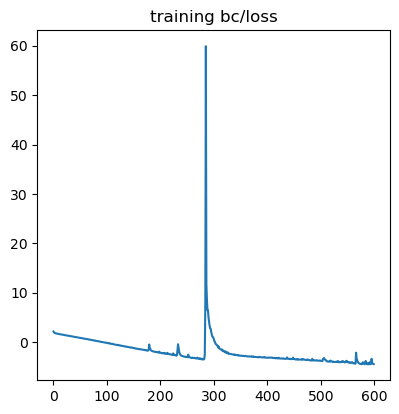

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

y_data = data[:, 5]
x_data = range(0, len(y_data)*2, 2)
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(data[:, 8])
# plt.plot(x_data, y_data)
plt.title("training bc/loss")
plt.show()

# グラフを保存
plt.savefig('bc_loss.png')


In [16]:
import os

new_name = '24-02-08_e600_cnn_nono_S1_direct_2'
# 新しいファイル名
new_csv_filename = './log/progress_' + new_name + '.csv'
new_txt_filename = './log/log_' + new_name + '.txt'

# 旧ファイル名から新ファイル名への変更
os.rename('./log/progress.csv', new_csv_filename)
os.rename('./log/log.txt', new_txt_filename)

# グラフを保存
# plt.savefig('./log/bc_loss_' + new_name + '.png')

from imitation.util import util
util.save_policy(bc_trainer.policy, './model/bc_policy_' + new_name)
bc_trainer.policy.save('./model/bc_policy' + new_name + '.zip')


In [50]:
# グラフを保存
plt.savefig('./log/bc_loss_' + new_name + '.png')

<Figure size 640x480 with 0 Axes>